# Household Pulse Data Analysis

This analysis examines Long Covid (L.C.) prevalence across U.S. states and the District of Columbia, based on data from the U.S. Centers for Disease Control and Prevention (CDC) as of February 2024. We will explore potential predictors of L.C. rates and investigate statistical relationships between these factors. The dataset was curated by Julia Moore Vogel, and this analysis was conducted by Ashley Yaner. As advised by Julia Vogel, Baysian Variable selection, a statistical method used to identify the most relevant predictors or variables in a dataset, will be used to understand the most prevelant factors contributing to the rates of COVID per state. ---> Wordage similar to Bobby's

# Imports

In [1]:
# !pip install --upgrade arviz

In [1]:
from utils.prepare_data import *
from utils.math import *
from utils.plots import *
from utils.data_exploration import *
from model.model_bvs import *
from model.inspect_results_bvs import *

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
import pandas as pd
# Set options for displaying all columns and rows in dataframe for later inspection
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None) 

In [3]:
# Check pymc version for environmental package consistancy
# pm.__version__

# Configs

Path to the household pulse data csv

In [4]:
# houshold_pulse_path = "LC_household_pulse_for_BV_10.csv"
houshold_pulse_path = "data/LC_household_pulse_v11.csv"

# Load Data

Import the houshold pulse data using pandas dataframe. 

In [5]:
df = load_data(houshold_pulse_path)

# Inspect Raw Data

Inspect household pulse data dataframe. What does it contain?

In [6]:
df.head(10)

,State,Sept 24 Value,Sept 24 Low CI,Sept 24 High CI,Urban,Rural,Conservative,Moderate,Liberal,Political Don't know,Political sum,Below Poverty Line,White,Black,AI_AN,Asian,NHPI,Hispanic,Multiple,Percent of total pop with at least one dose,Percent of pop with an updated (bivalent) booster dose,Percent of 5+ pop with a completed primary series,Percent of 12+ pop with at least one dose,Percent of 18+ pop with a completed primary series,Percent of 65+ pop with a completed primary series,Paid sick leave,Medicaid expansion,Eviction moratoria duration,7/11/2022,8/8/2022,9/26/2022,10/17/2022,11/14/2022,12/19/2022,1/16/2023,2/13/2023,3/13/2023,4/10/2023,5/8/2023,6/19/2023,7/10/2023,8/7/2023,9/4/2023,10/2/2023,10/30/2023,2/5/2024,3/4/2024,4/1/2024,4/29/2024,5/27/2024,6/24/2024,7/22/2024,8/19/2024,9/16/2024,Avg,std_error,count
0,Alabama,7.0,4.8,9.6,57.7,42.3,50.0,29.0,12.0,8.0,99.0,16.5,0.647117,0.264309,0.005532,0.015477,0.000526,0.041489,0.025550,65.1,7.7,56.6,74.2,63.3,85.3,0.0,1.0,59.0,9.0,11.2,7.6,8.0,9.0,6.8,7.3,5.7,7.6,7.3,5.5,7.7,6.7,7.1,6.3,8.8,6.8,7.9,8.3,7.4,8.3,8.6,5.0,5.5,7.6,7.0,7.462,0.26,26
1,Alaska,NaN,NaN,NaN,64.9,35.1,34.0,37.0,23.0,6.0,100.0,11.4,0.587953,0.032379,0.148749,0.065232,0.015896,0.052876,0.096915,73.2,14.2,69.8,82.9,75.9,89.5,0.0,1.0,114.0,8.7,7.9,8.1,8.8,8.1,5.5,4.9,5.4,4.9,5.3,9.9,5.2,8.3,7.7,9.1,4.5,5.4,9.2,7.7,8.2,5.7,6.8,6.7,5.4,8.0,NaN,7.016,0.33,25
2,Arizona,5.2,3.7,7.1,89.3,10.7,39.0,31.0,23.0,7.0,100.0,12.6,0.529302,0.047562,0.037277,0.036369,0.001968,0.289346,0.058177,78.4,15.8,70.2,86.9,75.2,90.8,1.0,1.0,0.0,9.6,10.1,6.2,7.9,7.3,6.1,5.9,6.9,7.6,7.0,6.4,8.3,6.4,6.3,6.9,6.2,5.9,6.3,6.4,6.4,5.4,5.9,6.9,4.9,7.4,5.2,6.762,0.24,26
3,Arkansas,6.7,4.3,9.9,55.5,44.5,42.0,38.0,14.0,6.0,100.0,16.8,0.709676,0.153314,0.007915,0.017788,0.004217,0.075664,0.031426,70.1,11.0,60.6,79.5,66.8,84.2,0.0,1.0,0.0,8.9,7.2,9.1,10.5,9.1,6.8,8.0,6.4,6.2,8.9,9.7,6.9,5.7,6.5,5.2,5.9,6.7,8.0,6.5,6.1,5.3,6.6,6.6,8.5,7.6,6.7,7.292,0.28,26
4,California,3.8,2.8,5.0,94.2,5.8,31.0,34.0,29.0,6.0,100.0,12.1,0.347300,0.055794,0.004067,0.155872,0.003738,0.360048,0.073181,85.1,20.6,79.1,94.0,83.9,93.2,1.0,1.0,884.0,7.0,8.7,6.3,7.7,6.8,5.8,5.3,5.8,5.5,5.4,4.7,5.8,4.7,4.9,4.8,4.8,5.5,6.8,7.2,7.2,4.7,5.3,4.1,6.2,4.5,3.8,5.742,0.23,26
5,Colorado,7.6,5.1,10.7,86.0,14.0,33.0,34.0,28.0,5.0,100.0,9.2,0.664714,0.041292,0.006301,0.035518,0.001557,0.197086,0.053532,84.0,22.1,77.7,92.2,82.9,95.0,1.0,1.0,117.0,7.7,9.3,7.8,8.0,6.1,6.6,5.4,7.8,6.1,6.1,7.6,6.4,6.1,6.1,4.7,5.8,5.4,6.4,6.0,9.4,6.1,5.3,6.7,5.7,5.4,7.6,6.600,0.24,26
6,Connecticut,7.5,4.6,11.5,86.3,13.7,33.0,36.0,25.0,6.0,100.0,9.9,0.638607,0.107293,0.002250,0.050398,0.000377,0.144991,0.056084,95.0,25.6,87.1,95.0,91.7,95.0,1.0,1.0,740.0,7.7,7.7,6.5,5.0,7.5,5.2,7.5,5.9,6.7,8.0,6.5,5.1,4.1,5.8,5.8,7.1,5.3,6.3,6.4,7.7,4.6,5.8,5.5,6.3,4.6,7.5,6.235,0.22,26
7,Delaware,NaN,NaN,NaN,82.6,17.4,26.0,40.0,25.0,9.0,100.0,8.7,0.599941,0.224680,0.003000,0.042835,0.000346,0.080055,0.049143,88.5,21.2,77.6,95.0,83.2,95.0,0.0,1.0,205.0,3.8,5.1,8.3,5.9,8.2,5.3,8.4,7.3,6.3,5.9,4.3,7.8,5.6,5.7,5.0,4.5,5.3,4.9,5.2,7.3,5.3,4.3,6.7,NaN,4.2,NaN,5.858,0.28,24
8,District of Columbia,NaN,NaN,NaN,100.0,0.0,15.0,39.0,36.0,10.0,100.0,13.3,0.375333,0.433571,0.002090,0.045114,0.000585,0.087142,0.056165,95.0,32.1,95.0,95.0,95.0,95.0,1.0,1.0,894.0,3.5,6.1,NaN,3.2,3.4,4.1,3.8,3.8,3.2,4.0,2.0,NaN,2.1,3.8,3.7,3.7,NaN,4.5,4.1,4.4,3.2,3.0,2.3,2.6,3.1,NaN,3.527,0.19,22
9,Florida,5.9,4.1,8.0,91.5,8.5,37.0,31.0,24.0,8.0,100.0,12.7,0.523389,0.154157,0.002540,0.030022,0.000683,0.244639,0.044570,82.9,11.7,73.5,92.5,79.6,94.4,0.0,0.0,182.0,7.2,9.1,6.9,4.8,6.3,4.5,5.1,4.6,5.8,4.6,4.3,4.6,5.9,5.3,4.7,5.6,5.0,6.3,6.7,6.4,4.8,5.5,5.3,4.2,4.3,5.9,5.527,0.22,26


Print out summary stats for each column

In [7]:
df.describe()

,Sept 24 Value,Sept 24 Low CI,Sept 24 High CI,Urban,Rural,Conservative,Moderate,Liberal,Political Don't know,Political sum,Below Poverty Line,White,Black,AI_AN,Asian,NHPI,Hispanic,Multiple,Percent of total pop with at least one dose,Percent of pop with an updated (bivalent) booster dose,Percent of 5+ pop with a completed primary series,Percent of 12+ pop with at least one dose,Percent of 18+ pop with a completed primary series,Percent of 65+ pop with a completed primary series,Paid sick leave,Medicaid expansion,Eviction moratoria duration,7/11/2022,8/8/2022,9/26/2022,10/17/2022,11/14/2022,12/19/2022,1/16/2023,2/13/2023,3/13/2023,4/10/2023,5/8/2023,6/19/2023,7/10/2023,8/7/2023,9/4/2023,10/2/2023,10/30/2023,2/5/2024,3/4/2024,4/1/2024,4/29/2024,5/27/2024,6/24/2024,7/22/2024,8/19/2024,9/16/2024,Avg,std_error,count
count,46.000000,46.000000,46.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,51.000000,51.000000,51.000000,51.000000,51.000000,50.000000,52.000000,52.000000,51.000000,52.000000,52.000000,52.000000,52.000000,52.000000,51.000000,52.000000,52.000000,52.000000,52.000000,51.000000,52.000000,52.000000,51.000000,52.000000,52.000000,52.000000,51.000000,50.000000,46.000000,52.000000,52.000000,52.000000
mean,5.667391,3.795652,8.104348,72.974510,27.025490,36.921569,33.392157,23.352941,6.274510,99.941176,12.319231,0.663996,0.112967,0.014922,0.046631,0.003510,0.109343,0.048632,79.211538,17.975000,72.294231,86.025000,77.917308,92.319231,0.313725,0.813725,294.803922,7.743137,7.450980,7.564000,7.126923,7.061538,5.880392,6.250000,6.132692,6.428846,6.411538,6.038462,6.339216,6.034615,6.167308,5.826923,5.628846,5.590196,6.961538,6.676923,7.052941,5.803846,5.996154,5.701923,5.825490,5.902000,5.667391,6.348192,0.262885,25.673077
std,1.458775,1.057871,2.127070,15.167213,15.167213,7.260422,3.092432,5.610075,1.686161,0.506429,2.695169,0.161425,0.102855,0.028033,0.052954,0.013292,0.095221,0.035948,11.108373,6.580091,10.161160,8.598675,9.094875,3.281621,0.468623,0.366889,347.627273,1.857122,1.757199,1.948915,1.829509,1.188202,0.909290,1.420232,1.469923,1.684222,1.353522,1.503871,1.405002,1.193920,1.294289,1.329620,1.514290,0.921793,1.573949,1.326150,1.388575,1.465413,1.302179,1.423678,1.321339,1.747709,1.458775,0.857020,0.067194,0.809773
min,2.600000,1.600000,4.100000,35.100000,0.000000,15.000000,27.000000,12.000000,3.000000,99.000000,6.800000,0.212881,0.005526,0.001459,0.008937,0.000240,0.016769,0.021177,61.100000,6.800000,56.400000,69.800000,63.300000,84.200000,0.000000,0.000000,0.000000,2.900000,4.300000,4.800000,2.500000,3.400000,4.100000,3.300000,2.900000,2.700000,3.900000,2.000000,4.300000,2.100000,3.700000,3.700000,3.000000,3.900000,3.600000,4.100000,3.600000,3.200000,3.000000,2.300000,2.600000,3.100000,2.600000,3.527000,0.140000,22.000000
25%,4.700000,3.025000,6.700000,63.900000,13.950000,32.500000,31.000000,20.000000,5.000000,100.000000,10.475000,0.573536,0.035595,0.002359,0.019174,0.000426,0.045675,0.031407,69.600000,12.475000,63.325000,78.000000,69.550000,89.500000,0.000000,1.000000,57.500000,6.800000,6.200000,6.300000,5.875000,6.400000,5.300000,5.275000,5.100000,5.400000,5.475000,4.900000,5.200000,5.575000,5.375000,5.000000,4.500000,4.950000,6.225000,5.800000,6.400000,4.675000,5.275000,4.775000,5.200000,4.625000,4.700000,5.851250,0.220000,26.000000
50%,5.900000,3.900000,7.900000,73.000000,27.000000,39.000000,33.000000,23.000000,6.000000,100.000000,12.050000,0.680122,0.079630,0.004750,0.031513,0.000694,0.084785,0.040567,78.150000,17.050000,71.050000,86.900000,77.550000,94.450000,0.000000,1.000000,114.000000,7.600000,7.300000,7.200000,7.050000,7.100000,6.000000,6.150000,5.900000,6.300000,6.100000,6.000000,6.100000,6.000000,6.000000,5.700000,5.450000,5.400000,6.800000,6.450000,7.200000,5.450000,6.000000,5.500000,5.800000,5.700000,5.900000,6.276000,0.250000,26.000000
75%,6

# Remove specific columns

If columns appear to be redundant, if columns introduce bias, or if little info about target variable, then remove those columns.

In [8]:
# df['Conservative'] + df['Moderate'] + df['Liberal'] + df["Political Don't know"] 

Remove the following columnar data from the Long Covid dataframe:
1. Race data because it seems that there could be a bias in it's collection. (maybe, maybe not remove these. Still testing)
2. Potential redundant covid vaccine dose data.
3. Political sum because it is nearly 100% most of the time, therefore the values provide little to no information about the target variable.
4. values like count, std error, etc, which we can obtain from datafram descriptions and don't add to the BVS
5. multicollinear variables - urban vs rural (remove rural for example), political don't know doesn't add any more information past all of the other political parties

In [9]:
# cols_to_remove = [
#     # 'White', 'Black', 'AI_AN', 'Asian', 'NHPI', 'Hispanic', 'Multiple',
#     'Rural',
#     'Percent of 5+ pop with a completed primary series',
#     'Percent of 12+ pop with at least one dose',
#     'Percent of 18+ pop with a completed primary series',
#     'Percent of 65+ pop with a completed primary series',
#     'Political sum', "Political Don't know",
#     'std_error', 'count',
#     'Sept 24 Value',
#     'Sept 24 Low CI',
#     'Sept 24 High CI'
# ]

cols_to_remove = [
    'Political sum',
    "Political Don't know",
    'std_error',
    'count',
    'Sept 24 Value',
    'Sept 24 Low CI',
    'Sept 24 High CI'
]


In [10]:
df_cols_removed = remove_columns(df, cols_to_remove) 

In [11]:
df_cols_removed.head(10)

,State,Urban,Rural,Conservative,Moderate,Liberal,Below Poverty Line,White,Black,AI_AN,Asian,NHPI,Hispanic,Multiple,Percent of total pop with at least one dose,Percent of pop with an updated (bivalent) booster dose,Percent of 5+ pop with a completed primary series,Percent of 12+ pop with at least one dose,Percent of 18+ pop with a completed primary series,Percent of 65+ pop with a completed primary series,Paid sick leave,Medicaid expansion,Eviction moratoria duration,7/11/2022,8/8/2022,9/26/2022,10/17/2022,11/14/2022,12/19/2022,1/16/2023,2/13/2023,3/13/2023,4/10/2023,5/8/2023,6/19/2023,7/10/2023,8/7/2023,9/4/2023,10/2/2023,10/30/2023,2/5/2024,3/4/2024,4/1/2024,4/29/2024,5/27/2024,6/24/2024,7/22/2024,8/19/2024,9/16/2024,Avg
0,Alabama,57.7,42.3,50.0,29.0,12.0,16.5,0.647117,0.264309,0.005532,0.015477,0.000526,0.041489,0.025550,65.1,7.7,56.6,74.2,63.3,85.3,0.0,1.0,59.0,9.0,11.2,7.6,8.0,9.0,6.8,7.3,5.7,7.6,7.3,5.5,7.7,6.7,7.1,6.3,8.8,6.8,7.9,8.3,7.4,8.3,8.6,5.0,5.5,7.6,7.0,7.462
1,Alaska,64.9,35.1,34.0,37.0,23.0,11.4,0.587953,0.032379,0.148749,0.065232,0.015896,0.052876,0.096915,73.2,14.2,69.8,82.9,75.9,89.5,0.0,1.0,114.0,8.7,7.9,8.1,8.8,8.1,5.5,4.9,5.4,4.9,5.3,9.9,5.2,8.3,7.7,9.1,4.5,5.4,9.2,7.7,8.2,5.7,6.8,6.7,5.4,8.0,NaN,7.016
2,Arizona,89.3,10.7,39.0,31.0,23.0,12.6,0.529302,0.047562,0.037277,0.036369,0.001968,0.289346,0.058177,78.4,15.8,70.2,86.9,75.2,90.8,1.0,1.0,0.0,9.6,10.1,6.2,7.9,7.3,6.1,5.9,6.9,7.6,7.0,6.4,8.3,6.4,6.3,6.9,6.2,5.9,6.3,6.4,6.4,5.4,5.9,6.9,4.9,7.4,5.2,6.762
3,Arkansas,55.5,44.5,42.0,38.0,14.0,16.8,0.709676,0.153314,0.007915,0.017788,0.004217,0.075664,0.031426,70.1,11.0,60.6,79.5,66.8,84.2,0.0,1.0,0.0,8.9,7.2,9.1,10.5,9.1,6.8,8.0,6.4,6.2,8.9,9.7,6.9,5.7,6.5,5.2,5.9,6.7,8.0,6.5,6.1,5.3,6.6,6.6,8.5,7.6,6.7,7.292
4,California,94.2,5.8,31.0,34.0,29.0,12.1,0.347300,0.055794,0.004067,0.155872,0.003738,0.360048,0.073181,85.1,20.6,79.1,94.0,83.9,93.2,1.0,1.0,884.0,7.0,8.7,6.3,7.7,6.8,5.8,5.3,5.8,5.5,5.4,4.7,5.8,4.7,4.9,4.8,4.8,5.5,6.8,7.2,7.2,4.7,5.3,4.1,6.2,4.5,3.8,5.742
5,Colorado,86.0,14.0,33.0,34.0,28.0,9.2,0.664714,0.041292,0.006301,0.035518,0.001557,0.197086,0.053532,84.0,22.1,77.7,92.2,82.9,95.0,1.0,1.0,117.0,7.7,9.3,7.8,8.0,6.1,6.6,5.4,7.8,6.1,6.1,7.6,6.4,6.1,6.1,4.7,5.8,5.4,6.4,6.0,9.4,6.1,5.3,6.7,5.7,5.4,7.6,6.600
6,Connecticut,86.3,13.7,33.0,36.0,25.0,9.9,0.638607,0.107293,0.002250,0.050398,0.000377,0.144991,0.056084,95.0,25.6,87.1,95.0,91.7,95.0,1.0,1.0,740.0,7.7,7.7,6.5,5.0,7.5,5.2,7.5,5.9,6.7,8.0,6.5,5.1,4.1,5.8,5.8,7.1,5.3,6.3,6.4,7.7,4.6,5.8,5.5,6.3,4.6,7.5,6.235
7,Delaware,82.6,17.4,26.0,40.0,25.0,8.7,0.599941,0.224680,0.003000,0.042835,0.000346,0.080055,0.049143,88.5,21.2,77.6,95.0,83.2,95.0,0.0,1.0,205.0,3.8,5.1,8.3,5.9,8.2,5.3,8.4,7.3,6.3,5.9,4.3,7.8,5.6,5.7,5.0,4.5,5.3,4.9,5.2,7.3,5.3,4.3,6.7,NaN,4.2,NaN,5.858
8,District of Columbia,100.0,0.0,15.0,39.0,36.0,13.3,0.375333,0.433571,0.002090,0.045114,0.000585,0.087142,0.056165,95.0,32.1,95.0,95.0,95.0,95.0,1.0,1.0,894.0,3.5,6.1,NaN,3.2,3.4,4.1,3.8,3.8,3.2,4.0,2.0,NaN,2.1,3.8,3.7,3.7,NaN,4.5,4.1,4.4,3.2,3.0,2.3,2.6,3.1,NaN,3.527
9,Florida,91.5,8.5,37.0,31.0,24.0,12.7,0.523389,0.154157,0.002540,0.030022,0.000683,0.244639,0.044570,82.9,11.7,73.5,92.5,79.6,94.4,0.0,0.0,182.0,7.2,9.1,6.9,4.8,6.3,4.5,5.1,4.6,5.8,4.6,4.3,4.6,5.9,5.3,4.7,5.6,5.0,6.3,6.7,6.4,4.8,5.5,5.3,4.2,4.3,5.9,5.527


# Set States as Index

In [12]:
df_states = set_states_as_idx(df_cols_removed)

In [13]:
# for index, row in df_states.iterrows():
#     if row['Conservative'] > row['Liberal']:
#         print(f'{index}: False, Paid Sick Leave: {row["Paid sick leave"]}')
#     else:
#         print(f'{index}: True, Paid Sick Leave: {row["Paid sick leave"]}')

In [14]:
# find_consv_lib_vs_paid_sick_leave(df_states)

In [15]:
df_states.head(10)

,Urban,Rural,Conservative,Moderate,Liberal,Below Poverty Line,White,Black,AI_AN,Asian,NHPI,Hispanic,Multiple,Percent of total pop with at least one dose,Percent of pop with an updated (bivalent) booster dose,Percent of 5+ pop with a completed primary series,Percent of 12+ pop with at least one dose,Percent of 18+ pop with a completed primary series,Percent of 65+ pop with a completed primary series,Paid sick leave,Medicaid expansion,Eviction moratoria duration,7/11/2022,8/8/2022,9/26/2022,10/17/2022,11/14/2022,12/19/2022,1/16/2023,2/13/2023,3/13/2023,4/10/2023,5/8/2023,6/19/2023,7/10/2023,8/7/2023,9/4/2023,10/2/2023,10/30/2023,2/5/2024,3/4/2024,4/1/2024,4/29/2024,5/27/2024,6/24/2024,7/22/2024,8/19/2024,9/16/2024,Avg
State,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Alabama,57.7,42.3,50.0,29.0,12.0,16.5,0.647117,0.264309,0.005532,0.015477,0.000526,0.041489,0.025550,65.1,7.7,56.6,74.2,63.3,85.3,0.0,1.0,59.0,9.0,11.2,7.6,8.0,9.0,6.8,7.3,5.7,7.6,7.3,5.5,7.7,6.7,7.1,6.3,8.8,6.8,7.9,8.3,7.4,8.3,8.6,5.0,5.5,7.6,7.0,7.462
Alaska,64.9,35.1,34.0,37.0,23.0,11.4,0.587953,0.032379,0.148749,0.065232,0.015896,0.052876,0.096915,73.2,14.2,69.8,82.9,75.9,89.5,0.0,1.0,114.0,8.7,7.9,8.1,8.8,8.1,5.5,4.9,5.4,4.9,5.3,9.9,5.2,8.3,7.7,9.1,4.5,5.4,9.2,7.7,8.2,5.7,6.8,6.7,5.4,8.0,NaN,7.016
Arizona,89.3,10.7,39.0,31.0,23.0,12.6,0.529302,0.047562,0.037277,0.036369,0.001968,0.289346,0.058177,78.4,15.8,70.2,86.9,75.2,90.8,1.0,1.0,0.0,9.6,10.1,6.2,7.9,7.3,6.1,5.9,6.9,7.6,7.0,6.4,8.3,6.4,6.3,6.9,6.2,5.9,6.3,6.4,6.4,5.4,5.9,6.9,4.9,7.4,5.2,6.762
Arkansas,55.5,44.5,42.0,38.0,14.0,16.8,0.709676,0.153314,0.007915,0.017788,0.004217,0.075664,0.031426,70.1,11.0,60.6,79.5,66.8,84.2,0.0,1.0,0.0,8.9,7.2,9.1,10.5,9.1,6.8,8.0,6.4,6.2,8.9,9.7,6.9,5.7,6.5,5.2,5.9,6.7,8.0,6.5,6.1,5.3,6.6,6.6,8.5,7.6,6.7,7.292
California,94.2,5.8,31.0,34.0,29.0,12.1,0.347300,0.055794,0.004067,0.155872,0.003738,0.360048,0.073181,85.1,20.6,79.1,94.0,83.9,93.2,1.0,1.0,884.0,7.0,8.7,6.3,7.7,6.8,5.8,5.3,5.8,5.5,5.4,4.7,5.8,4.7,4.9,4.8,4.8,5.5,6.8,7.2,7.2,4.7,5.3,4.1,6.2,4.5,3.8,5.742
Colorado,86.0,14.0,33.0,34.0,28.0,9.2,0.664714,0.041292,0.006301,0.035518,0.001557,0.197086,0.053532,84.0,22.1,77.7,92.2,82.9,95.0,1.0,1.0,117.0,7.7,9.3,7.8,8.0,6.1,6.6,5.4,7.8,6.1,6.1,7.6,6.4,6.1,6.1,4.7,5.8,5.4,6.4,6.0,9.4,6.1,5.3,6.7,5.7,5.4,7.6,6.600
Connecticut,86.3,13.7,33.0,36.0,25.0,9.9,0.638607,0.107293,0.002250,0.050398,0.000377,0.144991,0.056084,95.0,25.6,87.1,95.0,91.7,95.0,1.0,1.0,740.0,7.7,7.7,6.5,5.0,7.5,5.2,7.5,5.9,6.7,8.0,6.5,5.1,4.1,5.8,5.8,7.1,5.3,6.3,6.4,7.7,4.6,5.8,5.5,6.3,4.6,7.5,6.235
Delaware,82.6,17.4,26.0,40.0,25.0,8.7,0.599941,0.224680,0.003000,0.042835,0.000346,0.080055,0.049143,88.5,21.2,77.6,95.0,83.2,95.0,0.0,1.0,205.0,3.8,5.1,8.3,5.9,8.2,5.3,8.4,7.3,6.3,5.9,4.3,7.8,5.6,5.7,5.0,4.5,5.3,4.9,5.2,7.3,5.3,4.3,6.7,NaN,4.2,NaN,5.858
District of Columbia,100.0,0.0,15.0,39.0,36.0,13.3,0.375333,0.433571,0.002090,0.045114,0.000585,0.087142,0.056165,95.0,32.1,95.0,95.0,95.0,95.0,1.0,1.0,894.0,3.5,6.1,NaN,3.2,3.4,4.1,3.8,3.8,3.2,4.0,2.0,NaN,2.1,3.8,3.7,3.7,NaN,4.5,4.1,4.4,3.2,3.0,2.3,2.6,3.1,NaN,3.527


# If dates are in various versions of mm/dd/yyyy format, convert all to mm/dd/yyyy

In [16]:
col_name_patterns = [
    r"(\d{2})/(\d{2})/(\d{4})",  # mm/dd/yyyy
    r"(\d)/(\d{2})/(\d{4})",  # m/dd/yyyy
    r"(\d)/(\d)/(\d{4})",  # m/d/yyyy
    r"(\d{2})/(\d)/(\d{4})"  # mm/d/yyyy
]

In [17]:
df_states = convert_dates_to_same_format(df_states, col_name_patterns)

('7', '11', '2022')
('8', '8', '2022')
('9', '26', '2022')
('10', '17', '2022')
('11', '14', '2022')
('12', '19', '2022')
('1', '16', '2023')
('2', '13', '2023')
('3', '13', '2023')
('4', '10', '2023')
('5', '8', '2023')
('6', '19', '2023')
('7', '10', '2023')
('8', '7', '2023')
('9', '4', '2023')
('10', '2', '2023')
('10', '30', '2023')
('2', '5', '2024')
('3', '4', '2024')
('4', '1', '2024')
('4', '29', '2024')
('5', '27', '2024')
('6', '24', '2024')
('7', '22', '2024')
('8', '19', '2024')
('9', '16', '2024')


In [18]:
df_states.head(10)

,Urban,Rural,Conservative,Moderate,Liberal,Below Poverty Line,White,Black,AI_AN,Asian,NHPI,Hispanic,Multiple,Percent of total pop with at least one dose,Percent of pop with an updated (bivalent) booster dose,Percent of 5+ pop with a completed primary series,Percent of 12+ pop with at least one dose,Percent of 18+ pop with a completed primary series,Percent of 65+ pop with a completed primary series,Paid sick leave,Medicaid expansion,Eviction moratoria duration,07/11/2022,08/08/2022,09/26/2022,10/17/2022,11/14/2022,12/19/2022,01/16/2023,02/13/2023,03/13/2023,04/10/2023,05/08/2023,06/19/2023,07/10/2023,08/07/2023,09/04/2023,10/02/2023,10/30/2023,02/05/2024,03/04/2024,04/01/2024,04/29/2024,05/27/2024,06/24/2024,07/22/2024,08/19/2024,09/16/2024,Avg
State,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Alabama,57.7,42.3,50.0,29.0,12.0,16.5,0.647117,0.264309,0.005532,0.015477,0.000526,0.041489,0.025550,65.1,7.7,56.6,74.2,63.3,85.3,0.0,1.0,59.0,9.0,11.2,7.6,8.0,9.0,6.8,7.3,5.7,7.6,7.3,5.5,7.7,6.7,7.1,6.3,8.8,6.8,7.9,8.3,7.4,8.3,8.6,5.0,5.5,7.6,7.0,7.462
Alaska,64.9,35.1,34.0,37.0,23.0,11.4,0.587953,0.032379,0.148749,0.065232,0.015896,0.052876,0.096915,73.2,14.2,69.8,82.9,75.9,89.5,0.0,1.0,114.0,8.7,7.9,8.1,8.8,8.1,5.5,4.9,5.4,4.9,5.3,9.9,5.2,8.3,7.7,9.1,4.5,5.4,9.2,7.7,8.2,5.7,6.8,6.7,5.4,8.0,NaN,7.016
Arizona,89.3,10.7,39.0,31.0,23.0,12.6,0.529302,0.047562,0.037277,0.036369,0.001968,0.289346,0.058177,78.4,15.8,70.2,86.9,75.2,90.8,1.0,1.0,0.0,9.6,10.1,6.2,7.9,7.3,6.1,5.9,6.9,7.6,7.0,6.4,8.3,6.4,6.3,6.9,6.2,5.9,6.3,6.4,6.4,5.4,5.9,6.9,4.9,7.4,5.2,6.762
Arkansas,55.5,44.5,42.0,38.0,14.0,16.8,0.709676,0.153314,0.007915,0.017788,0.004217,0.075664,0.031426,70.1,11.0,60.6,79.5,66.8,84.2,0.0,1.0,0.0,8.9,7.2,9.1,10.5,9.1,6.8,8.0,6.4,6.2,8.9,9.7,6.9,5.7,6.5,5.2,5.9,6.7,8.0,6.5,6.1,5.3,6.6,6.6,8.5,7.6,6.7,7.292
California,94.2,5.8,31.0,34.0,29.0,12.1,0.347300,0.055794,0.004067,0.155872,0.003738,0.360048,0.073181,85.1,20.6,79.1,94.0,83.9,93.2,1.0,1.0,884.0,7.0,8.7,6.3,7.7,6.8,5.8,5.3,5.8,5.5,5.4,4.7,5.8,4.7,4.9,4.8,4.8,5.5,6.8,7.2,7.2,4.7,5.3,4.1,6.2,4.5,3.8,5.742
Colorado,86.0,14.0,33.0,34.0,28.0,9.2,0.664714,0.041292,0.006301,0.035518,0.001557,0.197086,0.053532,84.0,22.1,77.7,92.2,82.9,95.0,1.0,1.0,117.0,7.7,9.3,7.8,8.0,6.1,6.6,5.4,7.8,6.1,6.1,7.6,6.4,6.1,6.1,4.7,5.8,5.4,6.4,6.0,9.4,6.1,5.3,6.7,5.7,5.4,7.6,6.600
Connecticut,86.3,13.7,33.0,36.0,25.0,9.9,0.638607,0.107293,0.002250,0.050398,0.000377,0.144991,0.056084,95.0,25.6,87.1,95.0,91.7,95.0,1.0,1.0,740.0,7.7,7.7,6.5,5.0,7.5,5.2,7.5,5.9,6.7,8.0,6.5,5.1,4.1,5.8,5.8,7.1,5.3,6.3,6.4,7.7,4.6,5.8,5.5,6.3,4.6,7.5,6.235
Delaware,82.6,17.4,26.0,40.0,25.0,8.7,0.599941,0.224680,0.003000,0.042835,0.000346,0.080055,0.049143,88.5,21.2,77.6,95.0,83.2,95.0,0.0,1.0,205.0,3.8,5.1,8.3,5.9,8.2,5.3,8.4,7.3,6.3,5.9,4.3,7.8,5.6,5.7,5.0,4.5,5.3,4.9,5.2,7.3,5.3,4.3,6.7,NaN,4.2,NaN,5.858
District of Columbia,100.0,0.0,15.0,39.0,36.0,13.3,0.375333,0.433571,0.002090,0.045114,0.000585,0.087142,0.056165,95.0,32.1,95.0,95.0,95.0,95.0,1.0,1.0,894.0,3.5,6.1,NaN,3.2,3.4,4.1,3.8,3.8,3.2,4.0,2.0,NaN,2.1,3.8,3.7,3.7,NaN,4.5,4.1,4.4,3.2,3.0,2.3,2.6,3.1,NaN,3.527


# Extract Long COVID Rates
Separate long covid rate target variables from the predictor variables

In [19]:
# The regular expression pattern to extract, here, includes both the excel dates and Avg columns

# col_name_patterns = ["^[0-9]+$|Avg"]  # original data pattern

# Next data format pattern, but that changed
# col_name_patterns = [
#     r"\d{2}/\d{2}/\d{4}",  # mm/dd/yyyy
#     r"\d/\d{2}/\d{4}",  # m/dd/yyyy
#     r"\d/\d/\d{4}",  # m/d/yyyy
#     r"\d{2}/\d/\d{4}",  # mm/d/yyyy
#     r"Avg"  # Avg column
# ]

# Most recent data format pattern
col_name_patterns = [
    r"\d{2}/\d{2}/\d{4}", # mm/dd/yyyy,
    r"Avg"
]

lc_rates = extract_lc_rates(df_states, col_name_patterns) 

In [20]:
lc_rates.head(10)

,07/11/2022,08/08/2022,09/26/2022,10/17/2022,11/14/2022,12/19/2022,01/16/2023,02/13/2023,03/13/2023,04/10/2023,05/08/2023,06/19/2023,07/10/2023,08/07/2023,09/04/2023,10/02/2023,10/30/2023,02/05/2024,03/04/2024,04/01/2024,04/29/2024,05/27/2024,06/24/2024,07/22/2024,08/19/2024,09/16/2024,Avg
State,,,,,,,,,,,,,,,,,,,,,,,,,,,
Alabama,9.0,11.2,7.6,8.0,9.0,6.8,7.3,5.7,7.6,7.3,5.5,7.7,6.7,7.1,6.3,8.8,6.8,7.9,8.3,7.4,8.3,8.6,5.0,5.5,7.6,7.0,7.462
Alaska,8.7,7.9,8.1,8.8,8.1,5.5,4.9,5.4,4.9,5.3,9.9,5.2,8.3,7.7,9.1,4.5,5.4,9.2,7.7,8.2,5.7,6.8,6.7,5.4,8.0,NaN,7.016
Arizona,9.6,10.1,6.2,7.9,7.3,6.1,5.9,6.9,7.6,7.0,6.4,8.3,6.4,6.3,6.9,6.2,5.9,6.3,6.4,6.4,5.4,5.9,6.9,4.9,7.4,5.2,6.762
Arkansas,8.9,7.2,9.1,10.5,9.1,6.8,8.0,6.4,6.2,8.9,9.7,6.9,5.7,6.5,5.2,5.9,6.7,8.0,6.5,6.1,5.3,6.6,6.6,8.5,7.6,6.7,7.292
California,7.0,8.7,6.3,7.7,6.8,5.8,5.3,5.8,5.5,5.4,4.7,5.8,4.7,4.9,4.8,4.8,5.5,6.8,7.2,7.2,4.7,5.3,4.1,6.2,4.5,3.8,5.742
Colorado,7.7,9.3,7.8,8.0,6.1,6.6,5.4,7.8,6.1,6.1,7.6,6.4,6.1,6.1,4.7,5.8,5.4,6.4,6.0,9.4,6.1,5.3,6.7,5.7,5.4,7.6,6.600
Connecticut,7.7,7.7,6.5,5.0,7.5,5.2,7.5,5.9,6.7,8.0,6.5,5.1,4.1,5.8,5.8,7.1,5.3,6.3,6.4,7.7,4.6,5.8,5.5,6.3,4.6,7.5,6.235
Delaware,3.8,5.1,8.3,5.9,8.2,5.3,8.4,7.3,6.3,5.9,4.3,7.8,5.6,5.7,5.0,4.5,5.3,4.9,5.2,7.3,5.3,4.3,6.7,NaN,4.2,NaN,5.858
District of Columbia,3.5,6.1,NaN,3.2,3.4,4.1,3.8,3.8,3.2,4.0,2.0,NaN,2.1,3.8,3.7,3.7,NaN,4.5,4.1,4.4,3.2,3.0,2.3,2.6,3.1,NaN,3.527


# Convert Excel Date to Human Readable Dates ** SKIP with V11 Data **

In [21]:
# lc_rates_dates_converted = convert_excel_dates(lc_rates)

In [22]:
# lc_rates_dates_converted.head(10)

## Convert matrix to vector
Flatten dataframe for qq plotting

In [23]:
lc_rates_flat = matrix_to_vector(lc_rates)

print(f"lc rates num of state rows: {lc_rates.shape[0]}")
print(f"lc rates num of rate columns: {lc_rates.shape[1]}")
print(f"lc rates total num of data points: {len(lc_rates_flat)}")
print(f"lc rates min: {lc_rates_flat.min()}, max: {lc_rates_flat.max()}")

lc rates num of state rows: 51
lc rates num of rate columns: 27
lc rates total num of data points: 1377
lc rates min: 2.0, max: 16.5


In [24]:
# lc_rates_flat['Alabama']

# Normalize
Standardization, or converting data to z-scores, is a common preprocessing step in many machine learning algorithms, including Bayesian variable selection, for the following reasons: 
1. Scale Invariance:
    - Standardizing the data ensures that all features are on a comparable scale, preventing features with larger magnitudes from dominating the model.
2. Regularization:
     - Prevent overfitting.
     - Standardizing the data can help regularization techniques work more effectively by ensuring that all features have a similar impact on the model.
3. Prior Distribution Choice:
    - When using prior distributions for Bayesian modeling, standardizing the data can make it easier to choose appropriate priors.
4. Interpretability:
    - Standardized coefficients can be more interpretable than unstandardized coefficients.
    - A standardized coefficient represents the change in the target variable for a one standard deviation increase in the predictor variable, which can provide a clearer understanding of the feature's importance.

## Compute Zscore

### Compute Z-Score for flattened numpy array

In [25]:
lc_rates_flat_z_scores = compute_zscore_np(lc_rates_flat)

### Compute Z-Score for dataframe

In [26]:
lc_rates_zscore = compute_zscore_df(lc_rates)

In [27]:
lc_rates_zscore.head(10)

,07/11/2022,08/08/2022,09/26/2022,10/17/2022,11/14/2022,12/19/2022,01/16/2023,02/13/2023,03/13/2023,04/10/2023,05/08/2023,06/19/2023,07/10/2023,08/07/2023,09/04/2023,10/02/2023,10/30/2023,02/05/2024,03/04/2024,04/01/2024,04/29/2024,05/27/2024,06/24/2024,07/22/2024,08/19/2024,09/16/2024,Avg
State,,,,,,,,,,,,,,,,,,,,,,,,,,,
Alabama,0.668492,2.113911,1.451508e-02,0.471193,1.611858,0.999512,0.727689,-0.296009,0.684017,0.645814,-0.360489,9.545816e-01,0.548217,0.708582,0.347730,2.070280,1.294332e+00,0.588441,1.212185,0.245276,1.681910,1.979963,-0.494052,-2.488890e-01,0.957474,8.984184e-01,1.282167
Alaska,0.508566,0.254661,2.685290e-01,0.904182,0.861510,-0.415919,-0.946543,-0.498194,-0.904333,-0.818030,2.538931,-8.079398e-01,1.875649,1.167960,2.434108,-0.742684,-2.107052e-01,1.406338,0.764204,0.815687,-0.076933,0.611284,0.689216,-3.238556e-01,1.184123,6.908054e-17,0.766425
Arizona,0.988345,1.494161,-6.967239e-01,0.417070,0.194535,0.237357,-0.248946,0.512731,0.684017,0.426237,0.232574,1.377587e+00,0.299323,0.096079,0.794811,0.369418,3.268081e-01,-0.418200,-0.206423,-0.467736,-0.279876,-0.073056,0.828425,-6.986885e-01,0.844150,-3.225865e-01,0.472707
Arkansas,0.615184,-0.139725,7.765568e-01,1.824282,1.695229,0.999512,1.216007,0.175756,-0.139572,1.816889,2.407139,3.905747e-01,-0.281429,0.249205,-0.471919,0.173165,1.186829e+00,0.651357,-0.131759,-0.681640,-0.347524,0.459208,0.619612,2.000108e+00,0.957474,6.949176e-01,1.085584
California,-0.397684,0.705388,-6.459211e-01,0.308823,-0.222325,-0.089281,-0.667504,-0.228614,-0.551366,-0.744838,-0.887657,-3.849347e-01,-1.111074,-0.975802,-0.769973,-0.546431,-1.032026e-01,-0.103625,0.390886,0.102674,-0.753411,-0.529282,-1.120489,2.758770e-01,-0.799052,-1.272257e+00,-0.706793
Colorado,-0.024522,1.043434,1.161206e-01,0.471193,-0.805929,0.781753,-0.597745,1.119286,-0.198400,-0.232493,1.023325,3.807046e-02,0.050429,-0.057047,-0.844487,0.107747,-2.107052e-01,-0.355285,-0.505077,1.671302,0.193658,-0.529282,0.689216,-9.895588e-02,-0.289093,1.305420e+00,0.285374
Connecticut,-0.024522,0.141979,-5.443155e-01,-1.152513,0.361278,-0.742557,0.867209,-0.161219,0.154567,1.158159,0.298470,-8.784406e-01,-1.608861,-0.286736,-0.024838,0.958178,-3.182079e-01,-0.418200,-0.206423,0.459180,-0.821058,-0.149094,-0.146032,3.508436e-01,-0.742390,1.237586e+00,-0.136701
Delaware,-2.103565,-1.322885,3.701346e-01,-0.665401,0.944882,-0.633678,1.495046,0.782311,-0.080744,-0.378877,-1.151241,1.025082e+00,-0.364393,-0.363299,-0.620946,-0.742684,-3.182079e-01,-1.299012,-1.102386,0.173975,-0.347524,-1.289660,0.689216,-5.417888e-16,-0.969038,6.908054e-17,-0.572653
District of Columbia,-2.263492,-0.759476,9.063045e-17,-2.126737,-3.056971,-1.940229,-1.713899,-1.576514,-1.904405,-1.769529,-2.666847,-6.217249e-17,-3.268151,-1.817994,-1.589622,-1.266026,9.103829e-16,-1.550673,-1.923685,-1.893762,-1.768128,-2.278150,-2.373361,-2.422920e+00,-1.592322,6.908054e-17,-3.268156


In [28]:
check_df_for_nan_inf_zero(lc_rates_zscore)

Is NaN: 07/11/2022    False
08/08/2022    False
09/26/2022    False
10/17/2022    False
11/14/2022    False
12/19/2022    False
01/16/2023    False
02/13/2023    False
03/13/2023    False
04/10/2023    False
05/08/2023    False
06/19/2023    False
07/10/2023    False
08/07/2023    False
09/04/2023    False
10/02/2023    False
10/30/2023    False
02/05/2024    False
03/04/2024    False
04/01/2024    False
04/29/2024    False
05/27/2024    False
06/24/2024    False
07/22/2024    False
08/19/2024    False
09/16/2024    False
Avg           False
dtype: bool
Is INF: 07/11/2022    False
08/08/2022    False
09/26/2022    False
10/17/2022    False
11/14/2022    False
12/19/2022    False
01/16/2023    False
02/13/2023    False
03/13/2023    False
04/10/2023    False
05/08/2023    False
06/19/2023    False
07/10/2023    False
08/07/2023    False
09/04/2023    False
10/02/2023    False
10/30/2023    False
02/05/2024    False
03/04/2024    False
04/01/2024    False
04/29/2024    False
05/27/2024  

# Q-Q Plot

theoretical_quantiles min: -3.1806387074175153, max: 3.1806387074174944
data min: -2.7728982055990428, max: 6.444366619130087
len(data): 1360


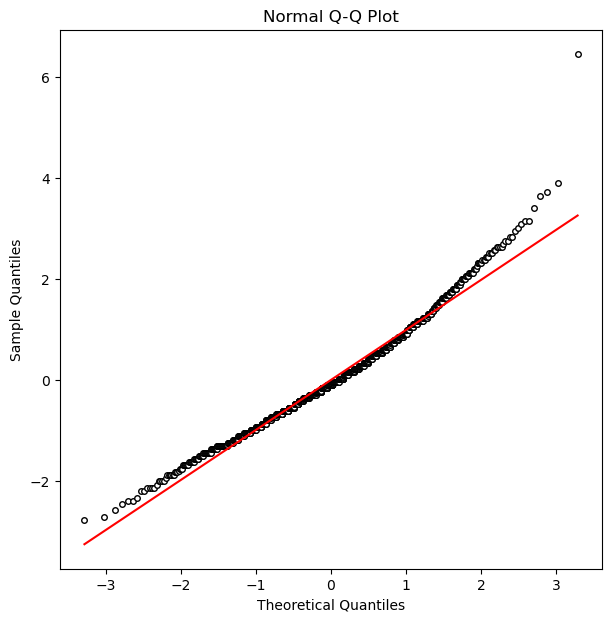

In [29]:
create_qq_plot(lc_rates_flat_z_scores)

## Dendrogram

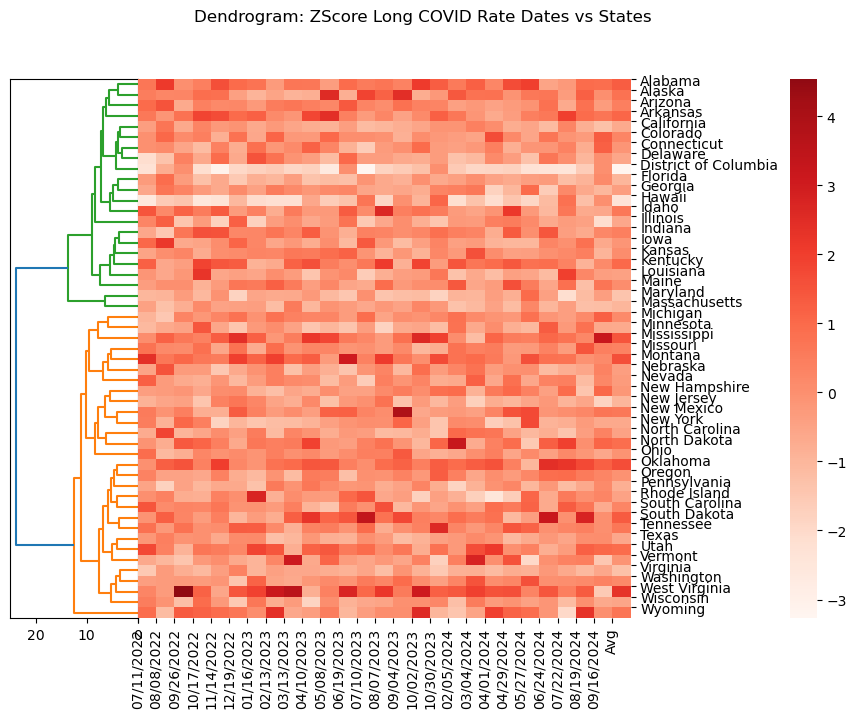

In [30]:
dendrogram(lc_rates_zscore)

# Get predictor variables
Separate predictor variables from dataframe

In [31]:
# list_of_cols_to_remove = [
#     'Avg', 'std_error', 'count',
#     'Sept 24 Value', 'Sept 24 Low CI', 'Sept 24 High CI']


# df_variables = get_variables_df(
# df_states,
# list_of_cols_to_remove,
# pattern="^[0-9]+$"
# )


# This will be used for BVS as the target variable later on
list_of_cols_to_remove = ['Avg']  

df_variables = get_variables_df(
    df_states,
    list_of_cols_to_remove,
    pattern_date="\d{2}/\d{2}/\d{4}"
)

In [32]:
df_variables.describe()

,Urban,Rural,Conservative,Moderate,Liberal,Below Poverty Line,White,Black,AI_AN,Asian,NHPI,Hispanic,Multiple,Percent of total pop with at least one dose,Percent of pop with an updated (bivalent) booster dose,Percent of 5+ pop with a completed primary series,Percent of 12+ pop with at least one dose,Percent of 18+ pop with a completed primary series,Percent of 65+ pop with a completed primary series,Paid sick leave,Medicaid expansion,Eviction moratoria duration
count,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000
mean,72.974510,27.025490,36.921569,33.392157,23.352941,12.313725,0.665471,0.112706,0.015072,0.046352,0.003541,0.108229,0.048628,79.566667,18.103922,72.605882,86.343137,78.203922,92.405882,0.313725,0.813725,294.803922
std,15.167213,15.167213,7.260422,3.092432,5.610075,2.721692,0.162677,0.103861,0.028291,0.053442,0.013422,0.095826,0.036306,10.916715,6.578904,10.008125,8.369451,8.945054,3.253639,0.468623,0.366889,347.627273
min,35.100000,0.000000,15.000000,27.000000,12.000000,6.800000,0.212881,0.005526,0.001459,0.008937,0.000240,0.016769,0.021177,61.800000,6.800000,56.600000,70.900000,63.300000,84.200000,0.000000,0.000000,0.000000
25%,63.900000,13.950000,32.500000,31.000000,20.000000,10.450000,0.569132,0.035174,0.002341,0.018988,0.000420,0.044280,0.031388,69.750000,12.850000,63.450000,78.500000,69.750000,89.550000,0.000000,1.000000,57.500000
50%,73.000000,27.000000,39.000000,33.000000,23.000000,12.000000,0.695530,0.075402,0.004396,0.031290,0.000683,0.083772,0.039490,78.400000,17.100000,71.200000,86.900000,77.700000,94.500000,0.000000,1.000000,114.000000
75%,86.050000,36.100000,42.000000,35.500000,27.500000,13.350000,0.780268,0.148758,0.009580,0.052204,0.001575,0.125911,0.056124,90.650000,22.400000,79.400000,95.000000,84.650000,95.000000,1.000000,1.000000,511.000000
max,100.000000,64.900000,50.000000,42.000000,36.000000,19.100000,0.921946,0.433571,0.148749,0.358978,0.095339,0.454334,0.271867,95.000000,34.300000,95.000000,95.000000,95.000000,95.000000,1.000000,1.000000,1221.000000


In [33]:
len(df_variables.columns)

22

In [34]:
df_variables.columns

Index(['Urban', 'Rural', 'Conservative', 'Moderate', 'Liberal',
       'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'NHPI',
       'Hispanic', 'Multiple', 'Percent of total pop with at least one dose',
       'Percent of pop with an updated (bivalent) booster dose',
       'Percent of 5+ pop with a completed primary series',
       'Percent of 12+ pop with at least one dose',
       'Percent of 18+ pop with a completed primary series',
       'Percent of 65+ pop with a completed primary series', 'Paid sick leave',
       'Medicaid expansion', 'Eviction moratoria duration'],
      dtype='object')

# Visualize Predictors Variables vs Target Variable

In [35]:
# plot_hist(df_variables)

In [36]:
# for var in df_variables.columns: 
#     plt.scatter(lc_rates[["Avg"]], df_variables[[var]])
#     plt.title(var)
#     plt.show()
    
# plot_scatter(lc_rates, df_variables, col_target='Avg')

In [37]:
len(df_variables[df_variables['Paid sick leave'] == 0])

35

In [38]:
len(df_variables[df_variables['Paid sick leave'] == 1])

16

# Investigate correlations between variables

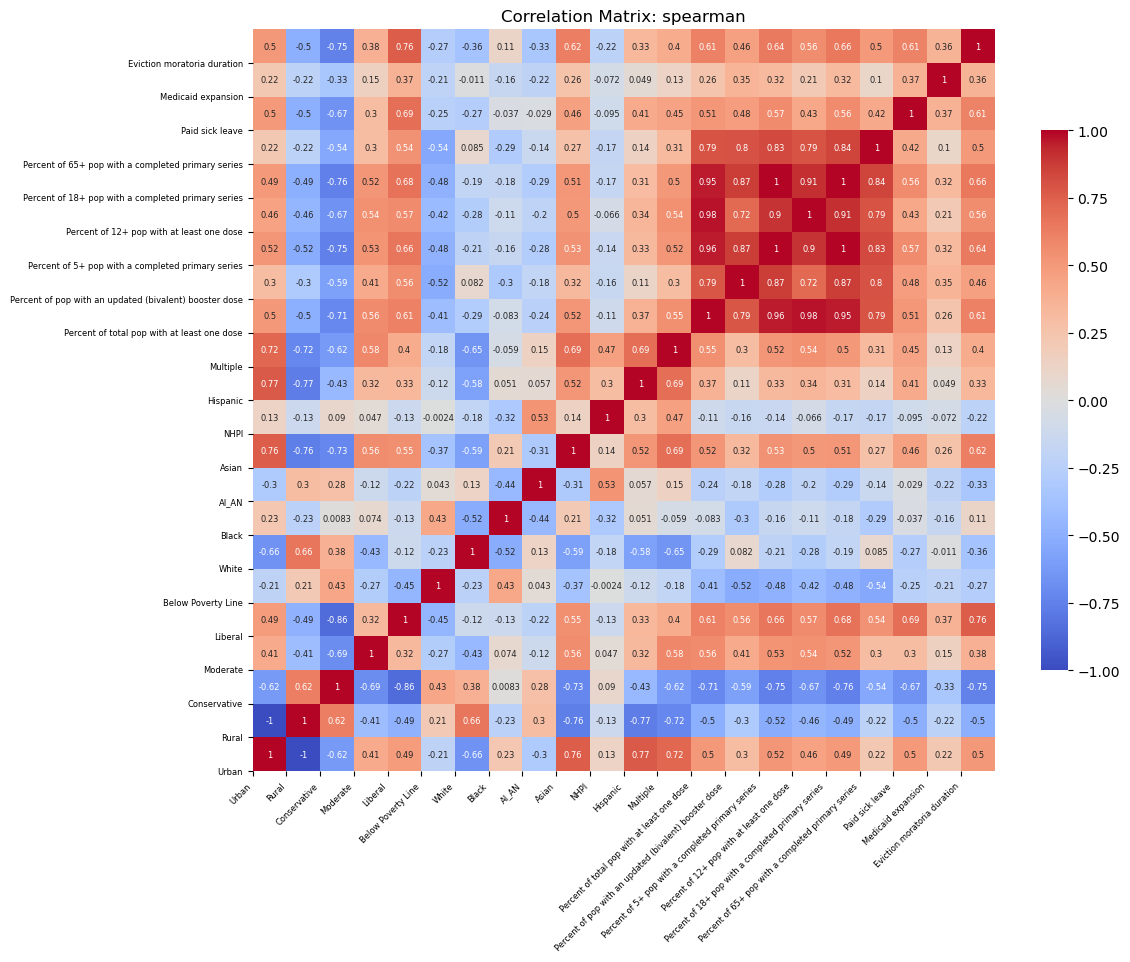

In [39]:
plot_correlation_matrix(
    df_variables,
    method='spearman',
    plot_title="Variable Correlations",
    corr_label_size=6,
    axis_label_size=6,
    fig_size=(12, 12),
    save_image=False,
    image_path="results/data_exploration/v11_correlation_matrix_kendall.png"
)

In [40]:
df_variable_correlations = calc_variable_correlations(df_variables)

In [41]:
df_variable_correlations.head(25)

,Variable 1,Variable 2,Correlation
0,Urban,Rural,-1.000000
1,Percent of 5+ pop with a completed primary series,Percent of 18+ pop with a completed primary series,0.997036
2,Percent of total pop with at least one dose,Percent of 12+ pop with at least one dose,0.976094
3,Percent of total pop with at least one dose,Percent of 5+ pop with a completed primary series,0.955817
4,Percent of total pop with at least one dose,Percent of 18+ pop with a completed primary series,0.954799
5,Percent of 12+ pop with at least one dose,Percent of 18+ pop with a completed primary series,0.906311
6,Percent of 5+ pop with a completed primary series,Percent of 12+ pop with at least one dose,0.904325
7,Percent of pop with an updated (bivalent) booster dose,Percent of 5+ pop with a completed primary series,0.873085
8,Percent of pop with an updated (bivalent) booster dose,Percent of 18+ pop with a completed primary series,0.868018
9,Conservative,Liberal,-0.858659


## Pair down variables given correlations

Types of correlations considered: 

- Pearson Correlation:
    - Primarily measures the strength of a linear relationship between two variables.   
- Spearman Correlation:
    - Measures the strength of a monotonic relationship between two variables.
    - As one variable increases, the other variable either consistently increases or consistently decreases.   
    - This can include non-linear trends like curves or S-shapes.

Chose pearson for simplicity.

In [69]:
# removed_variables_list, df_cleaned = calc_variable_correlations_with_removal(
#     df_variables,
#     lc_rates['Avg'],
#     method='pearson',
#     threshold = 0.7
# )

removed_variables_list, df_variables_cleaned = calc_variable_correlations_with_removal_lc_rates(
    df=df_variables, 
    target_var=pd.Series(lc_rates['Avg']),
    method='pearson',
    threshold = 0.65
)

corr_var_target["Urban"]: -0.6276044523367557
corr_var_target["Rural"]: 0.6276044523367558
corr_var_target["Liberal"]: -0.5358645203463257
corr_var_target["Conservative"]: 0.6867807840225538


In [70]:
removed_variables_list

['Percent of 5+ pop with a completed primary series',
 'Paid sick leave',
 'Percent of 18+ pop with a completed primary series',
 'NHPI',
 'Percent of total pop with at least one dose',
 'Eviction moratoria duration',
 'Urban',
 'Liberal',
 'Percent of 12+ pop with at least one dose',
 'Moderate',
 'Percent of 65+ pop with a completed primary series',
 'Percent of pop with an updated (bivalent) booster dose',
 'Multiple']

In [71]:
for col in df_variables_cleaned.columns:
    print(col) 

Rural
Conservative
Below Poverty Line
White
Black
AI_AN
Asian
Hispanic
Medicaid expansion


### Add back in race data based off of prior knowledge

In [72]:
prior_knowledge_cols = [
    'NHPI',
    'Multiple'
]

# Select the specified columns from df2
df_var_subset = df_variables[prior_knowledge_cols]

# Concatenate df1 and df2_selected along the columns (axis=1)
df_variables_final = pd.concat([df_variables_cleaned, df_var_subset], axis=1)


In [73]:
for col in df_variables_final.columns:
    print(col) 

Rural
Conservative
Below Poverty Line
White
Black
AI_AN
Asian
Hispanic
Medicaid expansion
NHPI
Multiple


---
# Bayesian Variable Selection
---

### Variable Sensitivity Analysis - Hyperparameter Tuning using Optuna

In [74]:
# model_params = {
#     # "alpha_sigma": 3, # Typical values 1 - 5
#     # "beta_sigma": 0.75, # Typical values 0.1 - 1
#     "mu": 0, # Typical value 0
#     # "sigma": 2, # Typical values 1 - 5
#     # "prob_of_success": 0.2, # Typical values 0.1 - 0.5
#     "draws": 2000, # Defaults to 2000 in pm
#     "kernel": pm.smc.IMH, # Defaults to IMH for Monte Carlo in pm
#     # "kernel": pm.smc.kernels.IMH, # Defaults to IMH for Monte Carlo in pm
#     # "kernel": pm.smc.MH, # Defaults to IMH for Monte Carlo in pm
#     "scale_predictors": True,
#     "scale_function": "z-score",
#     "predictors_to_scale": [
#         "Urban",
#         "Conservative",
#         "Moderate",
#         "Liberal",
#         "Below Poverty Line",
#         'White',
#         'Black',
#         'AI_AN',
#         'Asian',
#         'NHPI',
#         'Hispanic',
#         'Multiple',
#         "Percent of total pop with at least one dose",
#         "Percent of pop with an updated (bivalent) booster dose",
#         'Medicaid expansion',
#         "Eviction moratoria duration"
#     ],
#     "cores": 4, # Number of CPUs
# }


# model_params = {
#     "mu": 0, # Typical value 0
#     "draws": 2000, # Defaults to 2000 in pm
#     "kernel": pm.smc.IMH, # Defaults to IMH for Monte Carlo in pm
#     "scale_predictors": True,
#     "scale_function": "z-score",
#     "cores": 4, # Number of CPUs
# }

# model_params = {
#     "mu": 0, # Typical value 0
#     "draws": 100, # Defaults to 2000 in pm
#     "kernel": pm.smc.IMH, # Defaults to IMH for Monte Carlo in pm
#     "scale_predictors": True,
#     "scale_function": "z-score",
#     "cores": 4, # Number of CPUs
# }

In [75]:
best_params = run_optuna_hyperparameter_optimization(
    df_variables_final, 
    lc_rates['Avg'],
    model_params,
    n_trials=100,
    sampler_type="QMC",
    study_name="LC_hyperparam_optimization_culled_vars_QMC_IMH_2025" # Unique id of hyperparameters study.
)

D:\ScrippsResearch\HouseholdPulse\model\model_bvs.py:518: ExperimentalWarning: QMCSampler is experimental (supported from v3.0.0). The interface can change in the future.
  sampler = optuna.samplers.QMCSampler()
[I 2025-01-16 16:54:51,255] A new study created in RDB with name: no-name-8dbce337-3a16-40e8-aabb-1a2888ed86e0


A new study created in RDB with name: no-name-8dbce337-3a16-40e8-aabb-1a2888ed86e0


Initializing SMC sampler...


scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Sampling 4 chains in 4 jobs


Output()

The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.2962731526008273


[I 2025-01-16 16:55:27,389] Trial 0 finished with value: -3.2962731526008273 and parameters: {'alpha_sigma': 6.0, 'beta_sigma': 0.6, 'sigma': 4, 'prob_of_success': 0.2}. Best is trial 0 with value: -3.2962731526008273.


Trial 0 finished with value: -3.2962731526008273 and parameters: {'alpha_sigma': 6.0, 'beta_sigma': 0.6, 'sigma': 4, 'prob_of_success': 0.2}. Best is trial 0 with value: -3.2962731526008273.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


C:\Users\ashle\anaconda3\Lib\site-packages\arviz\data\base.py:272: UserWarning: More chains (4) than draws (3). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.289841651916599


[I 2025-01-16 16:55:51,874] Trial 1 finished with value: -3.289841651916599 and parameters: {'alpha_sigma': 1.0, 'beta_sigma': 0.1, 'sigma': 1, 'prob_of_success': 0.1}. Best is trial 0 with value: -3.2962731526008273.


Trial 1 finished with value: -3.289841651916599 and parameters: {'alpha_sigma': 1.0, 'beta_sigma': 0.1, 'sigma': 1, 'prob_of_success': 0.1}. Best is trial 0 with value: -3.2962731526008273.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.3058658555641993


[I 2025-01-16 16:56:18,896] Trial 2 finished with value: -3.3058658555641993 and parameters: {'alpha_sigma': 5.5, 'beta_sigma': 0.5, 'sigma': 3, 'prob_of_success': 0.30000000000000004}. Best is trial 2 with value: -3.3058658555641993.


Trial 2 finished with value: -3.3058658555641993 and parameters: {'alpha_sigma': 5.5, 'beta_sigma': 0.5, 'sigma': 3, 'prob_of_success': 0.30000000000000004}. Best is trial 2 with value: -3.3058658555641993.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.335168620470979


[I 2025-01-16 16:56:52,459] Trial 3 finished with value: -3.335168620470979 and parameters: {'alpha_sigma': 8.0, 'beta_sigma': 0.30000000000000004, 'sigma': 2, 'prob_of_success': 0.2}. Best is trial 3 with value: -3.335168620470979.


Trial 3 finished with value: -3.335168620470979 and parameters: {'alpha_sigma': 8.0, 'beta_sigma': 0.30000000000000004, 'sigma': 2, 'prob_of_success': 0.2}. Best is trial 3 with value: -3.335168620470979.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.3131150467785595


[I 2025-01-16 16:57:28,019] Trial 4 finished with value: -3.3131150467785595 and parameters: {'alpha_sigma': 3.0, 'beta_sigma': 0.8, 'sigma': 4, 'prob_of_success': 0.4}. Best is trial 3 with value: -3.335168620470979.


Trial 4 finished with value: -3.3131150467785595 and parameters: {'alpha_sigma': 3.0, 'beta_sigma': 0.8, 'sigma': 4, 'prob_of_success': 0.4}. Best is trial 3 with value: -3.335168620470979.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.33189850554452


[I 2025-01-16 16:58:02,670] Trial 5 finished with value: -3.33189850554452 and parameters: {'alpha_sigma': 4.5, 'beta_sigma': 0.4, 'sigma': 4, 'prob_of_success': 0.5}. Best is trial 3 with value: -3.335168620470979.


Trial 5 finished with value: -3.33189850554452 and parameters: {'alpha_sigma': 4.5, 'beta_sigma': 0.4, 'sigma': 4, 'prob_of_success': 0.5}. Best is trial 3 with value: -3.335168620470979.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


C:\Users\ashle\anaconda3\Lib\site-packages\arviz\data\base.py:272: UserWarning: More chains (4) than draws (3). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.2949966055317055


[I 2025-01-16 16:58:25,047] Trial 6 finished with value: -3.2949966055317055 and parameters: {'alpha_sigma': 9.0, 'beta_sigma': 0.9, 'sigma': 1, 'prob_of_success': 0.2}. Best is trial 3 with value: -3.335168620470979.


Trial 6 finished with value: -3.2949966055317055 and parameters: {'alpha_sigma': 9.0, 'beta_sigma': 0.9, 'sigma': 1, 'prob_of_success': 0.2}. Best is trial 3 with value: -3.335168620470979.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.3552623523012888


[I 2025-01-16 16:59:01,191] Trial 7 finished with value: -3.3552623523012888 and parameters: {'alpha_sigma': 6.5, 'beta_sigma': 0.2, 'sigma': 5, 'prob_of_success': 0.4}. Best is trial 7 with value: -3.3552623523012888.


Trial 7 finished with value: -3.3552623523012888 and parameters: {'alpha_sigma': 6.5, 'beta_sigma': 0.2, 'sigma': 5, 'prob_of_success': 0.4}. Best is trial 7 with value: -3.3552623523012888.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.2896170435314738


[I 2025-01-16 16:59:24,820] Trial 8 finished with value: -3.2896170435314738 and parameters: {'alpha_sigma': 2.0, 'beta_sigma': 0.7000000000000001, 'sigma': 2, 'prob_of_success': 0.1}. Best is trial 7 with value: -3.3552623523012888.


Trial 8 finished with value: -3.2896170435314738 and parameters: {'alpha_sigma': 2.0, 'beta_sigma': 0.7000000000000001, 'sigma': 2, 'prob_of_success': 0.1}. Best is trial 7 with value: -3.3552623523012888.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.29637122630855


[I 2025-01-16 16:59:53,432] Trial 9 finished with value: -3.29637122630855 and parameters: {'alpha_sigma': 2.5, 'beta_sigma': 0.4, 'sigma': 5, 'prob_of_success': 0.30000000000000004}. Best is trial 7 with value: -3.3552623523012888.


Trial 9 finished with value: -3.29637122630855 and parameters: {'alpha_sigma': 2.5, 'beta_sigma': 0.4, 'sigma': 5, 'prob_of_success': 0.30000000000000004}. Best is trial 7 with value: -3.3552623523012888.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.3260321315153796


[I 2025-01-16 17:00:23,029] Trial 10 finished with value: -3.3260321315153796 and parameters: {'alpha_sigma': 7.5, 'beta_sigma': 0.9, 'sigma': 3, 'prob_of_success': 0.5}. Best is trial 7 with value: -3.3552623523012888.


Trial 10 finished with value: -3.3260321315153796 and parameters: {'alpha_sigma': 7.5, 'beta_sigma': 0.9, 'sigma': 3, 'prob_of_success': 0.5}. Best is trial 7 with value: -3.3552623523012888.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


C:\Users\ashle\anaconda3\Lib\site-packages\arviz\stats\diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.4807418527545724


[I 2025-01-16 17:01:02,188] Trial 11 finished with value: -3.4807418527545724 and parameters: {'alpha_sigma': 9.5, 'beta_sigma': 0.1, 'sigma': 4, 'prob_of_success': 0.1}. Best is trial 11 with value: -3.4807418527545724.


Trial 11 finished with value: -3.4807418527545724 and parameters: {'alpha_sigma': 9.5, 'beta_sigma': 0.1, 'sigma': 4, 'prob_of_success': 0.1}. Best is trial 11 with value: -3.4807418527545724.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


C:\Users\ashle\anaconda3\Lib\site-packages\arviz\data\base.py:272: UserWarning: More chains (4) than draws (3). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.304314035138953


[I 2025-01-16 17:01:26,019] Trial 12 finished with value: -3.304314035138953 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.6, 'sigma': 1, 'prob_of_success': 0.4}. Best is trial 11 with value: -3.4807418527545724.


Trial 12 finished with value: -3.304314035138953 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.6, 'sigma': 1, 'prob_of_success': 0.4}. Best is trial 11 with value: -3.4807418527545724.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.3094137910513233


[I 2025-01-16 17:01:54,501] Trial 13 finished with value: -3.3094137910513233 and parameters: {'alpha_sigma': 3.5, 'beta_sigma': 0.2, 'sigma': 2, 'prob_of_success': 0.30000000000000004}. Best is trial 11 with value: -3.4807418527545724.


Trial 13 finished with value: -3.3094137910513233 and parameters: {'alpha_sigma': 3.5, 'beta_sigma': 0.2, 'sigma': 2, 'prob_of_success': 0.30000000000000004}. Best is trial 11 with value: -3.4807418527545724.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


C:\Users\ashle\anaconda3\Lib\site-packages\arviz\stats\diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.292502528307383


[I 2025-01-16 17:02:17,742] Trial 14 finished with value: -3.292502528307383 and parameters: {'alpha_sigma': 8.5, 'beta_sigma': 0.7000000000000001, 'sigma': 5, 'prob_of_success': 0.1}. Best is trial 11 with value: -3.4807418527545724.


Trial 14 finished with value: -3.292502528307383 and parameters: {'alpha_sigma': 8.5, 'beta_sigma': 0.7000000000000001, 'sigma': 5, 'prob_of_success': 0.1}. Best is trial 11 with value: -3.4807418527545724.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


C:\Users\ashle\anaconda3\Lib\site-packages\arviz\stats\diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.3122009789101288


[I 2025-01-16 17:02:42,839] Trial 15 finished with value: -3.3122009789101288 and parameters: {'alpha_sigma': 6.0, 'beta_sigma': 0.5, 'sigma': 1, 'prob_of_success': 0.5}. Best is trial 11 with value: -3.4807418527545724.


Trial 15 finished with value: -3.3122009789101288 and parameters: {'alpha_sigma': 6.0, 'beta_sigma': 0.5, 'sigma': 1, 'prob_of_success': 0.5}. Best is trial 11 with value: -3.4807418527545724.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.302960334746224


[I 2025-01-16 17:03:14,346] Trial 16 finished with value: -3.302960334746224 and parameters: {'alpha_sigma': 1.5, 'beta_sigma': 1.0, 'sigma': 3, 'prob_of_success': 0.2}. Best is trial 11 with value: -3.4807418527545724.


Trial 16 finished with value: -3.302960334746224 and parameters: {'alpha_sigma': 1.5, 'beta_sigma': 1.0, 'sigma': 3, 'prob_of_success': 0.2}. Best is trial 11 with value: -3.4807418527545724.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.3116968524011554


[I 2025-01-16 17:03:44,671] Trial 17 finished with value: -3.3116968524011554 and parameters: {'alpha_sigma': 1.5, 'beta_sigma': 0.5, 'sigma': 3, 'prob_of_success': 0.4}. Best is trial 11 with value: -3.4807418527545724.


Trial 17 finished with value: -3.3116968524011554 and parameters: {'alpha_sigma': 1.5, 'beta_sigma': 0.5, 'sigma': 3, 'prob_of_success': 0.4}. Best is trial 11 with value: -3.4807418527545724.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


C:\Users\ashle\anaconda3\Lib\site-packages\arviz\stats\diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.2874077513797952


[I 2025-01-16 17:04:04,923] Trial 18 finished with value: -3.2874077513797952 and parameters: {'alpha_sigma': 6.5, 'beta_sigma': 1.0, 'sigma': 5, 'prob_of_success': 0.1}. Best is trial 11 with value: -3.4807418527545724.


Trial 18 finished with value: -3.2874077513797952 and parameters: {'alpha_sigma': 6.5, 'beta_sigma': 1.0, 'sigma': 5, 'prob_of_success': 0.1}. Best is trial 11 with value: -3.4807418527545724.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


C:\Users\ashle\anaconda3\Lib\site-packages\arviz\stats\diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.369904514322227


[I 2025-01-16 17:04:35,953] Trial 19 finished with value: -3.369904514322227 and parameters: {'alpha_sigma': 9.0, 'beta_sigma': 0.30000000000000004, 'sigma': 2, 'prob_of_success': 0.5}. Best is trial 11 with value: -3.4807418527545724.


Trial 19 finished with value: -3.369904514322227 and parameters: {'alpha_sigma': 9.0, 'beta_sigma': 0.30000000000000004, 'sigma': 2, 'prob_of_success': 0.5}. Best is trial 11 with value: -3.4807418527545724.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.2967664741237117


[I 2025-01-16 17:05:02,821] Trial 20 finished with value: -3.2967664741237117 and parameters: {'alpha_sigma': 4.0, 'beta_sigma': 0.8, 'sigma': 4, 'prob_of_success': 0.30000000000000004}. Best is trial 11 with value: -3.4807418527545724.


Trial 20 finished with value: -3.2967664741237117 and parameters: {'alpha_sigma': 4.0, 'beta_sigma': 0.8, 'sigma': 4, 'prob_of_success': 0.30000000000000004}. Best is trial 11 with value: -3.4807418527545724.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.3109156207389763


[I 2025-01-16 17:05:37,923] Trial 21 finished with value: -3.3109156207389763 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 5, 'prob_of_success': 0.2}. Best is trial 11 with value: -3.4807418527545724.


Trial 21 finished with value: -3.3109156207389763 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 5, 'prob_of_success': 0.2}. Best is trial 11 with value: -3.4807418527545724.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.33656028155409


[I 2025-01-16 17:06:05,371] Trial 22 finished with value: -3.33656028155409 and parameters: {'alpha_sigma': 10.0, 'beta_sigma': 0.6, 'sigma': 2, 'prob_of_success': 0.4}. Best is trial 11 with value: -3.4807418527545724.


Trial 22 finished with value: -3.33656028155409 and parameters: {'alpha_sigma': 10.0, 'beta_sigma': 0.6, 'sigma': 2, 'prob_of_success': 0.4}. Best is trial 11 with value: -3.4807418527545724.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.303593056084966


[I 2025-01-16 17:06:31,201] Trial 23 finished with value: -3.303593056084966 and parameters: {'alpha_sigma': 7.5, 'beta_sigma': 0.4, 'sigma': 3, 'prob_of_success': 0.1}. Best is trial 11 with value: -3.4807418527545724.


Trial 23 finished with value: -3.303593056084966 and parameters: {'alpha_sigma': 7.5, 'beta_sigma': 0.4, 'sigma': 3, 'prob_of_success': 0.1}. Best is trial 11 with value: -3.4807418527545724.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.2982100940852423


[I 2025-01-16 17:06:55,322] Trial 24 finished with value: -3.2982100940852423 and parameters: {'alpha_sigma': 3.0, 'beta_sigma': 0.9, 'sigma': 1, 'prob_of_success': 0.30000000000000004}. Best is trial 11 with value: -3.4807418527545724.


Trial 24 finished with value: -3.2982100940852423 and parameters: {'alpha_sigma': 3.0, 'beta_sigma': 0.9, 'sigma': 1, 'prob_of_success': 0.30000000000000004}. Best is trial 11 with value: -3.4807418527545724.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.3292597308915233


[I 2025-01-16 17:07:23,625] Trial 25 finished with value: -3.3292597308915233 and parameters: {'alpha_sigma': 2.0, 'beta_sigma': 0.2, 'sigma': 3, 'prob_of_success': 0.5}. Best is trial 11 with value: -3.4807418527545724.


Trial 25 finished with value: -3.3292597308915233 and parameters: {'alpha_sigma': 2.0, 'beta_sigma': 0.2, 'sigma': 3, 'prob_of_success': 0.5}. Best is trial 11 with value: -3.4807418527545724.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


C:\Users\ashle\anaconda3\Lib\site-packages\arviz\data\base.py:272: UserWarning: More chains (4) than draws (3). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.294833623224919


[I 2025-01-16 17:07:45,882] Trial 26 finished with value: -3.294833623224919 and parameters: {'alpha_sigma': 7.0, 'beta_sigma': 0.7000000000000001, 'sigma': 1, 'prob_of_success': 0.2}. Best is trial 11 with value: -3.4807418527545724.


Trial 26 finished with value: -3.294833623224919 and parameters: {'alpha_sigma': 7.0, 'beta_sigma': 0.7000000000000001, 'sigma': 1, 'prob_of_success': 0.2}. Best is trial 11 with value: -3.4807418527545724.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.3422810582666753


[I 2025-01-16 17:08:15,210] Trial 27 finished with value: -3.3422810582666753 and parameters: {'alpha_sigma': 9.5, 'beta_sigma': 0.5, 'sigma': 4, 'prob_of_success': 0.30000000000000004}. Best is trial 11 with value: -3.4807418527545724.


Trial 27 finished with value: -3.3422810582666753 and parameters: {'alpha_sigma': 9.5, 'beta_sigma': 0.5, 'sigma': 4, 'prob_of_success': 0.30000000000000004}. Best is trial 11 with value: -3.4807418527545724.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


C:\Users\ashle\anaconda3\Lib\site-packages\arviz\data\base.py:272: UserWarning: More chains (4) than draws (3). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.2894550599879384


[I 2025-01-16 17:08:36,179] Trial 28 finished with value: -3.2894550599879384 and parameters: {'alpha_sigma': 4.5, 'beta_sigma': 1.0, 'sigma': 2, 'prob_of_success': 0.1}. Best is trial 11 with value: -3.4807418527545724.


Trial 28 finished with value: -3.2894550599879384 and parameters: {'alpha_sigma': 4.5, 'beta_sigma': 1.0, 'sigma': 2, 'prob_of_success': 0.1}. Best is trial 11 with value: -3.4807418527545724.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


C:\Users\ashle\anaconda3\Lib\site-packages\arviz\data\base.py:272: UserWarning: More chains (4) than draws (3). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.2947502230843155


[I 2025-01-16 17:08:58,457] Trial 29 finished with value: -3.2947502230843155 and parameters: {'alpha_sigma': 3.5, 'beta_sigma': 0.30000000000000004, 'sigma': 1, 'prob_of_success': 0.2}. Best is trial 11 with value: -3.4807418527545724.


Trial 29 finished with value: -3.2947502230843155 and parameters: {'alpha_sigma': 3.5, 'beta_sigma': 0.30000000000000004, 'sigma': 1, 'prob_of_success': 0.2}. Best is trial 11 with value: -3.4807418527545724.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.323995889475929


[I 2025-01-16 17:09:26,445] Trial 30 finished with value: -3.323995889475929 and parameters: {'alpha_sigma': 8.0, 'beta_sigma': 0.8, 'sigma': 4, 'prob_of_success': 0.4}. Best is trial 11 with value: -3.4807418527545724.


Trial 30 finished with value: -3.323995889475929 and parameters: {'alpha_sigma': 8.0, 'beta_sigma': 0.8, 'sigma': 4, 'prob_of_success': 0.4}. Best is trial 11 with value: -3.4807418527545724.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.338207649277708


[I 2025-01-16 17:10:02,716] Trial 31 finished with value: -3.338207649277708 and parameters: {'alpha_sigma': 6.0, 'beta_sigma': 0.1, 'sigma': 3, 'prob_of_success': 0.30000000000000004}. Best is trial 11 with value: -3.4807418527545724.


Trial 31 finished with value: -3.338207649277708 and parameters: {'alpha_sigma': 6.0, 'beta_sigma': 0.1, 'sigma': 3, 'prob_of_success': 0.30000000000000004}. Best is trial 11 with value: -3.4807418527545724.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.324630583992842


[I 2025-01-16 17:10:42,439] Trial 32 finished with value: -3.324630583992842 and parameters: {'alpha_sigma': 1.0, 'beta_sigma': 0.6, 'sigma': 5, 'prob_of_success': 0.5}. Best is trial 11 with value: -3.4807418527545724.


Trial 32 finished with value: -3.324630583992842 and parameters: {'alpha_sigma': 1.0, 'beta_sigma': 0.6, 'sigma': 5, 'prob_of_success': 0.5}. Best is trial 11 with value: -3.4807418527545724.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.2998722253679316


[I 2025-01-16 17:11:14,703] Trial 33 finished with value: -3.2998722253679316 and parameters: {'alpha_sigma': 1.0, 'beta_sigma': 0.30000000000000004, 'sigma': 4, 'prob_of_success': 0.30000000000000004}. Best is trial 11 with value: -3.4807418527545724.


Trial 33 finished with value: -3.2998722253679316 and parameters: {'alpha_sigma': 1.0, 'beta_sigma': 0.30000000000000004, 'sigma': 4, 'prob_of_success': 0.30000000000000004}. Best is trial 11 with value: -3.4807418527545724.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.288794682891476


[I 2025-01-16 17:11:35,518] Trial 34 finished with value: -3.288794682891476 and parameters: {'alpha_sigma': 6.0, 'beta_sigma': 0.8, 'sigma': 2, 'prob_of_success': 0.1}. Best is trial 11 with value: -3.4807418527545724.


Trial 34 finished with value: -3.288794682891476 and parameters: {'alpha_sigma': 6.0, 'beta_sigma': 0.8, 'sigma': 2, 'prob_of_success': 0.1}. Best is trial 11 with value: -3.4807418527545724.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.734110303704844


[I 2025-01-16 17:12:13,358] Trial 35 finished with value: -3.734110303704844 and parameters: {'alpha_sigma': 8.5, 'beta_sigma': 0.1, 'sigma': 5, 'prob_of_success': 0.4}. Best is trial 35 with value: -3.734110303704844.


Trial 35 finished with value: -3.734110303704844 and parameters: {'alpha_sigma': 8.5, 'beta_sigma': 0.1, 'sigma': 5, 'prob_of_success': 0.4}. Best is trial 35 with value: -3.734110303704844.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.291113287447317


[I 2025-01-16 17:12:38,861] Trial 36 finished with value: -3.291113287447317 and parameters: {'alpha_sigma': 3.5, 'beta_sigma': 0.6, 'sigma': 3, 'prob_of_success': 0.2}. Best is trial 35 with value: -3.734110303704844.


Trial 36 finished with value: -3.291113287447317 and parameters: {'alpha_sigma': 3.5, 'beta_sigma': 0.6, 'sigma': 3, 'prob_of_success': 0.2}. Best is trial 35 with value: -3.734110303704844.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.306735791747166


[I 2025-01-16 17:13:05,899] Trial 37 finished with value: -3.306735791747166 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.2, 'sigma': 1, 'prob_of_success': 0.30000000000000004}. Best is trial 35 with value: -3.734110303704844.


Trial 37 finished with value: -3.306735791747166 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.2, 'sigma': 1, 'prob_of_success': 0.30000000000000004}. Best is trial 35 with value: -3.734110303704844.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.3597407318611707


[I 2025-01-16 17:13:36,966] Trial 38 finished with value: -3.3597407318611707 and parameters: {'alpha_sigma': 9.5, 'beta_sigma': 0.7000000000000001, 'sigma': 3, 'prob_of_success': 0.5}. Best is trial 35 with value: -3.734110303704844.


Trial 38 finished with value: -3.3597407318611707 and parameters: {'alpha_sigma': 9.5, 'beta_sigma': 0.7000000000000001, 'sigma': 3, 'prob_of_success': 0.5}. Best is trial 35 with value: -3.734110303704844.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.2984861768733795


[I 2025-01-16 17:14:00,451] Trial 39 finished with value: -3.2984861768733795 and parameters: {'alpha_sigma': 7.0, 'beta_sigma': 0.4, 'sigma': 2, 'prob_of_success': 0.1}. Best is trial 35 with value: -3.734110303704844.


Trial 39 finished with value: -3.2984861768733795 and parameters: {'alpha_sigma': 7.0, 'beta_sigma': 0.4, 'sigma': 2, 'prob_of_success': 0.1}. Best is trial 35 with value: -3.734110303704844.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.3034642124381377


[I 2025-01-16 17:14:32,374] Trial 40 finished with value: -3.3034642124381377 and parameters: {'alpha_sigma': 2.5, 'beta_sigma': 0.9, 'sigma': 5, 'prob_of_success': 0.4}. Best is trial 35 with value: -3.734110303704844.


Trial 40 finished with value: -3.3034642124381377 and parameters: {'alpha_sigma': 2.5, 'beta_sigma': 0.9, 'sigma': 5, 'prob_of_success': 0.4}. Best is trial 35 with value: -3.734110303704844.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.339433337361248


[I 2025-01-16 17:15:02,703] Trial 41 finished with value: -3.339433337361248 and parameters: {'alpha_sigma': 3.0, 'beta_sigma': 0.1, 'sigma': 2, 'prob_of_success': 0.5}. Best is trial 35 with value: -3.734110303704844.


Trial 41 finished with value: -3.339433337361248 and parameters: {'alpha_sigma': 3.0, 'beta_sigma': 0.1, 'sigma': 2, 'prob_of_success': 0.5}. Best is trial 35 with value: -3.734110303704844.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.3090843768378497


[I 2025-01-16 17:15:29,291] Trial 42 finished with value: -3.3090843768378497 and parameters: {'alpha_sigma': 7.5, 'beta_sigma': 0.6, 'sigma': 4, 'prob_of_success': 0.30000000000000004}. Best is trial 35 with value: -3.734110303704844.


Trial 42 finished with value: -3.3090843768378497 and parameters: {'alpha_sigma': 7.5, 'beta_sigma': 0.6, 'sigma': 4, 'prob_of_success': 0.30000000000000004}. Best is trial 35 with value: -3.734110303704844.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.336587348939527


[I 2025-01-16 17:15:57,998] Trial 43 finished with value: -3.336587348939527 and parameters: {'alpha_sigma': 10.0, 'beta_sigma': 0.4, 'sigma': 1, 'prob_of_success': 0.4}. Best is trial 35 with value: -3.734110303704844.


Trial 43 finished with value: -3.336587348939527 and parameters: {'alpha_sigma': 10.0, 'beta_sigma': 0.4, 'sigma': 1, 'prob_of_success': 0.4}. Best is trial 35 with value: -3.734110303704844.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.2934282118499967


[I 2025-01-16 17:16:22,176] Trial 44 finished with value: -3.2934282118499967 and parameters: {'alpha_sigma': 5.5, 'beta_sigma': 0.9, 'sigma': 3, 'prob_of_success': 0.2}. Best is trial 35 with value: -3.734110303704844.


Trial 44 finished with value: -3.2934282118499967 and parameters: {'alpha_sigma': 5.5, 'beta_sigma': 0.9, 'sigma': 3, 'prob_of_success': 0.2}. Best is trial 35 with value: -3.734110303704844.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


C:\Users\ashle\anaconda3\Lib\site-packages\arviz\data\base.py:272: UserWarning: More chains (4) than draws (3). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
C:\Users\ashle\anaconda3\Lib\site-packages\arviz\stats\diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.287629791593092


[I 2025-01-16 17:16:44,077] Trial 45 finished with value: -3.287629791593092 and parameters: {'alpha_sigma': 4.0, 'beta_sigma': 0.5, 'sigma': 5, 'prob_of_success': 0.1}. Best is trial 35 with value: -3.734110303704844.


Trial 45 finished with value: -3.287629791593092 and parameters: {'alpha_sigma': 4.0, 'beta_sigma': 0.5, 'sigma': 5, 'prob_of_success': 0.1}. Best is trial 35 with value: -3.734110303704844.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.3179873884302222


[I 2025-01-16 17:17:09,429] Trial 46 finished with value: -3.3179873884302222 and parameters: {'alpha_sigma': 9.0, 'beta_sigma': 1.0, 'sigma': 2, 'prob_of_success': 0.4}. Best is trial 35 with value: -3.734110303704844.


Trial 46 finished with value: -3.3179873884302222 and parameters: {'alpha_sigma': 9.0, 'beta_sigma': 1.0, 'sigma': 2, 'prob_of_success': 0.4}. Best is trial 35 with value: -3.734110303704844.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.3106228475700625


[I 2025-01-16 17:17:37,991] Trial 47 finished with value: -3.3106228475700625 and parameters: {'alpha_sigma': 6.5, 'beta_sigma': 0.30000000000000004, 'sigma': 4, 'prob_of_success': 0.2}. Best is trial 35 with value: -3.734110303704844.


Trial 47 finished with value: -3.3106228475700625 and parameters: {'alpha_sigma': 6.5, 'beta_sigma': 0.30000000000000004, 'sigma': 4, 'prob_of_success': 0.2}. Best is trial 35 with value: -3.734110303704844.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.308464315804456


[I 2025-01-16 17:18:06,323] Trial 48 finished with value: -3.308464315804456 and parameters: {'alpha_sigma': 2.0, 'beta_sigma': 0.8, 'sigma': 1, 'prob_of_success': 0.5}. Best is trial 35 with value: -3.734110303704844.


Trial 48 finished with value: -3.308464315804456 and parameters: {'alpha_sigma': 2.0, 'beta_sigma': 0.8, 'sigma': 1, 'prob_of_success': 0.5}. Best is trial 35 with value: -3.734110303704844.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


C:\Users\ashle\anaconda3\Lib\site-packages\arviz\stats\diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.2884654000365936


[I 2025-01-16 17:18:29,069] Trial 49 finished with value: -3.2884654000365936 and parameters: {'alpha_sigma': 1.5, 'beta_sigma': 0.30000000000000004, 'sigma': 4, 'prob_of_success': 0.1}. Best is trial 35 with value: -3.734110303704844.


Trial 49 finished with value: -3.2884654000365936 and parameters: {'alpha_sigma': 1.5, 'beta_sigma': 0.30000000000000004, 'sigma': 4, 'prob_of_success': 0.1}. Best is trial 35 with value: -3.734110303704844.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.3166732209468135


[I 2025-01-16 17:18:54,753] Trial 50 finished with value: -3.3166732209468135 and parameters: {'alpha_sigma': 6.0, 'beta_sigma': 0.8, 'sigma': 2, 'prob_of_success': 0.4}. Best is trial 35 with value: -3.734110303704844.


Trial 50 finished with value: -3.3166732209468135 and parameters: {'alpha_sigma': 6.0, 'beta_sigma': 0.8, 'sigma': 2, 'prob_of_success': 0.4}. Best is trial 35 with value: -3.734110303704844.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.3120806537174174


[I 2025-01-16 17:19:21,645] Trial 51 finished with value: -3.3120806537174174 and parameters: {'alpha_sigma': 8.5, 'beta_sigma': 0.5, 'sigma': 3, 'prob_of_success': 0.2}. Best is trial 35 with value: -3.734110303704844.


Trial 51 finished with value: -3.3120806537174174 and parameters: {'alpha_sigma': 8.5, 'beta_sigma': 0.5, 'sigma': 3, 'prob_of_success': 0.2}. Best is trial 35 with value: -3.734110303704844.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.3064241214224475


[I 2025-01-16 17:19:46,554] Trial 52 finished with value: -3.3064241214224475 and parameters: {'alpha_sigma': 4.0, 'beta_sigma': 1.0, 'sigma': 1, 'prob_of_success': 0.5}. Best is trial 35 with value: -3.734110303704844.


Trial 52 finished with value: -3.3064241214224475 and parameters: {'alpha_sigma': 4.0, 'beta_sigma': 1.0, 'sigma': 1, 'prob_of_success': 0.5}. Best is trial 35 with value: -3.734110303704844.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.319186112182957


[I 2025-01-16 17:20:15,362] Trial 53 finished with value: -3.319186112182957 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.4, 'sigma': 3, 'prob_of_success': 0.4}. Best is trial 35 with value: -3.734110303704844.


Trial 53 finished with value: -3.319186112182957 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.4, 'sigma': 3, 'prob_of_success': 0.4}. Best is trial 35 with value: -3.734110303704844.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.2978912201289003


[I 2025-01-16 17:20:41,841] Trial 54 finished with value: -3.2978912201289003 and parameters: {'alpha_sigma': 10.0, 'beta_sigma': 0.9, 'sigma': 5, 'prob_of_success': 0.2}. Best is trial 35 with value: -3.734110303704844.


Trial 54 finished with value: -3.2978912201289003 and parameters: {'alpha_sigma': 10.0, 'beta_sigma': 0.9, 'sigma': 5, 'prob_of_success': 0.2}. Best is trial 35 with value: -3.734110303704844.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.3322943383340347


[I 2025-01-16 17:21:13,095] Trial 55 finished with value: -3.3322943383340347 and parameters: {'alpha_sigma': 7.5, 'beta_sigma': 0.2, 'sigma': 1, 'prob_of_success': 0.30000000000000004}. Best is trial 35 with value: -3.734110303704844.


Trial 55 finished with value: -3.3322943383340347 and parameters: {'alpha_sigma': 7.5, 'beta_sigma': 0.2, 'sigma': 1, 'prob_of_success': 0.30000000000000004}. Best is trial 35 with value: -3.734110303704844.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.286881796997761


[I 2025-01-16 17:21:36,292] Trial 56 finished with value: -3.286881796997761 and parameters: {'alpha_sigma': 2.5, 'beta_sigma': 0.7000000000000001, 'sigma': 4, 'prob_of_success': 0.1}. Best is trial 35 with value: -3.734110303704844.


Trial 56 finished with value: -3.286881796997761 and parameters: {'alpha_sigma': 2.5, 'beta_sigma': 0.7000000000000001, 'sigma': 4, 'prob_of_success': 0.1}. Best is trial 35 with value: -3.734110303704844.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.2945571134052916


[I 2025-01-16 17:22:02,472] Trial 57 finished with value: -3.2945571134052916 and parameters: {'alpha_sigma': 2.0, 'beta_sigma': 0.5, 'sigma': 2, 'prob_of_success': 0.2}. Best is trial 35 with value: -3.734110303704844.


Trial 57 finished with value: -3.2945571134052916 and parameters: {'alpha_sigma': 2.0, 'beta_sigma': 0.5, 'sigma': 2, 'prob_of_success': 0.2}. Best is trial 35 with value: -3.734110303704844.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.324199269096123


[I 2025-01-16 17:22:33,333] Trial 58 finished with value: -3.324199269096123 and parameters: {'alpha_sigma': 7.0, 'beta_sigma': 1.0, 'sigma': 4, 'prob_of_success': 0.5}. Best is trial 35 with value: -3.734110303704844.


Trial 58 finished with value: -3.324199269096123 and parameters: {'alpha_sigma': 7.0, 'beta_sigma': 1.0, 'sigma': 4, 'prob_of_success': 0.5}. Best is trial 35 with value: -3.734110303704844.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


C:\Users\ashle\anaconda3\Lib\site-packages\arviz\stats\diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.362607321065005


[I 2025-01-16 17:23:05,706] Trial 59 finished with value: -3.362607321065005 and parameters: {'alpha_sigma': 9.0, 'beta_sigma': 0.2, 'sigma': 3, 'prob_of_success': 0.1}. Best is trial 35 with value: -3.734110303704844.


Trial 59 finished with value: -3.362607321065005 and parameters: {'alpha_sigma': 9.0, 'beta_sigma': 0.2, 'sigma': 3, 'prob_of_success': 0.1}. Best is trial 35 with value: -3.734110303704844.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.2977015679561923


[I 2025-01-16 17:23:35,705] Trial 60 finished with value: -3.2977015679561923 and parameters: {'alpha_sigma': 4.5, 'beta_sigma': 0.7000000000000001, 'sigma': 5, 'prob_of_success': 0.30000000000000004}. Best is trial 35 with value: -3.734110303704844.


Trial 60 finished with value: -3.2977015679561923 and parameters: {'alpha_sigma': 4.5, 'beta_sigma': 0.7000000000000001, 'sigma': 5, 'prob_of_success': 0.30000000000000004}. Best is trial 35 with value: -3.734110303704844.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.3245125684768335


[I 2025-01-16 17:24:08,763] Trial 61 finished with value: -3.3245125684768335 and parameters: {'alpha_sigma': 3.5, 'beta_sigma': 0.1, 'sigma': 4, 'prob_of_success': 0.4}. Best is trial 35 with value: -3.734110303704844.


Trial 61 finished with value: -3.3245125684768335 and parameters: {'alpha_sigma': 3.5, 'beta_sigma': 0.1, 'sigma': 4, 'prob_of_success': 0.4}. Best is trial 35 with value: -3.734110303704844.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.296771553375993


[I 2025-01-16 17:24:32,975] Trial 62 finished with value: -3.296771553375993 and parameters: {'alpha_sigma': 8.0, 'beta_sigma': 0.6, 'sigma': 1, 'prob_of_success': 0.2}. Best is trial 35 with value: -3.734110303704844.


Trial 62 finished with value: -3.296771553375993 and parameters: {'alpha_sigma': 8.0, 'beta_sigma': 0.6, 'sigma': 1, 'prob_of_success': 0.2}. Best is trial 35 with value: -3.734110303704844.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.366256894209007


[I 2025-01-16 17:25:07,206] Trial 63 finished with value: -3.366256894209007 and parameters: {'alpha_sigma': 5.5, 'beta_sigma': 0.30000000000000004, 'sigma': 5, 'prob_of_success': 0.5}. Best is trial 35 with value: -3.734110303704844.


Trial 63 finished with value: -3.366256894209007 and parameters: {'alpha_sigma': 5.5, 'beta_sigma': 0.30000000000000004, 'sigma': 5, 'prob_of_success': 0.5}. Best is trial 35 with value: -3.734110303704844.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.306243780694981


[I 2025-01-16 17:25:39,882] Trial 64 finished with value: -3.306243780694981 and parameters: {'alpha_sigma': 1.0, 'beta_sigma': 0.8, 'sigma': 2, 'prob_of_success': 0.30000000000000004}. Best is trial 35 with value: -3.734110303704844.


Trial 64 finished with value: -3.306243780694981 and parameters: {'alpha_sigma': 1.0, 'beta_sigma': 0.8, 'sigma': 2, 'prob_of_success': 0.30000000000000004}. Best is trial 35 with value: -3.734110303704844.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.3205084037050425


[I 2025-01-16 17:26:12,707] Trial 65 finished with value: -3.3205084037050425 and parameters: {'alpha_sigma': 1.0, 'beta_sigma': 0.4, 'sigma': 5, 'prob_of_success': 0.5}. Best is trial 35 with value: -3.734110303704844.


Trial 65 finished with value: -3.3205084037050425 and parameters: {'alpha_sigma': 1.0, 'beta_sigma': 0.4, 'sigma': 5, 'prob_of_success': 0.5}. Best is trial 35 with value: -3.734110303704844.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


C:\Users\ashle\anaconda3\Lib\site-packages\arviz\data\base.py:272: UserWarning: More chains (4) than draws (3). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.2959372716348283


[I 2025-01-16 17:26:33,693] Trial 66 finished with value: -3.2959372716348283 and parameters: {'alpha_sigma': 5.5, 'beta_sigma': 0.9, 'sigma': 2, 'prob_of_success': 0.2}. Best is trial 35 with value: -3.734110303704844.


Trial 66 finished with value: -3.2959372716348283 and parameters: {'alpha_sigma': 5.5, 'beta_sigma': 0.9, 'sigma': 2, 'prob_of_success': 0.2}. Best is trial 35 with value: -3.734110303704844.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.3743432480152222


[I 2025-01-16 17:27:08,811] Trial 67 finished with value: -3.3743432480152222 and parameters: {'alpha_sigma': 8.0, 'beta_sigma': 0.2, 'sigma': 3, 'prob_of_success': 0.30000000000000004}. Best is trial 35 with value: -3.734110303704844.


Trial 67 finished with value: -3.3743432480152222 and parameters: {'alpha_sigma': 8.0, 'beta_sigma': 0.2, 'sigma': 3, 'prob_of_success': 0.30000000000000004}. Best is trial 35 with value: -3.734110303704844.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.289604649947014


[I 2025-01-16 17:27:30,294] Trial 68 finished with value: -3.289604649947014 and parameters: {'alpha_sigma': 3.5, 'beta_sigma': 0.7000000000000001, 'sigma': 1, 'prob_of_success': 0.1}. Best is trial 35 with value: -3.734110303704844.


Trial 68 finished with value: -3.289604649947014 and parameters: {'alpha_sigma': 3.5, 'beta_sigma': 0.7000000000000001, 'sigma': 1, 'prob_of_success': 0.1}. Best is trial 35 with value: -3.734110303704844.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.3148070947449626


[I 2025-01-16 17:28:01,745] Trial 69 finished with value: -3.3148070947449626 and parameters: {'alpha_sigma': 4.5, 'beta_sigma': 0.1, 'sigma': 3, 'prob_of_success': 0.2}. Best is trial 35 with value: -3.734110303704844.


Trial 69 finished with value: -3.3148070947449626 and parameters: {'alpha_sigma': 4.5, 'beta_sigma': 0.1, 'sigma': 3, 'prob_of_success': 0.2}. Best is trial 35 with value: -3.734110303704844.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.3551920863505083


[I 2025-01-16 17:28:35,558] Trial 70 finished with value: -3.3551920863505083 and parameters: {'alpha_sigma': 9.5, 'beta_sigma': 0.6, 'sigma': 5, 'prob_of_success': 0.4}. Best is trial 35 with value: -3.734110303704844.


Trial 70 finished with value: -3.3551920863505083 and parameters: {'alpha_sigma': 9.5, 'beta_sigma': 0.6, 'sigma': 5, 'prob_of_success': 0.4}. Best is trial 35 with value: -3.734110303704844.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.311681107847984


[I 2025-01-16 17:29:03,462] Trial 71 finished with value: -3.311681107847984 and parameters: {'alpha_sigma': 7.0, 'beta_sigma': 0.30000000000000004, 'sigma': 1, 'prob_of_success': 0.30000000000000004}. Best is trial 35 with value: -3.734110303704844.


Trial 71 finished with value: -3.311681107847984 and parameters: {'alpha_sigma': 7.0, 'beta_sigma': 0.30000000000000004, 'sigma': 1, 'prob_of_success': 0.30000000000000004}. Best is trial 35 with value: -3.734110303704844.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.320975952389577


[I 2025-01-16 17:29:39,736] Trial 72 finished with value: -3.320975952389577 and parameters: {'alpha_sigma': 2.0, 'beta_sigma': 0.8, 'sigma': 4, 'prob_of_success': 0.5}. Best is trial 35 with value: -3.734110303704844.


Trial 72 finished with value: -3.320975952389577 and parameters: {'alpha_sigma': 2.0, 'beta_sigma': 0.8, 'sigma': 4, 'prob_of_success': 0.5}. Best is trial 35 with value: -3.734110303704844.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


C:\Users\ashle\anaconda3\Lib\site-packages\arviz\data\base.py:272: UserWarning: More chains (4) than draws (3). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.304907224805548


[I 2025-01-16 17:30:02,461] Trial 73 finished with value: -3.304907224805548 and parameters: {'alpha_sigma': 3.0, 'beta_sigma': 0.30000000000000004, 'sigma': 1, 'prob_of_success': 0.4}. Best is trial 35 with value: -3.734110303704844.


Trial 73 finished with value: -3.304907224805548 and parameters: {'alpha_sigma': 3.0, 'beta_sigma': 0.30000000000000004, 'sigma': 1, 'prob_of_success': 0.4}. Best is trial 35 with value: -3.734110303704844.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


C:\Users\ashle\anaconda3\Lib\site-packages\arviz\data\base.py:272: UserWarning: More chains (4) than draws (3). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
C:\Users\ashle\anaconda3\Lib\site-packages\arviz\stats\diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.289410556841908


[I 2025-01-16 17:30:23,695] Trial 74 finished with value: -3.289410556841908 and parameters: {'alpha_sigma': 7.5, 'beta_sigma': 0.8, 'sigma': 4, 'prob_of_success': 0.1}. Best is trial 35 with value: -3.734110303704844.


Trial 74 finished with value: -3.289410556841908 and parameters: {'alpha_sigma': 7.5, 'beta_sigma': 0.8, 'sigma': 4, 'prob_of_success': 0.1}. Best is trial 35 with value: -3.734110303704844.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.347428534171437


[I 2025-01-16 17:30:53,278] Trial 75 finished with value: -3.347428534171437 and parameters: {'alpha_sigma': 10.0, 'beta_sigma': 0.5, 'sigma': 2, 'prob_of_success': 0.5}. Best is trial 35 with value: -3.734110303704844.


Trial 75 finished with value: -3.347428534171437 and parameters: {'alpha_sigma': 10.0, 'beta_sigma': 0.5, 'sigma': 2, 'prob_of_success': 0.5}. Best is trial 35 with value: -3.734110303704844.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.2916662256612077


[I 2025-01-16 17:31:19,680] Trial 76 finished with value: -3.2916662256612077 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 1.0, 'sigma': 5, 'prob_of_success': 0.2}. Best is trial 35 with value: -3.734110303704844.


Trial 76 finished with value: -3.2916662256612077 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 1.0, 'sigma': 5, 'prob_of_success': 0.2}. Best is trial 35 with value: -3.734110303704844.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.2943789380520285


[I 2025-01-16 17:31:45,082] Trial 77 finished with value: -3.2943789380520285 and parameters: {'alpha_sigma': 4.0, 'beta_sigma': 0.4, 'sigma': 3, 'prob_of_success': 0.2}. Best is trial 35 with value: -3.734110303704844.


Trial 77 finished with value: -3.2943789380520285 and parameters: {'alpha_sigma': 4.0, 'beta_sigma': 0.4, 'sigma': 3, 'prob_of_success': 0.2}. Best is trial 35 with value: -3.734110303704844.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


C:\Users\ashle\anaconda3\Lib\site-packages\arviz\data\base.py:272: UserWarning: More chains (4) than draws (3). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.3061890935685403


[I 2025-01-16 17:32:07,481] Trial 78 finished with value: -3.3061890935685403 and parameters: {'alpha_sigma': 8.5, 'beta_sigma': 0.9, 'sigma': 1, 'prob_of_success': 0.4}. Best is trial 35 with value: -3.734110303704844.


Trial 78 finished with value: -3.3061890935685403 and parameters: {'alpha_sigma': 8.5, 'beta_sigma': 0.9, 'sigma': 1, 'prob_of_success': 0.4}. Best is trial 35 with value: -3.734110303704844.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


C:\Users\ashle\anaconda3\Lib\site-packages\arviz\stats\diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.3174893190662575


[I 2025-01-16 17:32:42,585] Trial 79 finished with value: -3.3174893190662575 and parameters: {'alpha_sigma': 6.5, 'beta_sigma': 0.1, 'sigma': 4, 'prob_of_success': 0.1}. Best is trial 35 with value: -3.734110303704844.


Trial 79 finished with value: -3.3174893190662575 and parameters: {'alpha_sigma': 6.5, 'beta_sigma': 0.1, 'sigma': 4, 'prob_of_success': 0.1}. Best is trial 35 with value: -3.734110303704844.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.301936029182518


[I 2025-01-16 17:33:10,629] Trial 80 finished with value: -3.301936029182518 and parameters: {'alpha_sigma': 1.5, 'beta_sigma': 0.6, 'sigma': 2, 'prob_of_success': 0.30000000000000004}. Best is trial 35 with value: -3.734110303704844.


Trial 80 finished with value: -3.301936029182518 and parameters: {'alpha_sigma': 1.5, 'beta_sigma': 0.6, 'sigma': 2, 'prob_of_success': 0.30000000000000004}. Best is trial 35 with value: -3.734110303704844.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.30002512480183


[I 2025-01-16 17:33:38,571] Trial 81 finished with value: -3.30002512480183 and parameters: {'alpha_sigma': 2.0, 'beta_sigma': 0.2, 'sigma': 4, 'prob_of_success': 0.30000000000000004}. Best is trial 35 with value: -3.734110303704844.


Trial 81 finished with value: -3.30002512480183 and parameters: {'alpha_sigma': 2.0, 'beta_sigma': 0.2, 'sigma': 4, 'prob_of_success': 0.30000000000000004}. Best is trial 35 with value: -3.734110303704844.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


C:\Users\ashle\anaconda3\Lib\site-packages\arviz\data\base.py:272: UserWarning: More chains (4) than draws (3). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.3115243388163633


[I 2025-01-16 17:34:01,496] Trial 82 finished with value: -3.3115243388163633 and parameters: {'alpha_sigma': 6.5, 'beta_sigma': 0.7000000000000001, 'sigma': 1, 'prob_of_success': 0.5}. Best is trial 35 with value: -3.734110303704844.


Trial 82 finished with value: -3.3115243388163633 and parameters: {'alpha_sigma': 6.5, 'beta_sigma': 0.7000000000000001, 'sigma': 1, 'prob_of_success': 0.5}. Best is trial 35 with value: -3.734110303704844.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.3388213103796516


[I 2025-01-16 17:34:32,861] Trial 83 finished with value: -3.3388213103796516 and parameters: {'alpha_sigma': 9.0, 'beta_sigma': 0.4, 'sigma': 5, 'prob_of_success': 0.2}. Best is trial 35 with value: -3.734110303704844.


Trial 83 finished with value: -3.3388213103796516 and parameters: {'alpha_sigma': 9.0, 'beta_sigma': 0.4, 'sigma': 5, 'prob_of_success': 0.2}. Best is trial 35 with value: -3.734110303704844.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.3128041563240487


[I 2025-01-16 17:35:01,653] Trial 84 finished with value: -3.3128041563240487 and parameters: {'alpha_sigma': 4.0, 'beta_sigma': 0.9, 'sigma': 3, 'prob_of_success': 0.4}. Best is trial 35 with value: -3.734110303704844.


Trial 84 finished with value: -3.3128041563240487 and parameters: {'alpha_sigma': 4.0, 'beta_sigma': 0.9, 'sigma': 3, 'prob_of_success': 0.4}. Best is trial 35 with value: -3.734110303704844.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


C:\Users\ashle\anaconda3\Lib\site-packages\arviz\data\base.py:272: UserWarning: More chains (4) than draws (3). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.3080591829769457


[I 2025-01-16 17:35:25,376] Trial 85 finished with value: -3.3080591829769457 and parameters: {'alpha_sigma': 5.5, 'beta_sigma': 0.5, 'sigma': 1, 'prob_of_success': 0.4}. Best is trial 35 with value: -3.734110303704844.


Trial 85 finished with value: -3.3080591829769457 and parameters: {'alpha_sigma': 5.5, 'beta_sigma': 0.5, 'sigma': 1, 'prob_of_success': 0.4}. Best is trial 35 with value: -3.734110303704844.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


C:\Users\ashle\anaconda3\Lib\site-packages\arviz\data\base.py:272: UserWarning: More chains (4) than draws (3). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
C:\Users\ashle\anaconda3\Lib\site-packages\arviz\stats\diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.2918616340124784


[I 2025-01-16 17:35:46,188] Trial 86 finished with value: -3.2918616340124784 and parameters: {'alpha_sigma': 10.0, 'beta_sigma': 1.0, 'sigma': 3, 'prob_of_success': 0.1}. Best is trial 35 with value: -3.734110303704844.


Trial 86 finished with value: -3.2918616340124784 and parameters: {'alpha_sigma': 10.0, 'beta_sigma': 1.0, 'sigma': 3, 'prob_of_success': 0.1}. Best is trial 35 with value: -3.734110303704844.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.3819269767867315


[I 2025-01-16 17:36:18,121] Trial 87 finished with value: -3.3819269767867315 and parameters: {'alpha_sigma': 8.0, 'beta_sigma': 0.30000000000000004, 'sigma': 2, 'prob_of_success': 0.5}. Best is trial 35 with value: -3.734110303704844.


Trial 87 finished with value: -3.3819269767867315 and parameters: {'alpha_sigma': 8.0, 'beta_sigma': 0.30000000000000004, 'sigma': 2, 'prob_of_success': 0.5}. Best is trial 35 with value: -3.734110303704844.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.2902662428414517


[I 2025-01-16 17:36:45,482] Trial 88 finished with value: -3.2902662428414517 and parameters: {'alpha_sigma': 3.0, 'beta_sigma': 0.8, 'sigma': 4, 'prob_of_success': 0.2}. Best is trial 35 with value: -3.734110303704844.


Trial 88 finished with value: -3.2902662428414517 and parameters: {'alpha_sigma': 3.0, 'beta_sigma': 0.8, 'sigma': 4, 'prob_of_success': 0.2}. Best is trial 35 with value: -3.734110303704844.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


C:\Users\ashle\anaconda3\Lib\site-packages\arviz\data\base.py:272: UserWarning: More chains (4) than draws (3). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.289949221362631


[I 2025-01-16 17:37:06,898] Trial 89 finished with value: -3.289949221362631 and parameters: {'alpha_sigma': 2.5, 'beta_sigma': 0.4, 'sigma': 2, 'prob_of_success': 0.1}. Best is trial 35 with value: -3.734110303704844.


Trial 89 finished with value: -3.289949221362631 and parameters: {'alpha_sigma': 2.5, 'beta_sigma': 0.4, 'sigma': 2, 'prob_of_success': 0.1}. Best is trial 35 with value: -3.734110303704844.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.2962422937657383


[I 2025-01-16 17:37:35,165] Trial 90 finished with value: -3.2962422937657383 and parameters: {'alpha_sigma': 7.0, 'beta_sigma': 0.9, 'sigma': 5, 'prob_of_success': 0.30000000000000004}. Best is trial 35 with value: -3.734110303704844.


Trial 90 finished with value: -3.2962422937657383 and parameters: {'alpha_sigma': 7.0, 'beta_sigma': 0.9, 'sigma': 5, 'prob_of_success': 0.30000000000000004}. Best is trial 35 with value: -3.734110303704844.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.434625945270845


[I 2025-01-16 17:38:12,879] Trial 91 finished with value: -3.434625945270845 and parameters: {'alpha_sigma': 9.5, 'beta_sigma': 0.1, 'sigma': 1, 'prob_of_success': 0.2}. Best is trial 35 with value: -3.734110303704844.


Trial 91 finished with value: -3.434625945270845 and parameters: {'alpha_sigma': 9.5, 'beta_sigma': 0.1, 'sigma': 1, 'prob_of_success': 0.2}. Best is trial 35 with value: -3.734110303704844.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.3273699978722315


[I 2025-01-16 17:38:44,748] Trial 92 finished with value: -3.3273699978722315 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.6, 'sigma': 4, 'prob_of_success': 0.5}. Best is trial 35 with value: -3.734110303704844.


Trial 92 finished with value: -3.3273699978722315 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.6, 'sigma': 4, 'prob_of_success': 0.5}. Best is trial 35 with value: -3.734110303704844.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.3485027949748853


[I 2025-01-16 17:39:17,647] Trial 93 finished with value: -3.3485027949748853 and parameters: {'alpha_sigma': 3.5, 'beta_sigma': 0.2, 'sigma': 5, 'prob_of_success': 0.5}. Best is trial 35 with value: -3.734110303704844.


Trial 93 finished with value: -3.3485027949748853 and parameters: {'alpha_sigma': 3.5, 'beta_sigma': 0.2, 'sigma': 5, 'prob_of_success': 0.5}. Best is trial 35 with value: -3.734110303704844.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.315476028765149


[I 2025-01-16 17:39:44,511] Trial 94 finished with value: -3.315476028765149 and parameters: {'alpha_sigma': 8.5, 'beta_sigma': 0.7000000000000001, 'sigma': 3, 'prob_of_success': 0.30000000000000004}. Best is trial 35 with value: -3.734110303704844.


Trial 94 finished with value: -3.315476028765149 and parameters: {'alpha_sigma': 8.5, 'beta_sigma': 0.7000000000000001, 'sigma': 3, 'prob_of_success': 0.30000000000000004}. Best is trial 35 with value: -3.734110303704844.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.3205431170470483


[I 2025-01-16 17:40:14,618] Trial 95 finished with value: -3.3205431170470483 and parameters: {'alpha_sigma': 6.0, 'beta_sigma': 0.5, 'sigma': 4, 'prob_of_success': 0.4}. Best is trial 35 with value: -3.734110303704844.


Trial 95 finished with value: -3.3205431170470483 and parameters: {'alpha_sigma': 6.0, 'beta_sigma': 0.5, 'sigma': 4, 'prob_of_success': 0.4}. Best is trial 35 with value: -3.734110303704844.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.2961195500883904


[I 2025-01-16 17:40:43,747] Trial 96 finished with value: -3.2961195500883904 and parameters: {'alpha_sigma': 1.5, 'beta_sigma': 1.0, 'sigma': 2, 'prob_of_success': 0.1}. Best is trial 35 with value: -3.734110303704844.


Trial 96 finished with value: -3.2961195500883904 and parameters: {'alpha_sigma': 1.5, 'beta_sigma': 1.0, 'sigma': 2, 'prob_of_success': 0.1}. Best is trial 35 with value: -3.734110303704844.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.294175040450463


[I 2025-01-16 17:41:07,962] Trial 97 finished with value: -3.294175040450463 and parameters: {'alpha_sigma': 1.0, 'beta_sigma': 0.2, 'sigma': 2, 'prob_of_success': 0.2}. Best is trial 35 with value: -3.734110303704844.


Trial 97 finished with value: -3.294175040450463 and parameters: {'alpha_sigma': 1.0, 'beta_sigma': 0.2, 'sigma': 2, 'prob_of_success': 0.2}. Best is trial 35 with value: -3.734110303704844.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.32879411694004


[I 2025-01-16 17:41:38,989] Trial 98 finished with value: -3.32879411694004 and parameters: {'alpha_sigma': 6.0, 'beta_sigma': 0.7000000000000001, 'sigma': 5, 'prob_of_success': 0.5}. Best is trial 35 with value: -3.734110303704844.


Trial 98 finished with value: -3.32879411694004 and parameters: {'alpha_sigma': 6.0, 'beta_sigma': 0.7000000000000001, 'sigma': 5, 'prob_of_success': 0.5}. Best is trial 35 with value: -3.734110303704844.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.30298488200655


[I 2025-01-16 17:42:04,112] Trial 99 finished with value: -3.30298488200655 and parameters: {'alpha_sigma': 8.0, 'beta_sigma': 0.4, 'sigma': 1, 'prob_of_success': 0.1}. Best is trial 35 with value: -3.734110303704844.


Trial 99 finished with value: -3.30298488200655 and parameters: {'alpha_sigma': 8.0, 'beta_sigma': 0.4, 'sigma': 1, 'prob_of_success': 0.1}. Best is trial 35 with value: -3.734110303704844.


In [99]:
best_params = run_optuna_hyperparameter_optimization(
    df_variables_final, 
    lc_rates['Avg'],
    model_params,
    n_trials=100,
    sampler_type="TPE",
    study_name="LC_hyperparam_optimization_culled_vars_TPE_IMH_2025" # Unique id of hyperparameters study.
)

[I 2025-01-17 07:32:39,668] A new study created in RDB with name: no-name-3a08dd20-de6c-4018-9121-c6d5cbb42952


A new study created in RDB with name: no-name-3a08dd20-de6c-4018-9121-c6d5cbb42952
A new study created in RDB with name: no-name-3a08dd20-de6c-4018-9121-c6d5cbb42952
scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.3209755055688768


[I 2025-01-17 07:33:27,416] Trial 0 finished with value: -3.3209755055688768 and parameters: {'alpha_sigma': 4.5, 'beta_sigma': 0.2, 'sigma': 5, 'prob_of_success': 0.30000000000000004}. Best is trial 0 with value: -3.3209755055688768.


Trial 0 finished with value: -3.3209755055688768 and parameters: {'alpha_sigma': 4.5, 'beta_sigma': 0.2, 'sigma': 5, 'prob_of_success': 0.30000000000000004}. Best is trial 0 with value: -3.3209755055688768.
Trial 0 finished with value: -3.3209755055688768 and parameters: {'alpha_sigma': 4.5, 'beta_sigma': 0.2, 'sigma': 5, 'prob_of_success': 0.30000000000000004}. Best is trial 0 with value: -3.3209755055688768.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.2888751849855136


[I 2025-01-17 07:33:54,258] Trial 1 finished with value: -3.2888751849855136 and parameters: {'alpha_sigma': 6.0, 'beta_sigma': 0.9, 'sigma': 4, 'prob_of_success': 0.2}. Best is trial 0 with value: -3.3209755055688768.


Trial 1 finished with value: -3.2888751849855136 and parameters: {'alpha_sigma': 6.0, 'beta_sigma': 0.9, 'sigma': 4, 'prob_of_success': 0.2}. Best is trial 0 with value: -3.3209755055688768.
Trial 1 finished with value: -3.2888751849855136 and parameters: {'alpha_sigma': 6.0, 'beta_sigma': 0.9, 'sigma': 4, 'prob_of_success': 0.2}. Best is trial 0 with value: -3.3209755055688768.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


C:\Users\ashle\anaconda3\Lib\site-packages\arviz\data\base.py:272: UserWarning: More chains (4) than draws (3). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.309098876575118


[I 2025-01-17 07:34:16,736] Trial 2 finished with value: -3.309098876575118 and parameters: {'alpha_sigma': 8.0, 'beta_sigma': 1.0, 'sigma': 1, 'prob_of_success': 0.5}. Best is trial 0 with value: -3.3209755055688768.


Trial 2 finished with value: -3.309098876575118 and parameters: {'alpha_sigma': 8.0, 'beta_sigma': 1.0, 'sigma': 1, 'prob_of_success': 0.5}. Best is trial 0 with value: -3.3209755055688768.
Trial 2 finished with value: -3.309098876575118 and parameters: {'alpha_sigma': 8.0, 'beta_sigma': 1.0, 'sigma': 1, 'prob_of_success': 0.5}. Best is trial 0 with value: -3.3209755055688768.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.2941165372868992


[I 2025-01-17 07:34:42,981] Trial 3 finished with value: -3.2941165372868992 and parameters: {'alpha_sigma': 6.5, 'beta_sigma': 0.30000000000000004, 'sigma': 1, 'prob_of_success': 0.1}. Best is trial 0 with value: -3.3209755055688768.


Trial 3 finished with value: -3.2941165372868992 and parameters: {'alpha_sigma': 6.5, 'beta_sigma': 0.30000000000000004, 'sigma': 1, 'prob_of_success': 0.1}. Best is trial 0 with value: -3.3209755055688768.
Trial 3 finished with value: -3.2941165372868992 and parameters: {'alpha_sigma': 6.5, 'beta_sigma': 0.30000000000000004, 'sigma': 1, 'prob_of_success': 0.1}. Best is trial 0 with value: -3.3209755055688768.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.2919083718486304


[I 2025-01-17 07:35:06,242] Trial 4 finished with value: -3.2919083718486304 and parameters: {'alpha_sigma': 3.0, 'beta_sigma': 0.2, 'sigma': 1, 'prob_of_success': 0.1}. Best is trial 0 with value: -3.3209755055688768.


Trial 4 finished with value: -3.2919083718486304 and parameters: {'alpha_sigma': 3.0, 'beta_sigma': 0.2, 'sigma': 1, 'prob_of_success': 0.1}. Best is trial 0 with value: -3.3209755055688768.
Trial 4 finished with value: -3.2919083718486304 and parameters: {'alpha_sigma': 3.0, 'beta_sigma': 0.2, 'sigma': 1, 'prob_of_success': 0.1}. Best is trial 0 with value: -3.3209755055688768.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.3617710574713597


[I 2025-01-17 07:35:41,870] Trial 5 finished with value: -3.3617710574713597 and parameters: {'alpha_sigma': 7.0, 'beta_sigma': 0.2, 'sigma': 4, 'prob_of_success': 0.4}. Best is trial 5 with value: -3.3617710574713597.


Trial 5 finished with value: -3.3617710574713597 and parameters: {'alpha_sigma': 7.0, 'beta_sigma': 0.2, 'sigma': 4, 'prob_of_success': 0.4}. Best is trial 5 with value: -3.3617710574713597.
Trial 5 finished with value: -3.3617710574713597 and parameters: {'alpha_sigma': 7.0, 'beta_sigma': 0.2, 'sigma': 4, 'prob_of_success': 0.4}. Best is trial 5 with value: -3.3617710574713597.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


C:\Users\ashle\anaconda3\Lib\site-packages\arviz\data\base.py:272: UserWarning: More chains (4) than draws (3). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.3051795690546943


[I 2025-01-17 07:36:05,302] Trial 6 finished with value: -3.3051795690546943 and parameters: {'alpha_sigma': 3.5, 'beta_sigma': 0.30000000000000004, 'sigma': 1, 'prob_of_success': 0.4}. Best is trial 5 with value: -3.3617710574713597.


Trial 6 finished with value: -3.3051795690546943 and parameters: {'alpha_sigma': 3.5, 'beta_sigma': 0.30000000000000004, 'sigma': 1, 'prob_of_success': 0.4}. Best is trial 5 with value: -3.3617710574713597.
Trial 6 finished with value: -3.3051795690546943 and parameters: {'alpha_sigma': 3.5, 'beta_sigma': 0.30000000000000004, 'sigma': 1, 'prob_of_success': 0.4}. Best is trial 5 with value: -3.3617710574713597.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.764048305972917


[I 2025-01-17 07:36:42,208] Trial 7 finished with value: -3.764048305972917 and parameters: {'alpha_sigma': 10.0, 'beta_sigma': 0.1, 'sigma': 3, 'prob_of_success': 0.4}. Best is trial 7 with value: -3.764048305972917.


Trial 7 finished with value: -3.764048305972917 and parameters: {'alpha_sigma': 10.0, 'beta_sigma': 0.1, 'sigma': 3, 'prob_of_success': 0.4}. Best is trial 7 with value: -3.764048305972917.
Trial 7 finished with value: -3.764048305972917 and parameters: {'alpha_sigma': 10.0, 'beta_sigma': 0.1, 'sigma': 3, 'prob_of_success': 0.4}. Best is trial 7 with value: -3.764048305972917.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.323142702527207


[I 2025-01-17 07:37:14,155] Trial 8 finished with value: -3.323142702527207 and parameters: {'alpha_sigma': 3.0, 'beta_sigma': 0.7000000000000001, 'sigma': 4, 'prob_of_success': 0.5}. Best is trial 7 with value: -3.764048305972917.


Trial 8 finished with value: -3.323142702527207 and parameters: {'alpha_sigma': 3.0, 'beta_sigma': 0.7000000000000001, 'sigma': 4, 'prob_of_success': 0.5}. Best is trial 7 with value: -3.764048305972917.
Trial 8 finished with value: -3.323142702527207 and parameters: {'alpha_sigma': 3.0, 'beta_sigma': 0.7000000000000001, 'sigma': 4, 'prob_of_success': 0.5}. Best is trial 7 with value: -3.764048305972917.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.2977569287245085


[I 2025-01-17 07:37:39,953] Trial 9 finished with value: -3.2977569287245085 and parameters: {'alpha_sigma': 7.5, 'beta_sigma': 0.9, 'sigma': 5, 'prob_of_success': 0.30000000000000004}. Best is trial 7 with value: -3.764048305972917.


Trial 9 finished with value: -3.2977569287245085 and parameters: {'alpha_sigma': 7.5, 'beta_sigma': 0.9, 'sigma': 5, 'prob_of_success': 0.30000000000000004}. Best is trial 7 with value: -3.764048305972917.
Trial 9 finished with value: -3.2977569287245085 and parameters: {'alpha_sigma': 7.5, 'beta_sigma': 0.9, 'sigma': 5, 'prob_of_success': 0.30000000000000004}. Best is trial 7 with value: -3.764048305972917.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.3605679047605914


[I 2025-01-17 07:38:09,920] Trial 10 finished with value: -3.3605679047605914 and parameters: {'alpha_sigma': 9.5, 'beta_sigma': 0.5, 'sigma': 3, 'prob_of_success': 0.4}. Best is trial 7 with value: -3.764048305972917.


Trial 10 finished with value: -3.3605679047605914 and parameters: {'alpha_sigma': 9.5, 'beta_sigma': 0.5, 'sigma': 3, 'prob_of_success': 0.4}. Best is trial 7 with value: -3.764048305972917.
Trial 10 finished with value: -3.3605679047605914 and parameters: {'alpha_sigma': 9.5, 'beta_sigma': 0.5, 'sigma': 3, 'prob_of_success': 0.4}. Best is trial 7 with value: -3.764048305972917.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.764048305972917


[I 2025-01-17 07:38:47,162] Trial 11 finished with value: -3.764048305972917 and parameters: {'alpha_sigma': 10.0, 'beta_sigma': 0.1, 'sigma': 3, 'prob_of_success': 0.4}. Best is trial 7 with value: -3.764048305972917.


Trial 11 finished with value: -3.764048305972917 and parameters: {'alpha_sigma': 10.0, 'beta_sigma': 0.1, 'sigma': 3, 'prob_of_success': 0.4}. Best is trial 7 with value: -3.764048305972917.
Trial 11 finished with value: -3.764048305972917 and parameters: {'alpha_sigma': 10.0, 'beta_sigma': 0.1, 'sigma': 3, 'prob_of_success': 0.4}. Best is trial 7 with value: -3.764048305972917.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.764048305972917


[I 2025-01-17 07:39:24,339] Trial 12 finished with value: -3.764048305972917 and parameters: {'alpha_sigma': 10.0, 'beta_sigma': 0.1, 'sigma': 3, 'prob_of_success': 0.4}. Best is trial 7 with value: -3.764048305972917.


Trial 12 finished with value: -3.764048305972917 and parameters: {'alpha_sigma': 10.0, 'beta_sigma': 0.1, 'sigma': 3, 'prob_of_success': 0.4}. Best is trial 7 with value: -3.764048305972917.
Trial 12 finished with value: -3.764048305972917 and parameters: {'alpha_sigma': 10.0, 'beta_sigma': 0.1, 'sigma': 3, 'prob_of_success': 0.4}. Best is trial 7 with value: -3.764048305972917.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.3517057758856845


[I 2025-01-17 07:39:51,964] Trial 13 finished with value: -3.3517057758856845 and parameters: {'alpha_sigma': 9.0, 'beta_sigma': 0.5, 'sigma': 2, 'prob_of_success': 0.5}. Best is trial 7 with value: -3.764048305972917.


Trial 13 finished with value: -3.3517057758856845 and parameters: {'alpha_sigma': 9.0, 'beta_sigma': 0.5, 'sigma': 2, 'prob_of_success': 0.5}. Best is trial 7 with value: -3.764048305972917.
Trial 13 finished with value: -3.3517057758856845 and parameters: {'alpha_sigma': 9.0, 'beta_sigma': 0.5, 'sigma': 2, 'prob_of_success': 0.5}. Best is trial 7 with value: -3.764048305972917.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.307444091374659


[I 2025-01-17 07:40:15,426] Trial 14 finished with value: -3.307444091374659 and parameters: {'alpha_sigma': 1.0, 'beta_sigma': 0.1, 'sigma': 2, 'prob_of_success': 0.30000000000000004}. Best is trial 7 with value: -3.764048305972917.


Trial 14 finished with value: -3.307444091374659 and parameters: {'alpha_sigma': 1.0, 'beta_sigma': 0.1, 'sigma': 2, 'prob_of_success': 0.30000000000000004}. Best is trial 7 with value: -3.764048305972917.
Trial 14 finished with value: -3.307444091374659 and parameters: {'alpha_sigma': 1.0, 'beta_sigma': 0.1, 'sigma': 2, 'prob_of_success': 0.30000000000000004}. Best is trial 7 with value: -3.764048305972917.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.3299649667602025


[I 2025-01-17 07:40:42,871] Trial 15 finished with value: -3.3299649667602025 and parameters: {'alpha_sigma': 8.5, 'beta_sigma': 0.4, 'sigma': 2, 'prob_of_success': 0.2}. Best is trial 7 with value: -3.764048305972917.


Trial 15 finished with value: -3.3299649667602025 and parameters: {'alpha_sigma': 8.5, 'beta_sigma': 0.4, 'sigma': 2, 'prob_of_success': 0.2}. Best is trial 7 with value: -3.764048305972917.
Trial 15 finished with value: -3.3299649667602025 and parameters: {'alpha_sigma': 8.5, 'beta_sigma': 0.4, 'sigma': 2, 'prob_of_success': 0.2}. Best is trial 7 with value: -3.764048305972917.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.3434305202021437


[I 2025-01-17 07:41:10,464] Trial 16 finished with value: -3.3434305202021437 and parameters: {'alpha_sigma': 10.0, 'beta_sigma': 0.7000000000000001, 'sigma': 3, 'prob_of_success': 0.4}. Best is trial 7 with value: -3.764048305972917.


Trial 16 finished with value: -3.3434305202021437 and parameters: {'alpha_sigma': 10.0, 'beta_sigma': 0.7000000000000001, 'sigma': 3, 'prob_of_success': 0.4}. Best is trial 7 with value: -3.764048305972917.
Trial 16 finished with value: -3.3434305202021437 and parameters: {'alpha_sigma': 10.0, 'beta_sigma': 0.7000000000000001, 'sigma': 3, 'prob_of_success': 0.4}. Best is trial 7 with value: -3.764048305972917.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.360336667728329


[I 2025-01-17 07:41:42,537] Trial 17 finished with value: -3.360336667728329 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 4, 'prob_of_success': 0.2}. Best is trial 7 with value: -3.764048305972917.


Trial 17 finished with value: -3.360336667728329 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 4, 'prob_of_success': 0.2}. Best is trial 7 with value: -3.764048305972917.
Trial 17 finished with value: -3.360336667728329 and parameters: {'alpha_sigma': 5.0, 'beta_sigma': 0.1, 'sigma': 4, 'prob_of_success': 0.2}. Best is trial 7 with value: -3.764048305972917.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.3473435273776246


[I 2025-01-17 07:42:14,754] Trial 18 finished with value: -3.3473435273776246 and parameters: {'alpha_sigma': 8.5, 'beta_sigma': 0.30000000000000004, 'sigma': 2, 'prob_of_success': 0.5}. Best is trial 7 with value: -3.764048305972917.


Trial 18 finished with value: -3.3473435273776246 and parameters: {'alpha_sigma': 8.5, 'beta_sigma': 0.30000000000000004, 'sigma': 2, 'prob_of_success': 0.5}. Best is trial 7 with value: -3.764048305972917.
Trial 18 finished with value: -3.3473435273776246 and parameters: {'alpha_sigma': 8.5, 'beta_sigma': 0.30000000000000004, 'sigma': 2, 'prob_of_success': 0.5}. Best is trial 7 with value: -3.764048305972917.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.313762547730787


[I 2025-01-17 07:42:46,862] Trial 19 finished with value: -3.313762547730787 and parameters: {'alpha_sigma': 1.0, 'beta_sigma': 0.4, 'sigma': 3, 'prob_of_success': 0.4}. Best is trial 7 with value: -3.764048305972917.


Trial 19 finished with value: -3.313762547730787 and parameters: {'alpha_sigma': 1.0, 'beta_sigma': 0.4, 'sigma': 3, 'prob_of_success': 0.4}. Best is trial 7 with value: -3.764048305972917.
Trial 19 finished with value: -3.313762547730787 and parameters: {'alpha_sigma': 1.0, 'beta_sigma': 0.4, 'sigma': 3, 'prob_of_success': 0.4}. Best is trial 7 with value: -3.764048305972917.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.3169395560389936


[I 2025-01-17 07:43:13,887] Trial 20 finished with value: -3.3169395560389936 and parameters: {'alpha_sigma': 9.0, 'beta_sigma': 0.7000000000000001, 'sigma': 3, 'prob_of_success': 0.30000000000000004}. Best is trial 7 with value: -3.764048305972917.


Trial 20 finished with value: -3.3169395560389936 and parameters: {'alpha_sigma': 9.0, 'beta_sigma': 0.7000000000000001, 'sigma': 3, 'prob_of_success': 0.30000000000000004}. Best is trial 7 with value: -3.764048305972917.
Trial 20 finished with value: -3.3169395560389936 and parameters: {'alpha_sigma': 9.0, 'beta_sigma': 0.7000000000000001, 'sigma': 3, 'prob_of_success': 0.30000000000000004}. Best is trial 7 with value: -3.764048305972917.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.764048305972917


[I 2025-01-17 07:43:51,757] Trial 21 finished with value: -3.764048305972917 and parameters: {'alpha_sigma': 10.0, 'beta_sigma': 0.1, 'sigma': 3, 'prob_of_success': 0.4}. Best is trial 7 with value: -3.764048305972917.


Trial 21 finished with value: -3.764048305972917 and parameters: {'alpha_sigma': 10.0, 'beta_sigma': 0.1, 'sigma': 3, 'prob_of_success': 0.4}. Best is trial 7 with value: -3.764048305972917.
Trial 21 finished with value: -3.764048305972917 and parameters: {'alpha_sigma': 10.0, 'beta_sigma': 0.1, 'sigma': 3, 'prob_of_success': 0.4}. Best is trial 7 with value: -3.764048305972917.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.764048305972917


[I 2025-01-17 07:44:28,822] Trial 22 finished with value: -3.764048305972917 and parameters: {'alpha_sigma': 10.0, 'beta_sigma': 0.1, 'sigma': 3, 'prob_of_success': 0.4}. Best is trial 7 with value: -3.764048305972917.


Trial 22 finished with value: -3.764048305972917 and parameters: {'alpha_sigma': 10.0, 'beta_sigma': 0.1, 'sigma': 3, 'prob_of_success': 0.4}. Best is trial 7 with value: -3.764048305972917.
Trial 22 finished with value: -3.764048305972917 and parameters: {'alpha_sigma': 10.0, 'beta_sigma': 0.1, 'sigma': 3, 'prob_of_success': 0.4}. Best is trial 7 with value: -3.764048305972917.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.4421428479857066


[I 2025-01-17 07:45:01,546] Trial 23 finished with value: -3.4421428479857066 and parameters: {'alpha_sigma': 7.5, 'beta_sigma': 0.2, 'sigma': 4, 'prob_of_success': 0.5}. Best is trial 7 with value: -3.764048305972917.


Trial 23 finished with value: -3.4421428479857066 and parameters: {'alpha_sigma': 7.5, 'beta_sigma': 0.2, 'sigma': 4, 'prob_of_success': 0.5}. Best is trial 7 with value: -3.764048305972917.
Trial 23 finished with value: -3.4421428479857066 and parameters: {'alpha_sigma': 7.5, 'beta_sigma': 0.2, 'sigma': 4, 'prob_of_success': 0.5}. Best is trial 7 with value: -3.764048305972917.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.4728155392161004


[I 2025-01-17 07:45:41,275] Trial 24 finished with value: -3.4728155392161004 and parameters: {'alpha_sigma': 9.0, 'beta_sigma': 0.1, 'sigma': 2, 'prob_of_success': 0.4}. Best is trial 7 with value: -3.764048305972917.


Trial 24 finished with value: -3.4728155392161004 and parameters: {'alpha_sigma': 9.0, 'beta_sigma': 0.1, 'sigma': 2, 'prob_of_success': 0.4}. Best is trial 7 with value: -3.764048305972917.
Trial 24 finished with value: -3.4728155392161004 and parameters: {'alpha_sigma': 9.0, 'beta_sigma': 0.1, 'sigma': 2, 'prob_of_success': 0.4}. Best is trial 7 with value: -3.764048305972917.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.340287959299294


[I 2025-01-17 07:46:12,417] Trial 25 finished with value: -3.340287959299294 and parameters: {'alpha_sigma': 10.0, 'beta_sigma': 0.4, 'sigma': 3, 'prob_of_success': 0.30000000000000004}. Best is trial 7 with value: -3.764048305972917.


Trial 25 finished with value: -3.340287959299294 and parameters: {'alpha_sigma': 10.0, 'beta_sigma': 0.4, 'sigma': 3, 'prob_of_success': 0.30000000000000004}. Best is trial 7 with value: -3.764048305972917.
Trial 25 finished with value: -3.340287959299294 and parameters: {'alpha_sigma': 10.0, 'beta_sigma': 0.4, 'sigma': 3, 'prob_of_success': 0.30000000000000004}. Best is trial 7 with value: -3.764048305972917.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.3988924035314594


[I 2025-01-17 07:46:46,907] Trial 26 finished with value: -3.3988924035314594 and parameters: {'alpha_sigma': 8.0, 'beta_sigma': 0.2, 'sigma': 3, 'prob_of_success': 0.4}. Best is trial 7 with value: -3.764048305972917.


Trial 26 finished with value: -3.3988924035314594 and parameters: {'alpha_sigma': 8.0, 'beta_sigma': 0.2, 'sigma': 3, 'prob_of_success': 0.4}. Best is trial 7 with value: -3.764048305972917.
Trial 26 finished with value: -3.3988924035314594 and parameters: {'alpha_sigma': 8.0, 'beta_sigma': 0.2, 'sigma': 3, 'prob_of_success': 0.4}. Best is trial 7 with value: -3.764048305972917.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.410291055963965


[I 2025-01-17 07:47:19,469] Trial 27 finished with value: -3.410291055963965 and parameters: {'alpha_sigma': 9.0, 'beta_sigma': 0.30000000000000004, 'sigma': 4, 'prob_of_success': 0.5}. Best is trial 7 with value: -3.764048305972917.


Trial 27 finished with value: -3.410291055963965 and parameters: {'alpha_sigma': 9.0, 'beta_sigma': 0.30000000000000004, 'sigma': 4, 'prob_of_success': 0.5}. Best is trial 7 with value: -3.764048305972917.
Trial 27 finished with value: -3.410291055963965 and parameters: {'alpha_sigma': 9.0, 'beta_sigma': 0.30000000000000004, 'sigma': 4, 'prob_of_success': 0.5}. Best is trial 7 with value: -3.764048305972917.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.319844548437233


[I 2025-01-17 07:47:46,859] Trial 28 finished with value: -3.319844548437233 and parameters: {'alpha_sigma': 9.5, 'beta_sigma': 0.6, 'sigma': 2, 'prob_of_success': 0.30000000000000004}. Best is trial 7 with value: -3.764048305972917.


Trial 28 finished with value: -3.319844548437233 and parameters: {'alpha_sigma': 9.5, 'beta_sigma': 0.6, 'sigma': 2, 'prob_of_success': 0.30000000000000004}. Best is trial 7 with value: -3.764048305972917.
Trial 28 finished with value: -3.319844548437233 and parameters: {'alpha_sigma': 9.5, 'beta_sigma': 0.6, 'sigma': 2, 'prob_of_success': 0.30000000000000004}. Best is trial 7 with value: -3.764048305972917.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.3962526264259005


[I 2025-01-17 07:48:19,456] Trial 29 finished with value: -3.3962526264259005 and parameters: {'alpha_sigma': 8.0, 'beta_sigma': 0.2, 'sigma': 5, 'prob_of_success': 0.30000000000000004}. Best is trial 7 with value: -3.764048305972917.


Trial 29 finished with value: -3.3962526264259005 and parameters: {'alpha_sigma': 8.0, 'beta_sigma': 0.2, 'sigma': 5, 'prob_of_success': 0.30000000000000004}. Best is trial 7 with value: -3.764048305972917.
Trial 29 finished with value: -3.3962526264259005 and parameters: {'alpha_sigma': 8.0, 'beta_sigma': 0.2, 'sigma': 5, 'prob_of_success': 0.30000000000000004}. Best is trial 7 with value: -3.764048305972917.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.343350350676641


[I 2025-01-17 07:48:51,888] Trial 30 finished with value: -3.343350350676641 and parameters: {'alpha_sigma': 4.0, 'beta_sigma': 0.1, 'sigma': 3, 'prob_of_success': 0.4}. Best is trial 7 with value: -3.764048305972917.


Trial 30 finished with value: -3.343350350676641 and parameters: {'alpha_sigma': 4.0, 'beta_sigma': 0.1, 'sigma': 3, 'prob_of_success': 0.4}. Best is trial 7 with value: -3.764048305972917.
Trial 30 finished with value: -3.343350350676641 and parameters: {'alpha_sigma': 4.0, 'beta_sigma': 0.1, 'sigma': 3, 'prob_of_success': 0.4}. Best is trial 7 with value: -3.764048305972917.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.764048305972917


[I 2025-01-17 07:49:28,936] Trial 31 finished with value: -3.764048305972917 and parameters: {'alpha_sigma': 10.0, 'beta_sigma': 0.1, 'sigma': 3, 'prob_of_success': 0.4}. Best is trial 7 with value: -3.764048305972917.


Trial 31 finished with value: -3.764048305972917 and parameters: {'alpha_sigma': 10.0, 'beta_sigma': 0.1, 'sigma': 3, 'prob_of_success': 0.4}. Best is trial 7 with value: -3.764048305972917.
Trial 31 finished with value: -3.764048305972917 and parameters: {'alpha_sigma': 10.0, 'beta_sigma': 0.1, 'sigma': 3, 'prob_of_success': 0.4}. Best is trial 7 with value: -3.764048305972917.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.505134462458517


[I 2025-01-17 07:50:06,800] Trial 32 finished with value: -3.505134462458517 and parameters: {'alpha_sigma': 9.5, 'beta_sigma': 0.2, 'sigma': 4, 'prob_of_success': 0.4}. Best is trial 7 with value: -3.764048305972917.


Trial 32 finished with value: -3.505134462458517 and parameters: {'alpha_sigma': 9.5, 'beta_sigma': 0.2, 'sigma': 4, 'prob_of_success': 0.4}. Best is trial 7 with value: -3.764048305972917.
Trial 32 finished with value: -3.505134462458517 and parameters: {'alpha_sigma': 9.5, 'beta_sigma': 0.2, 'sigma': 4, 'prob_of_success': 0.4}. Best is trial 7 with value: -3.764048305972917.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


C:\Users\ashle\anaconda3\Lib\site-packages\arviz\stats\diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.8233700482425217


[I 2025-01-17 07:50:45,904] Trial 33 finished with value: -3.8233700482425217 and parameters: {'alpha_sigma': 10.0, 'beta_sigma': 0.1, 'sigma': 3, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.8233700482425217.


Trial 33 finished with value: -3.8233700482425217 and parameters: {'alpha_sigma': 10.0, 'beta_sigma': 0.1, 'sigma': 3, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.8233700482425217.
Trial 33 finished with value: -3.8233700482425217 and parameters: {'alpha_sigma': 10.0, 'beta_sigma': 0.1, 'sigma': 3, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.8233700482425217.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


C:\Users\ashle\anaconda3\Lib\site-packages\arviz\stats\diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.371928424900839


[I 2025-01-17 07:51:17,962] Trial 34 finished with value: -3.371928424900839 and parameters: {'alpha_sigma': 8.5, 'beta_sigma': 0.30000000000000004, 'sigma': 3, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.8233700482425217.


Trial 34 finished with value: -3.371928424900839 and parameters: {'alpha_sigma': 8.5, 'beta_sigma': 0.30000000000000004, 'sigma': 3, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.8233700482425217.
Trial 34 finished with value: -3.371928424900839 and parameters: {'alpha_sigma': 8.5, 'beta_sigma': 0.30000000000000004, 'sigma': 3, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.8233700482425217.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.3740896782614422


[I 2025-01-17 07:51:53,395] Trial 35 finished with value: -3.3740896782614422 and parameters: {'alpha_sigma': 5.5, 'beta_sigma': 0.1, 'sigma': 2, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.8233700482425217.


Trial 35 finished with value: -3.3740896782614422 and parameters: {'alpha_sigma': 5.5, 'beta_sigma': 0.1, 'sigma': 2, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.8233700482425217.
Trial 35 finished with value: -3.3740896782614422 and parameters: {'alpha_sigma': 5.5, 'beta_sigma': 0.1, 'sigma': 2, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.8233700482425217.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.3608485787282447


[I 2025-01-17 07:52:24,924] Trial 36 finished with value: -3.3608485787282447 and parameters: {'alpha_sigma': 6.0, 'beta_sigma': 0.2, 'sigma': 3, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.8233700482425217.


Trial 36 finished with value: -3.3608485787282447 and parameters: {'alpha_sigma': 6.0, 'beta_sigma': 0.2, 'sigma': 3, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.8233700482425217.
Trial 36 finished with value: -3.3608485787282447 and parameters: {'alpha_sigma': 6.0, 'beta_sigma': 0.2, 'sigma': 3, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.8233700482425217.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.4958957519750857


[I 2025-01-17 07:53:01,605] Trial 37 finished with value: -3.4958957519750857 and parameters: {'alpha_sigma': 9.5, 'beta_sigma': 0.2, 'sigma': 4, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.8233700482425217.


Trial 37 finished with value: -3.4958957519750857 and parameters: {'alpha_sigma': 9.5, 'beta_sigma': 0.2, 'sigma': 4, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.8233700482425217.
Trial 37 finished with value: -3.4958957519750857 and parameters: {'alpha_sigma': 9.5, 'beta_sigma': 0.2, 'sigma': 4, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.8233700482425217.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


C:\Users\ashle\anaconda3\Lib\site-packages\arviz\data\base.py:272: UserWarning: More chains (4) than draws (3). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.2942873918924875


[I 2025-01-17 07:53:24,184] Trial 38 finished with value: -3.2942873918924875 and parameters: {'alpha_sigma': 7.0, 'beta_sigma': 1.0, 'sigma': 2, 'prob_of_success': 0.2}. Best is trial 33 with value: -3.8233700482425217.


Trial 38 finished with value: -3.2942873918924875 and parameters: {'alpha_sigma': 7.0, 'beta_sigma': 1.0, 'sigma': 2, 'prob_of_success': 0.2}. Best is trial 33 with value: -3.8233700482425217.
Trial 38 finished with value: -3.2942873918924875 and parameters: {'alpha_sigma': 7.0, 'beta_sigma': 1.0, 'sigma': 2, 'prob_of_success': 0.2}. Best is trial 33 with value: -3.8233700482425217.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.4101944386673924


[I 2025-01-17 07:53:57,835] Trial 39 finished with value: -3.4101944386673924 and parameters: {'alpha_sigma': 8.5, 'beta_sigma': 0.30000000000000004, 'sigma': 4, 'prob_of_success': 0.4}. Best is trial 33 with value: -3.8233700482425217.


Trial 39 finished with value: -3.4101944386673924 and parameters: {'alpha_sigma': 8.5, 'beta_sigma': 0.30000000000000004, 'sigma': 4, 'prob_of_success': 0.4}. Best is trial 33 with value: -3.8233700482425217.
Trial 39 finished with value: -3.4101944386673924 and parameters: {'alpha_sigma': 8.5, 'beta_sigma': 0.30000000000000004, 'sigma': 4, 'prob_of_success': 0.4}. Best is trial 33 with value: -3.8233700482425217.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.4731866459810736


[I 2025-01-17 07:54:31,956] Trial 40 finished with value: -3.4731866459810736 and parameters: {'alpha_sigma': 9.5, 'beta_sigma': 0.2, 'sigma': 3, 'prob_of_success': 0.30000000000000004}. Best is trial 33 with value: -3.8233700482425217.


Trial 40 finished with value: -3.4731866459810736 and parameters: {'alpha_sigma': 9.5, 'beta_sigma': 0.2, 'sigma': 3, 'prob_of_success': 0.30000000000000004}. Best is trial 33 with value: -3.8233700482425217.
Trial 40 finished with value: -3.4731866459810736 and parameters: {'alpha_sigma': 9.5, 'beta_sigma': 0.2, 'sigma': 3, 'prob_of_success': 0.30000000000000004}. Best is trial 33 with value: -3.8233700482425217.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.764048305972917


[I 2025-01-17 07:55:09,421] Trial 41 finished with value: -3.764048305972917 and parameters: {'alpha_sigma': 10.0, 'beta_sigma': 0.1, 'sigma': 3, 'prob_of_success': 0.4}. Best is trial 33 with value: -3.8233700482425217.


Trial 41 finished with value: -3.764048305972917 and parameters: {'alpha_sigma': 10.0, 'beta_sigma': 0.1, 'sigma': 3, 'prob_of_success': 0.4}. Best is trial 33 with value: -3.8233700482425217.
Trial 41 finished with value: -3.764048305972917 and parameters: {'alpha_sigma': 10.0, 'beta_sigma': 0.1, 'sigma': 3, 'prob_of_success': 0.4}. Best is trial 33 with value: -3.8233700482425217.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.764048305972917


[I 2025-01-17 07:55:46,975] Trial 42 finished with value: -3.764048305972917 and parameters: {'alpha_sigma': 10.0, 'beta_sigma': 0.1, 'sigma': 3, 'prob_of_success': 0.4}. Best is trial 33 with value: -3.8233700482425217.


Trial 42 finished with value: -3.764048305972917 and parameters: {'alpha_sigma': 10.0, 'beta_sigma': 0.1, 'sigma': 3, 'prob_of_success': 0.4}. Best is trial 33 with value: -3.8233700482425217.
Trial 42 finished with value: -3.764048305972917 and parameters: {'alpha_sigma': 10.0, 'beta_sigma': 0.1, 'sigma': 3, 'prob_of_success': 0.4}. Best is trial 33 with value: -3.8233700482425217.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


C:\Users\ashle\anaconda3\Lib\site-packages\arviz\stats\diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.4307075683819286


[I 2025-01-17 07:56:23,157] Trial 43 finished with value: -3.4307075683819286 and parameters: {'alpha_sigma': 9.0, 'beta_sigma': 0.1, 'sigma': 3, 'prob_of_success': 0.1}. Best is trial 33 with value: -3.8233700482425217.


Trial 43 finished with value: -3.4307075683819286 and parameters: {'alpha_sigma': 9.0, 'beta_sigma': 0.1, 'sigma': 3, 'prob_of_success': 0.1}. Best is trial 33 with value: -3.8233700482425217.
Trial 43 finished with value: -3.4307075683819286 and parameters: {'alpha_sigma': 9.0, 'beta_sigma': 0.1, 'sigma': 3, 'prob_of_success': 0.1}. Best is trial 33 with value: -3.8233700482425217.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.505134462458517


[I 2025-01-17 07:57:00,067] Trial 44 finished with value: -3.505134462458517 and parameters: {'alpha_sigma': 9.5, 'beta_sigma': 0.2, 'sigma': 4, 'prob_of_success': 0.4}. Best is trial 33 with value: -3.8233700482425217.


Trial 44 finished with value: -3.505134462458517 and parameters: {'alpha_sigma': 9.5, 'beta_sigma': 0.2, 'sigma': 4, 'prob_of_success': 0.4}. Best is trial 33 with value: -3.8233700482425217.
Trial 44 finished with value: -3.505134462458517 and parameters: {'alpha_sigma': 9.5, 'beta_sigma': 0.2, 'sigma': 4, 'prob_of_success': 0.4}. Best is trial 33 with value: -3.8233700482425217.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.342091051413483


[I 2025-01-17 07:57:28,255] Trial 45 finished with value: -3.342091051413483 and parameters: {'alpha_sigma': 2.5, 'beta_sigma': 0.1, 'sigma': 3, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.8233700482425217.


Trial 45 finished with value: -3.342091051413483 and parameters: {'alpha_sigma': 2.5, 'beta_sigma': 0.1, 'sigma': 3, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.8233700482425217.
Trial 45 finished with value: -3.342091051413483 and parameters: {'alpha_sigma': 2.5, 'beta_sigma': 0.1, 'sigma': 3, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.8233700482425217.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.394091834505319


[I 2025-01-17 07:58:01,093] Trial 46 finished with value: -3.394091834505319 and parameters: {'alpha_sigma': 10.0, 'beta_sigma': 0.30000000000000004, 'sigma': 2, 'prob_of_success': 0.4}. Best is trial 33 with value: -3.8233700482425217.


Trial 46 finished with value: -3.394091834505319 and parameters: {'alpha_sigma': 10.0, 'beta_sigma': 0.30000000000000004, 'sigma': 2, 'prob_of_success': 0.4}. Best is trial 33 with value: -3.8233700482425217.
Trial 46 finished with value: -3.394091834505319 and parameters: {'alpha_sigma': 10.0, 'beta_sigma': 0.30000000000000004, 'sigma': 2, 'prob_of_success': 0.4}. Best is trial 33 with value: -3.8233700482425217.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


C:\Users\ashle\anaconda3\Lib\site-packages\arviz\data\base.py:272: UserWarning: More chains (4) than draws (3). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.3019289323757333


[I 2025-01-17 07:58:22,143] Trial 47 finished with value: -3.3019289323757333 and parameters: {'alpha_sigma': 8.0, 'beta_sigma': 0.8, 'sigma': 1, 'prob_of_success': 0.30000000000000004}. Best is trial 33 with value: -3.8233700482425217.


Trial 47 finished with value: -3.3019289323757333 and parameters: {'alpha_sigma': 8.0, 'beta_sigma': 0.8, 'sigma': 1, 'prob_of_success': 0.30000000000000004}. Best is trial 33 with value: -3.8233700482425217.
Trial 47 finished with value: -3.3019289323757333 and parameters: {'alpha_sigma': 8.0, 'beta_sigma': 0.8, 'sigma': 1, 'prob_of_success': 0.30000000000000004}. Best is trial 33 with value: -3.8233700482425217.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.4770168279909686


[I 2025-01-17 07:58:56,973] Trial 48 finished with value: -3.4770168279909686 and parameters: {'alpha_sigma': 9.0, 'beta_sigma': 0.2, 'sigma': 3, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.8233700482425217.


Trial 48 finished with value: -3.4770168279909686 and parameters: {'alpha_sigma': 9.0, 'beta_sigma': 0.2, 'sigma': 3, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.8233700482425217.
Trial 48 finished with value: -3.4770168279909686 and parameters: {'alpha_sigma': 9.0, 'beta_sigma': 0.2, 'sigma': 3, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.8233700482425217.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.322636368496045


[I 2025-01-17 07:59:22,067] Trial 49 finished with value: -3.322636368496045 and parameters: {'alpha_sigma': 9.5, 'beta_sigma': 0.9, 'sigma': 2, 'prob_of_success': 0.4}. Best is trial 33 with value: -3.8233700482425217.


Trial 49 finished with value: -3.322636368496045 and parameters: {'alpha_sigma': 9.5, 'beta_sigma': 0.9, 'sigma': 2, 'prob_of_success': 0.4}. Best is trial 33 with value: -3.8233700482425217.
Trial 49 finished with value: -3.322636368496045 and parameters: {'alpha_sigma': 9.5, 'beta_sigma': 0.9, 'sigma': 2, 'prob_of_success': 0.4}. Best is trial 33 with value: -3.8233700482425217.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.348555261893409


[I 2025-01-17 07:59:53,619] Trial 50 finished with value: -3.348555261893409 and parameters: {'alpha_sigma': 7.5, 'beta_sigma': 0.4, 'sigma': 4, 'prob_of_success': 0.4}. Best is trial 33 with value: -3.8233700482425217.


Trial 50 finished with value: -3.348555261893409 and parameters: {'alpha_sigma': 7.5, 'beta_sigma': 0.4, 'sigma': 4, 'prob_of_success': 0.4}. Best is trial 33 with value: -3.8233700482425217.
Trial 50 finished with value: -3.348555261893409 and parameters: {'alpha_sigma': 7.5, 'beta_sigma': 0.4, 'sigma': 4, 'prob_of_success': 0.4}. Best is trial 33 with value: -3.8233700482425217.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.764048305972917


[I 2025-01-17 08:00:31,863] Trial 51 finished with value: -3.764048305972917 and parameters: {'alpha_sigma': 10.0, 'beta_sigma': 0.1, 'sigma': 3, 'prob_of_success': 0.4}. Best is trial 33 with value: -3.8233700482425217.


Trial 51 finished with value: -3.764048305972917 and parameters: {'alpha_sigma': 10.0, 'beta_sigma': 0.1, 'sigma': 3, 'prob_of_success': 0.4}. Best is trial 33 with value: -3.8233700482425217.
Trial 51 finished with value: -3.764048305972917 and parameters: {'alpha_sigma': 10.0, 'beta_sigma': 0.1, 'sigma': 3, 'prob_of_success': 0.4}. Best is trial 33 with value: -3.8233700482425217.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.764048305972917


[I 2025-01-17 08:01:08,772] Trial 52 finished with value: -3.764048305972917 and parameters: {'alpha_sigma': 10.0, 'beta_sigma': 0.1, 'sigma': 3, 'prob_of_success': 0.4}. Best is trial 33 with value: -3.8233700482425217.


Trial 52 finished with value: -3.764048305972917 and parameters: {'alpha_sigma': 10.0, 'beta_sigma': 0.1, 'sigma': 3, 'prob_of_success': 0.4}. Best is trial 33 with value: -3.8233700482425217.
Trial 52 finished with value: -3.764048305972917 and parameters: {'alpha_sigma': 10.0, 'beta_sigma': 0.1, 'sigma': 3, 'prob_of_success': 0.4}. Best is trial 33 with value: -3.8233700482425217.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.6649886026581724


[I 2025-01-17 08:01:48,178] Trial 53 finished with value: -3.6649886026581724 and parameters: {'alpha_sigma': 9.5, 'beta_sigma': 0.1, 'sigma': 3, 'prob_of_success': 0.30000000000000004}. Best is trial 33 with value: -3.8233700482425217.


Trial 53 finished with value: -3.6649886026581724 and parameters: {'alpha_sigma': 9.5, 'beta_sigma': 0.1, 'sigma': 3, 'prob_of_success': 0.30000000000000004}. Best is trial 33 with value: -3.8233700482425217.
Trial 53 finished with value: -3.6649886026581724 and parameters: {'alpha_sigma': 9.5, 'beta_sigma': 0.1, 'sigma': 3, 'prob_of_success': 0.30000000000000004}. Best is trial 33 with value: -3.8233700482425217.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


C:\Users\ashle\anaconda3\Lib\site-packages\arviz\stats\diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.738549221285887


[I 2025-01-17 08:02:24,058] Trial 54 finished with value: -3.738549221285887 and parameters: {'alpha_sigma': 8.5, 'beta_sigma': 0.1, 'sigma': 3, 'prob_of_success': 0.4}. Best is trial 33 with value: -3.8233700482425217.


Trial 54 finished with value: -3.738549221285887 and parameters: {'alpha_sigma': 8.5, 'beta_sigma': 0.1, 'sigma': 3, 'prob_of_success': 0.4}. Best is trial 33 with value: -3.8233700482425217.
Trial 54 finished with value: -3.738549221285887 and parameters: {'alpha_sigma': 8.5, 'beta_sigma': 0.1, 'sigma': 3, 'prob_of_success': 0.4}. Best is trial 33 with value: -3.8233700482425217.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.4770168279909686


[I 2025-01-17 08:02:59,509] Trial 55 finished with value: -3.4770168279909686 and parameters: {'alpha_sigma': 9.0, 'beta_sigma': 0.2, 'sigma': 3, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.8233700482425217.


Trial 55 finished with value: -3.4770168279909686 and parameters: {'alpha_sigma': 9.0, 'beta_sigma': 0.2, 'sigma': 3, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.8233700482425217.
Trial 55 finished with value: -3.4770168279909686 and parameters: {'alpha_sigma': 9.0, 'beta_sigma': 0.2, 'sigma': 3, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.8233700482425217.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.461416259824215


[I 2025-01-17 08:03:35,694] Trial 56 finished with value: -3.461416259824215 and parameters: {'alpha_sigma': 10.0, 'beta_sigma': 0.2, 'sigma': 3, 'prob_of_success': 0.4}. Best is trial 33 with value: -3.8233700482425217.


Trial 56 finished with value: -3.461416259824215 and parameters: {'alpha_sigma': 10.0, 'beta_sigma': 0.2, 'sigma': 3, 'prob_of_success': 0.4}. Best is trial 33 with value: -3.8233700482425217.
Trial 56 finished with value: -3.461416259824215 and parameters: {'alpha_sigma': 10.0, 'beta_sigma': 0.2, 'sigma': 3, 'prob_of_success': 0.4}. Best is trial 33 with value: -3.8233700482425217.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.802263752276496


[I 2025-01-17 08:04:12,486] Trial 57 finished with value: -3.802263752276496 and parameters: {'alpha_sigma': 9.5, 'beta_sigma': 0.1, 'sigma': 3, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.8233700482425217.


Trial 57 finished with value: -3.802263752276496 and parameters: {'alpha_sigma': 9.5, 'beta_sigma': 0.1, 'sigma': 3, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.8233700482425217.
Trial 57 finished with value: -3.802263752276496 and parameters: {'alpha_sigma': 9.5, 'beta_sigma': 0.1, 'sigma': 3, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.8233700482425217.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


C:\Users\ashle\anaconda3\Lib\site-packages\arviz\stats\diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.369904514322227


[I 2025-01-17 08:04:42,737] Trial 58 finished with value: -3.369904514322227 and parameters: {'alpha_sigma': 9.0, 'beta_sigma': 0.30000000000000004, 'sigma': 2, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.8233700482425217.


Trial 58 finished with value: -3.369904514322227 and parameters: {'alpha_sigma': 9.0, 'beta_sigma': 0.30000000000000004, 'sigma': 2, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.8233700482425217.
Trial 58 finished with value: -3.369904514322227 and parameters: {'alpha_sigma': 9.0, 'beta_sigma': 0.30000000000000004, 'sigma': 2, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.8233700482425217.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.802263752276496


[I 2025-01-17 08:05:19,292] Trial 59 finished with value: -3.802263752276496 and parameters: {'alpha_sigma': 9.5, 'beta_sigma': 0.1, 'sigma': 3, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.8233700482425217.


Trial 59 finished with value: -3.802263752276496 and parameters: {'alpha_sigma': 9.5, 'beta_sigma': 0.1, 'sigma': 3, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.8233700482425217.
Trial 59 finished with value: -3.802263752276496 and parameters: {'alpha_sigma': 9.5, 'beta_sigma': 0.1, 'sigma': 3, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.8233700482425217.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.5405732435373154


[I 2025-01-17 08:05:57,865] Trial 60 finished with value: -3.5405732435373154 and parameters: {'alpha_sigma': 8.5, 'beta_sigma': 0.1, 'sigma': 4, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.8233700482425217.


Trial 60 finished with value: -3.5405732435373154 and parameters: {'alpha_sigma': 8.5, 'beta_sigma': 0.1, 'sigma': 4, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.8233700482425217.
Trial 60 finished with value: -3.5405732435373154 and parameters: {'alpha_sigma': 8.5, 'beta_sigma': 0.1, 'sigma': 4, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.8233700482425217.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.802263752276496


[I 2025-01-17 08:06:33,594] Trial 61 finished with value: -3.802263752276496 and parameters: {'alpha_sigma': 9.5, 'beta_sigma': 0.1, 'sigma': 3, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.8233700482425217.


Trial 61 finished with value: -3.802263752276496 and parameters: {'alpha_sigma': 9.5, 'beta_sigma': 0.1, 'sigma': 3, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.8233700482425217.
Trial 61 finished with value: -3.802263752276496 and parameters: {'alpha_sigma': 9.5, 'beta_sigma': 0.1, 'sigma': 3, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.8233700482425217.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.802263752276496


[I 2025-01-17 08:07:11,870] Trial 62 finished with value: -3.802263752276496 and parameters: {'alpha_sigma': 9.5, 'beta_sigma': 0.1, 'sigma': 3, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.8233700482425217.


Trial 62 finished with value: -3.802263752276496 and parameters: {'alpha_sigma': 9.5, 'beta_sigma': 0.1, 'sigma': 3, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.8233700482425217.
Trial 62 finished with value: -3.802263752276496 and parameters: {'alpha_sigma': 9.5, 'beta_sigma': 0.1, 'sigma': 3, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.8233700482425217.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.473236080420077


[I 2025-01-17 08:07:46,798] Trial 63 finished with value: -3.473236080420077 and parameters: {'alpha_sigma': 9.5, 'beta_sigma': 0.2, 'sigma': 3, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.8233700482425217.


Trial 63 finished with value: -3.473236080420077 and parameters: {'alpha_sigma': 9.5, 'beta_sigma': 0.2, 'sigma': 3, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.8233700482425217.
Trial 63 finished with value: -3.473236080420077 and parameters: {'alpha_sigma': 9.5, 'beta_sigma': 0.2, 'sigma': 3, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.8233700482425217.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.5304409202724094


[I 2025-01-17 08:08:24,612] Trial 64 finished with value: -3.5304409202724094 and parameters: {'alpha_sigma': 9.0, 'beta_sigma': 0.1, 'sigma': 3, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.8233700482425217.


Trial 64 finished with value: -3.5304409202724094 and parameters: {'alpha_sigma': 9.0, 'beta_sigma': 0.1, 'sigma': 3, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.8233700482425217.
Trial 64 finished with value: -3.5304409202724094 and parameters: {'alpha_sigma': 9.0, 'beta_sigma': 0.1, 'sigma': 3, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.8233700482425217.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.352032364188106


[I 2025-01-17 08:08:50,771] Trial 65 finished with value: -3.352032364188106 and parameters: {'alpha_sigma': 8.0, 'beta_sigma': 0.6, 'sigma': 3, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.8233700482425217.


Trial 65 finished with value: -3.352032364188106 and parameters: {'alpha_sigma': 8.0, 'beta_sigma': 0.6, 'sigma': 3, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.8233700482425217.
Trial 65 finished with value: -3.352032364188106 and parameters: {'alpha_sigma': 8.0, 'beta_sigma': 0.6, 'sigma': 3, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.8233700482425217.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.802263752276496


[I 2025-01-17 08:09:28,602] Trial 66 finished with value: -3.802263752276496 and parameters: {'alpha_sigma': 9.5, 'beta_sigma': 0.1, 'sigma': 3, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.8233700482425217.


Trial 66 finished with value: -3.802263752276496 and parameters: {'alpha_sigma': 9.5, 'beta_sigma': 0.1, 'sigma': 3, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.8233700482425217.
Trial 66 finished with value: -3.802263752276496 and parameters: {'alpha_sigma': 9.5, 'beta_sigma': 0.1, 'sigma': 3, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.8233700482425217.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.3292597308915233


[I 2025-01-17 08:09:55,570] Trial 67 finished with value: -3.3292597308915233 and parameters: {'alpha_sigma': 2.0, 'beta_sigma': 0.2, 'sigma': 3, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.8233700482425217.


Trial 67 finished with value: -3.3292597308915233 and parameters: {'alpha_sigma': 2.0, 'beta_sigma': 0.2, 'sigma': 3, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.8233700482425217.
Trial 67 finished with value: -3.3292597308915233 and parameters: {'alpha_sigma': 2.0, 'beta_sigma': 0.2, 'sigma': 3, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.8233700482425217.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.581613222635277


[I 2025-01-17 08:10:35,110] Trial 68 finished with value: -3.581613222635277 and parameters: {'alpha_sigma': 9.5, 'beta_sigma': 0.1, 'sigma': 2, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.8233700482425217.


Trial 68 finished with value: -3.581613222635277 and parameters: {'alpha_sigma': 9.5, 'beta_sigma': 0.1, 'sigma': 2, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.8233700482425217.
Trial 68 finished with value: -3.581613222635277 and parameters: {'alpha_sigma': 9.5, 'beta_sigma': 0.1, 'sigma': 2, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.8233700482425217.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.4816288439392236


[I 2025-01-17 08:11:14,296] Trial 69 finished with value: -3.4816288439392236 and parameters: {'alpha_sigma': 8.5, 'beta_sigma': 0.1, 'sigma': 3, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.8233700482425217.


Trial 69 finished with value: -3.4816288439392236 and parameters: {'alpha_sigma': 8.5, 'beta_sigma': 0.1, 'sigma': 3, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.8233700482425217.
Trial 69 finished with value: -3.4816288439392236 and parameters: {'alpha_sigma': 8.5, 'beta_sigma': 0.1, 'sigma': 3, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.8233700482425217.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.3861093214590503


[I 2025-01-17 08:11:48,533] Trial 70 finished with value: -3.3861093214590503 and parameters: {'alpha_sigma': 7.0, 'beta_sigma': 0.2, 'sigma': 4, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.8233700482425217.


Trial 70 finished with value: -3.3861093214590503 and parameters: {'alpha_sigma': 7.0, 'beta_sigma': 0.2, 'sigma': 4, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.8233700482425217.
Trial 70 finished with value: -3.3861093214590503 and parameters: {'alpha_sigma': 7.0, 'beta_sigma': 0.2, 'sigma': 4, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.8233700482425217.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.802263752276496


[I 2025-01-17 08:12:24,038] Trial 71 finished with value: -3.802263752276496 and parameters: {'alpha_sigma': 9.5, 'beta_sigma': 0.1, 'sigma': 3, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.8233700482425217.


Trial 71 finished with value: -3.802263752276496 and parameters: {'alpha_sigma': 9.5, 'beta_sigma': 0.1, 'sigma': 3, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.8233700482425217.
Trial 71 finished with value: -3.802263752276496 and parameters: {'alpha_sigma': 9.5, 'beta_sigma': 0.1, 'sigma': 3, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.8233700482425217.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.802263752276496


[I 2025-01-17 08:12:59,805] Trial 72 finished with value: -3.802263752276496 and parameters: {'alpha_sigma': 9.5, 'beta_sigma': 0.1, 'sigma': 3, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.8233700482425217.


Trial 72 finished with value: -3.802263752276496 and parameters: {'alpha_sigma': 9.5, 'beta_sigma': 0.1, 'sigma': 3, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.8233700482425217.
Trial 72 finished with value: -3.802263752276496 and parameters: {'alpha_sigma': 9.5, 'beta_sigma': 0.1, 'sigma': 3, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.8233700482425217.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.802263752276496


[I 2025-01-17 08:13:36,029] Trial 73 finished with value: -3.802263752276496 and parameters: {'alpha_sigma': 9.5, 'beta_sigma': 0.1, 'sigma': 3, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.8233700482425217.


Trial 73 finished with value: -3.802263752276496 and parameters: {'alpha_sigma': 9.5, 'beta_sigma': 0.1, 'sigma': 3, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.8233700482425217.
Trial 73 finished with value: -3.802263752276496 and parameters: {'alpha_sigma': 9.5, 'beta_sigma': 0.1, 'sigma': 3, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.8233700482425217.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.5304409202724094


[I 2025-01-17 08:14:14,692] Trial 74 finished with value: -3.5304409202724094 and parameters: {'alpha_sigma': 9.0, 'beta_sigma': 0.1, 'sigma': 3, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.8233700482425217.


Trial 74 finished with value: -3.5304409202724094 and parameters: {'alpha_sigma': 9.0, 'beta_sigma': 0.1, 'sigma': 3, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.8233700482425217.
Trial 74 finished with value: -3.5304409202724094 and parameters: {'alpha_sigma': 9.0, 'beta_sigma': 0.1, 'sigma': 3, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.8233700482425217.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.473236080420077


[I 2025-01-17 08:14:50,209] Trial 75 finished with value: -3.473236080420077 and parameters: {'alpha_sigma': 9.5, 'beta_sigma': 0.2, 'sigma': 3, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.8233700482425217.


Trial 75 finished with value: -3.473236080420077 and parameters: {'alpha_sigma': 9.5, 'beta_sigma': 0.2, 'sigma': 3, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.8233700482425217.
Trial 75 finished with value: -3.473236080420077 and parameters: {'alpha_sigma': 9.5, 'beta_sigma': 0.2, 'sigma': 3, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.8233700482425217.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.3543021851676946


[I 2025-01-17 08:15:23,574] Trial 76 finished with value: -3.3543021851676946 and parameters: {'alpha_sigma': 4.5, 'beta_sigma': 0.1, 'sigma': 3, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.8233700482425217.


Trial 76 finished with value: -3.3543021851676946 and parameters: {'alpha_sigma': 4.5, 'beta_sigma': 0.1, 'sigma': 3, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.8233700482425217.
Trial 76 finished with value: -3.3543021851676946 and parameters: {'alpha_sigma': 4.5, 'beta_sigma': 0.1, 'sigma': 3, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.8233700482425217.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.3473110009328706


[I 2025-01-17 08:15:52,837] Trial 77 finished with value: -3.3473110009328706 and parameters: {'alpha_sigma': 8.5, 'beta_sigma': 0.5, 'sigma': 3, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.8233700482425217.


Trial 77 finished with value: -3.3473110009328706 and parameters: {'alpha_sigma': 8.5, 'beta_sigma': 0.5, 'sigma': 3, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.8233700482425217.
Trial 77 finished with value: -3.3473110009328706 and parameters: {'alpha_sigma': 8.5, 'beta_sigma': 0.5, 'sigma': 3, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.8233700482425217.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.4770168279909686


[I 2025-01-17 08:16:26,844] Trial 78 finished with value: -3.4770168279909686 and parameters: {'alpha_sigma': 9.0, 'beta_sigma': 0.2, 'sigma': 3, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.8233700482425217.


Trial 78 finished with value: -3.4770168279909686 and parameters: {'alpha_sigma': 9.0, 'beta_sigma': 0.2, 'sigma': 3, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.8233700482425217.
Trial 78 finished with value: -3.4770168279909686 and parameters: {'alpha_sigma': 9.0, 'beta_sigma': 0.2, 'sigma': 3, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.8233700482425217.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.802263752276496


[I 2025-01-17 08:17:03,275] Trial 79 finished with value: -3.802263752276496 and parameters: {'alpha_sigma': 9.5, 'beta_sigma': 0.1, 'sigma': 3, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.8233700482425217.


Trial 79 finished with value: -3.802263752276496 and parameters: {'alpha_sigma': 9.5, 'beta_sigma': 0.1, 'sigma': 3, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.8233700482425217.
Trial 79 finished with value: -3.802263752276496 and parameters: {'alpha_sigma': 9.5, 'beta_sigma': 0.1, 'sigma': 3, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.8233700482425217.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.769036345145227


[I 2025-01-17 08:17:42,958] Trial 80 finished with value: -3.769036345145227 and parameters: {'alpha_sigma': 10.0, 'beta_sigma': 0.1, 'sigma': 4, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.8233700482425217.


Trial 80 finished with value: -3.769036345145227 and parameters: {'alpha_sigma': 10.0, 'beta_sigma': 0.1, 'sigma': 4, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.8233700482425217.
Trial 80 finished with value: -3.769036345145227 and parameters: {'alpha_sigma': 10.0, 'beta_sigma': 0.1, 'sigma': 4, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.8233700482425217.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.802263752276496


[I 2025-01-17 08:18:19,167] Trial 81 finished with value: -3.802263752276496 and parameters: {'alpha_sigma': 9.5, 'beta_sigma': 0.1, 'sigma': 3, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.8233700482425217.


Trial 81 finished with value: -3.802263752276496 and parameters: {'alpha_sigma': 9.5, 'beta_sigma': 0.1, 'sigma': 3, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.8233700482425217.
Trial 81 finished with value: -3.802263752276496 and parameters: {'alpha_sigma': 9.5, 'beta_sigma': 0.1, 'sigma': 3, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.8233700482425217.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.5304409202724094


[I 2025-01-17 08:18:56,989] Trial 82 finished with value: -3.5304409202724094 and parameters: {'alpha_sigma': 9.0, 'beta_sigma': 0.1, 'sigma': 3, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.8233700482425217.


Trial 82 finished with value: -3.5304409202724094 and parameters: {'alpha_sigma': 9.0, 'beta_sigma': 0.1, 'sigma': 3, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.8233700482425217.
Trial 82 finished with value: -3.5304409202724094 and parameters: {'alpha_sigma': 9.0, 'beta_sigma': 0.1, 'sigma': 3, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.8233700482425217.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.473236080420077


[I 2025-01-17 08:19:30,901] Trial 83 finished with value: -3.473236080420077 and parameters: {'alpha_sigma': 9.5, 'beta_sigma': 0.2, 'sigma': 3, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.8233700482425217.


Trial 83 finished with value: -3.473236080420077 and parameters: {'alpha_sigma': 9.5, 'beta_sigma': 0.2, 'sigma': 3, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.8233700482425217.
Trial 83 finished with value: -3.473236080420077 and parameters: {'alpha_sigma': 9.5, 'beta_sigma': 0.2, 'sigma': 3, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.8233700482425217.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.4945046618233055


[I 2025-01-17 08:20:07,926] Trial 84 finished with value: -3.4945046618233055 and parameters: {'alpha_sigma': 8.0, 'beta_sigma': 0.1, 'sigma': 3, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.8233700482425217.


Trial 84 finished with value: -3.4945046618233055 and parameters: {'alpha_sigma': 8.0, 'beta_sigma': 0.1, 'sigma': 3, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.8233700482425217.
Trial 84 finished with value: -3.4945046618233055 and parameters: {'alpha_sigma': 8.0, 'beta_sigma': 0.1, 'sigma': 3, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.8233700482425217.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


C:\Users\ashle\anaconda3\Lib\site-packages\arviz\stats\diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.8233700482425217


[I 2025-01-17 08:20:47,242] Trial 85 finished with value: -3.8233700482425217 and parameters: {'alpha_sigma': 10.0, 'beta_sigma': 0.1, 'sigma': 3, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.8233700482425217.


Trial 85 finished with value: -3.8233700482425217 and parameters: {'alpha_sigma': 10.0, 'beta_sigma': 0.1, 'sigma': 3, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.8233700482425217.
Trial 85 finished with value: -3.8233700482425217 and parameters: {'alpha_sigma': 10.0, 'beta_sigma': 0.1, 'sigma': 3, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.8233700482425217.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.4963275843947343


[I 2025-01-17 08:21:24,006] Trial 86 finished with value: -3.4963275843947343 and parameters: {'alpha_sigma': 10.0, 'beta_sigma': 0.2, 'sigma': 3, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.8233700482425217.


Trial 86 finished with value: -3.4963275843947343 and parameters: {'alpha_sigma': 10.0, 'beta_sigma': 0.2, 'sigma': 3, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.8233700482425217.
Trial 86 finished with value: -3.4963275843947343 and parameters: {'alpha_sigma': 10.0, 'beta_sigma': 0.2, 'sigma': 3, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.8233700482425217.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.5304409202724094


[I 2025-01-17 08:22:01,761] Trial 87 finished with value: -3.5304409202724094 and parameters: {'alpha_sigma': 9.0, 'beta_sigma': 0.1, 'sigma': 3, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.8233700482425217.


Trial 87 finished with value: -3.5304409202724094 and parameters: {'alpha_sigma': 9.0, 'beta_sigma': 0.1, 'sigma': 3, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.8233700482425217.
Trial 87 finished with value: -3.5304409202724094 and parameters: {'alpha_sigma': 9.0, 'beta_sigma': 0.1, 'sigma': 3, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.8233700482425217.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.663030385800906


[I 2025-01-17 08:22:41,903] Trial 88 finished with value: -3.663030385800906 and parameters: {'alpha_sigma': 10.0, 'beta_sigma': 0.1, 'sigma': 2, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.8233700482425217.


Trial 88 finished with value: -3.663030385800906 and parameters: {'alpha_sigma': 10.0, 'beta_sigma': 0.1, 'sigma': 2, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.8233700482425217.
Trial 88 finished with value: -3.663030385800906 and parameters: {'alpha_sigma': 10.0, 'beta_sigma': 0.1, 'sigma': 2, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.8233700482425217.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


C:\Users\ashle\anaconda3\Lib\site-packages\arviz\stats\diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.3788880726089037


[I 2025-01-17 08:23:15,554] Trial 89 finished with value: -3.3788880726089037 and parameters: {'alpha_sigma': 10.0, 'beta_sigma': 0.2, 'sigma': 3, 'prob_of_success': 0.1}. Best is trial 33 with value: -3.8233700482425217.


Trial 89 finished with value: -3.3788880726089037 and parameters: {'alpha_sigma': 10.0, 'beta_sigma': 0.2, 'sigma': 3, 'prob_of_success': 0.1}. Best is trial 33 with value: -3.8233700482425217.
Trial 89 finished with value: -3.3788880726089037 and parameters: {'alpha_sigma': 10.0, 'beta_sigma': 0.2, 'sigma': 3, 'prob_of_success': 0.1}. Best is trial 33 with value: -3.8233700482425217.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.4816288439392236


[I 2025-01-17 08:23:55,160] Trial 90 finished with value: -3.4816288439392236 and parameters: {'alpha_sigma': 8.5, 'beta_sigma': 0.1, 'sigma': 3, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.8233700482425217.


Trial 90 finished with value: -3.4816288439392236 and parameters: {'alpha_sigma': 8.5, 'beta_sigma': 0.1, 'sigma': 3, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.8233700482425217.
Trial 90 finished with value: -3.4816288439392236 and parameters: {'alpha_sigma': 8.5, 'beta_sigma': 0.1, 'sigma': 3, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.8233700482425217.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.802263752276496


[I 2025-01-17 08:24:31,098] Trial 91 finished with value: -3.802263752276496 and parameters: {'alpha_sigma': 9.5, 'beta_sigma': 0.1, 'sigma': 3, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.8233700482425217.


Trial 91 finished with value: -3.802263752276496 and parameters: {'alpha_sigma': 9.5, 'beta_sigma': 0.1, 'sigma': 3, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.8233700482425217.
Trial 91 finished with value: -3.802263752276496 and parameters: {'alpha_sigma': 9.5, 'beta_sigma': 0.1, 'sigma': 3, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.8233700482425217.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.802263752276496


[I 2025-01-17 08:25:07,319] Trial 92 finished with value: -3.802263752276496 and parameters: {'alpha_sigma': 9.5, 'beta_sigma': 0.1, 'sigma': 3, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.8233700482425217.


Trial 92 finished with value: -3.802263752276496 and parameters: {'alpha_sigma': 9.5, 'beta_sigma': 0.1, 'sigma': 3, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.8233700482425217.
Trial 92 finished with value: -3.802263752276496 and parameters: {'alpha_sigma': 9.5, 'beta_sigma': 0.1, 'sigma': 3, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.8233700482425217.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.5304409202724094


[I 2025-01-17 08:25:46,056] Trial 93 finished with value: -3.5304409202724094 and parameters: {'alpha_sigma': 9.0, 'beta_sigma': 0.1, 'sigma': 3, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.8233700482425217.


Trial 93 finished with value: -3.5304409202724094 and parameters: {'alpha_sigma': 9.0, 'beta_sigma': 0.1, 'sigma': 3, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.8233700482425217.
Trial 93 finished with value: -3.5304409202724094 and parameters: {'alpha_sigma': 9.0, 'beta_sigma': 0.1, 'sigma': 3, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.8233700482425217.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.473236080420077


[I 2025-01-17 08:26:21,439] Trial 94 finished with value: -3.473236080420077 and parameters: {'alpha_sigma': 9.5, 'beta_sigma': 0.2, 'sigma': 3, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.8233700482425217.


Trial 94 finished with value: -3.473236080420077 and parameters: {'alpha_sigma': 9.5, 'beta_sigma': 0.2, 'sigma': 3, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.8233700482425217.
Trial 94 finished with value: -3.473236080420077 and parameters: {'alpha_sigma': 9.5, 'beta_sigma': 0.2, 'sigma': 3, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.8233700482425217.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


C:\Users\ashle\anaconda3\Lib\site-packages\arviz\stats\diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.8233700482425217


[I 2025-01-17 08:27:00,888] Trial 95 finished with value: -3.8233700482425217 and parameters: {'alpha_sigma': 10.0, 'beta_sigma': 0.1, 'sigma': 3, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.8233700482425217.


Trial 95 finished with value: -3.8233700482425217 and parameters: {'alpha_sigma': 10.0, 'beta_sigma': 0.1, 'sigma': 3, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.8233700482425217.
Trial 95 finished with value: -3.8233700482425217 and parameters: {'alpha_sigma': 10.0, 'beta_sigma': 0.1, 'sigma': 3, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.8233700482425217.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


C:\Users\ashle\anaconda3\Lib\site-packages\arviz\stats\diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.8233700482425217


[I 2025-01-17 08:27:39,925] Trial 96 finished with value: -3.8233700482425217 and parameters: {'alpha_sigma': 10.0, 'beta_sigma': 0.1, 'sigma': 3, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.8233700482425217.


Trial 96 finished with value: -3.8233700482425217 and parameters: {'alpha_sigma': 10.0, 'beta_sigma': 0.1, 'sigma': 3, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.8233700482425217.
Trial 96 finished with value: -3.8233700482425217 and parameters: {'alpha_sigma': 10.0, 'beta_sigma': 0.1, 'sigma': 3, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.8233700482425217.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


C:\Users\ashle\anaconda3\Lib\site-packages\arviz\stats\diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.8233700482425217


[I 2025-01-17 08:28:18,999] Trial 97 finished with value: -3.8233700482425217 and parameters: {'alpha_sigma': 10.0, 'beta_sigma': 0.1, 'sigma': 3, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.8233700482425217.


Trial 97 finished with value: -3.8233700482425217 and parameters: {'alpha_sigma': 10.0, 'beta_sigma': 0.1, 'sigma': 3, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.8233700482425217.
Trial 97 finished with value: -3.8233700482425217 and parameters: {'alpha_sigma': 10.0, 'beta_sigma': 0.1, 'sigma': 3, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.8233700482425217.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.4963275843947343


[I 2025-01-17 08:28:56,524] Trial 98 finished with value: -3.4963275843947343 and parameters: {'alpha_sigma': 10.0, 'beta_sigma': 0.2, 'sigma': 3, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.8233700482425217.


Trial 98 finished with value: -3.4963275843947343 and parameters: {'alpha_sigma': 10.0, 'beta_sigma': 0.2, 'sigma': 3, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.8233700482425217.
Trial 98 finished with value: -3.4963275843947343 and parameters: {'alpha_sigma': 10.0, 'beta_sigma': 0.2, 'sigma': 3, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.8233700482425217.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

scaling: ['Rural', 'Conservative', 'Below Poverty Line', 'White', 'Black', 'AI_AN', 'Asian', 'Hispanic', 'Medicaid expansion', 'NHPI', 'Multiple']


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


-3.4963275843947343


[I 2025-01-17 08:29:31,997] Trial 99 finished with value: -3.4963275843947343 and parameters: {'alpha_sigma': 10.0, 'beta_sigma': 0.2, 'sigma': 3, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.8233700482425217.


Trial 99 finished with value: -3.4963275843947343 and parameters: {'alpha_sigma': 10.0, 'beta_sigma': 0.2, 'sigma': 3, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.8233700482425217.
Trial 99 finished with value: -3.4963275843947343 and parameters: {'alpha_sigma': 10.0, 'beta_sigma': 0.2, 'sigma': 3, 'prob_of_success': 0.5}. Best is trial 33 with value: -3.8233700482425217.


In [76]:
pm.__version__

'5.18.2'

In [77]:
import sqlite3

def show_all_database_objects(db_file):
    conn = sqlite3.connect(db_file)
    cursor = conn.cursor()

    # Get a list of all objects with a non-null type
    cursor.execute("SELECT name, type FROM sqlite_master WHERE type IS NOT NULL;")
    objects = cursor.fetchall()

    for name, type in objects:
        print(f"\nObject: {name}")
        print(f"Type: {type}")

        if type in ('table', 'view'):
            cursor.execute(f"SELECT * FROM {name}")
            rows = cursor.fetchall()

            # Print column headers
            column_names = [description[0] for description in cursor.description]
            print('\t'.join(column_names))

            # Print rows with formatted output
            for row in rows:
                print('\t'.join(str(value) for value in row))
        elif type == 'index':
            # Print index details
            cursor.execute(f"PRAGMA index_info({name})")
            index_info = cursor.fetchall()
            print("Index Information:")
            for info in index_info:
                print(info)
        elif type == 'trigger':
            # Print trigger definition
            cursor.execute(f"SELECT sql FROM sqlite_master WHERE type='trigger' AND name='{name}'")
            trigger_definition = cursor.fetchone()[0]
            print("Trigger Definition:")
            print(trigger_definition)
        else:
            print("Not a table, view, or index. Cannot display contents.")

    conn.close()

In [101]:
db_optuna_qmc = "LC_hyperparam_optimization_culled_vars_QMC_IMH_2025.db"
show_all_database_objects(db_optuna_qmc)


Object: studies
Type: table
study_id	study_name
1	no-name-8dbce337-3a16-40e8-aabb-1a2888ed86e0

Object: ix_studies_study_name
Type: index
Index Information:
(0, 1, 'study_name')

Object: version_info
Type: table
version_info_id	schema_version	library_version
1	12	4.1.0

Object: study_directions
Type: table
study_direction_id	direction	study_id	objective
1	MINIMIZE	1	0

Object: sqlite_autoindex_study_directions_1
Type: index
Index Information:
(0, 2, 'study_id')
(1, 3, 'objective')

Object: study_user_attributes
Type: table
study_user_attribute_id	study_id	key	value_json

Object: sqlite_autoindex_study_user_attributes_1
Type: index
Index Information:
(0, 1, 'study_id')
(1, 2, 'key')

Object: study_system_attributes
Type: table
study_system_attribute_id	study_id	key	value_json
1	1	sobol (scramble=False)'s last sample id	98

Object: sqlite_autoindex_study_system_attributes_1
Type: index
Index Information:
(0, 1, 'study_id')
(1, 2, 'key')

Object: trials
Type: table
trial_id	number	study_

In [102]:
show_all_database_objects(db_optuna_tpe)
db_optuna_tpe = "LC_hyperparam_optimization_culled_vars_TPE_IMH_2025.db"


Object: studies
Type: table
study_id	study_name
1	no-name-3a08dd20-de6c-4018-9121-c6d5cbb42952

Object: ix_studies_study_name
Type: index
Index Information:
(0, 1, 'study_name')

Object: version_info
Type: table
version_info_id	schema_version	library_version
1	12	4.1.0

Object: study_directions
Type: table
study_direction_id	direction	study_id	objective
1	MINIMIZE	1	0

Object: sqlite_autoindex_study_directions_1
Type: index
Index Information:
(0, 2, 'study_id')
(1, 3, 'objective')

Object: study_user_attributes
Type: table
study_user_attribute_id	study_id	key	value_json

Object: sqlite_autoindex_study_user_attributes_1
Type: index
Index Information:
(0, 1, 'study_id')
(1, 2, 'key')

Object: study_system_attributes
Type: table
study_system_attribute_id	study_id	key	value_json

Object: sqlite_autoindex_study_system_attributes_1
Type: index
Index Information:
(0, 1, 'study_id')
(1, 2, 'key')

Object: trials
Type: table
trial_id	number	study_id	state	datetime_start	datetime_complete
1	0	1

In [97]:
def find_best_trial_and_params(db_file):
    conn = sqlite3.connect(db_file)
    cursor = conn.cursor()

    # Find the trial with the most negative value_json
    cursor.execute("SELECT trial_id, value_json FROM trial_user_attributes ORDER BY value_json DESC LIMIT 1")
    best_trial_id, value_json = cursor.fetchone()

    # Retrieve the parameters for the best trial
    cursor.execute("""
        SELECT param_name, param_value
        FROM trial_params
        WHERE trial_id = ?
    """, (best_trial_id,))

    best_params = {}
    for param_name, param_value in cursor.fetchall():
        best_params[param_name] = param_value
        print(param_name)

    print("The best trial was:")
    print(f"Trial ID: {best_trial_id}")
    print(f"Value objective: {value_json}")
    print(f"Best Params: {best_params}")
        
    conn.close()

In [98]:
find_best_trial_and_params(db_optuna_qmc)

alpha_sigma
beta_sigma
prob_of_success
sigma
The best trial was:
Trial ID: 36
Value objective: -3.734110303704844
Best Params: {'alpha_sigma': 8.5, 'beta_sigma': 0.1, 'prob_of_success': 0.4, 'sigma': 5.0}


In [103]:
find_best_trial_and_params(db_optuna_tpe)

alpha_sigma
beta_sigma
prob_of_success
sigma
The best trial was:
Trial ID: 34
Value objective: -3.8233700482425217
Best Params: {'alpha_sigma': 10.0, 'beta_sigma': 0.1, 'prob_of_success': 0.5, 'sigma': 3.0}


In [111]:
# # Run the BVS model with the best hyperparameters

# model_params = {
#     "experiment_name":"LC_household_pulse_v11_optuna_paramas_from_tpe1",
#     "alpha_sigma": 10, # Typical values 1 - 5
#     "beta_sigma": 0.1, # Typical values 0.1 - 1
#     "mu": 0, # Typical value 0
#     "sigma": 1, # Typical values 1 - 5
#     "prob_of_success": 0.1, # Typical values 0.1 - 0.5
#     "draws": 2000, # Defaults to 2000 in pm
#     "kernel": pm.smc.IMH, # Defaults to IMH for Monte Carlo in pm
#     "scale_predictors": True,
#     "scale_function": "z-score",
#     "predictors_to_scale": [
#         "Urban",
#         "Conservative",
#         "Moderate",
#         "Liberal",
#         "Below Poverty Line",
#         'White',
#         'Black',
#         'AI_AN',
#         'Asian',
#         'NHPI',
#         'Hispanic',
#         'Multiple',
#         "Percent of total pop with at least one dose",
#         "Percent of pop with an updated (bivalent) booster dose",
#         'Medicaid expansion',
#         "Eviction moratoria duration"
#     ],
#     "cores": 4, # Number of CPUs
# }

# best_trace = bayesian_variable_selection_multiple(
#     df_variables,
#     pd.DataFrame(lc_rates['Avg']),
#     model_params
# )

Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

### Resume Study

In [ ]:
# # Add stream handler of stdout to show the messages
# optuna.logging.get_logger("optuna").addHandler(logging.StreamHandler(sys.stdout))

# study_name = "LC_hyperparam_optimization"  # Unique id of hyperparameters study.
# storage_name = "sqlite:///{}.db".format(study_name) # DB to store hyperparameters study results

# # Create optuna hyperparameters study
# study = optuna.create_study(
#     direction='minimize',  # Optimize objective function
#     storage=storage_name,  # Store results in local DB
#     load_if_exists=True,  # Resume hyperparameter study if exists
#     sampler=restored_sampler  # Sampler whose seed argument is specified for reproducibility
# )

# # Optimize hyperparameters (sensitivity analysis)
# study.optimize(objective, n_trials=20)

# # Get the best hyperparameters from the study
# best_params = study.best_params

# # Run the BVS model with the best hyperparameters
# best_trace = bayesian_variable_selection_multiple(
#     df_variables,
#     pd.DataFrame(lc_rates['Avg']),
#     best_params,
#     experiment_name="LC_household_pulse_v11_with_race_zscore_norm_optuna"
# )

In [ ]:
# study.trials

In [ ]:
best_params

### Bayesian Variable Selection Workflow

In [ ]:
# model_params ={    
#     "predictors_to_scale": [
#         "Urban",
#         "Rural",
#         "Conservative",
#         "Moderate",
#         "Liberal",
#         "Political Don't know",
#         "Below Poverty Line",
#         "Percent of total pop with at least one dose",
#         "Percent of pop with an updated (bivalent) booster dose",
#         "Eviction moratoria duration"
#     ]
# }
# X = df_variables.values  # Variables affecting/not affecting LC rates
# X_scaled = X.copy()
# scaler = StandardScaler() 
# columns_to_scale = [df_variables.columns.get_loc(col) for col in model_params["predictors_to_scale"]]
# X_scaled[:, columns_to_scale] = scaler.fit_transform(X[:, columns_to_scale])
# # X_scaled
# columns_to_scale

In [ ]:
model_params = {
    # "experiment_name":"LC_household_pulse_v11_with_race_zscore_norm"
    "experiment_name":"test",
    "alpha_sigma": 3, # Typical values 1 - 5
    "beta_sigma": 0.75, # Typical values 0.1 - 1
    "mu": 0, # Typical value 0
    "sigma": 2, # Typical values 1 - 5
    "prob_of_success": 0.2, # Typical values 0.1 - 0.5
    "draws": 10, # Defaults to 2000 in pm
    "kernel": pm.smc.IMH, # Defaults to IMH for Monte Carlo in pm
    "scale_predictors": True,
    "scale_function": "z-score",
    # "predictors_to_scale": [
    #     "Urban",
    #     "Conservative",
    #     "Moderate",
    #     "Liberal",
    #     "Below Poverty Line",
    #     'White',
    #     'Black',
    #     'AI_AN',
    #     'Asian',
    #     'NHPI',
    #     'Hispanic',
    #     'Multiple',
    #     "Percent of total pop with at least one dose",
    #     "Percent of pop with an updated (bivalent) booster dose",
    #     'Medicaid expansion',
    #     "Eviction moratoria duration"
    # ],
    "cores": 4, # Number of CPUs
}


In [ ]:
# # Run BVS on just the Avg column, but can select more target variables if desired
all_variables_avg_10_v2 = bayesian_variable_selection_multiple(
    df_variables,
    pd.DataFrame(lc_rates['Avg']),
    model_params
)

In [ ]:
# Run BVS on all target variables separately
# all_variables= bayesian_variable_selection_multiple(df_variables, lc_rates)

---
# Assess performance of model and inspect results
---

### How to asses performance of inference: 

- r_hat
    - It should be close to 1 for well-converged chains. This suggests that the chains have converged and are mixing well, meaning they are exploring the parameter space in a similar manner.
    - Values significantly greater than 1 indicate potential problems with the sampling process. This indicates that the chains might not have converged or are mixing poorly. 
- Effective sample size: 
    - A measure of the number of independent samples in the posterior distribution.
    - A low ESS can indicate autocorrelation or poor mixing.
    - A high ESS suggests that the posterior samples are relatively independent.
- Trace plots
    - Visualize the MCMC traces of the parameters.
    - Look for convergence, mixing, and autocorrelation.
    - The chains should appear to mix well and not exhibit systematic patterns.
- Posterior distributions
    - They should be well-behaved and not show extreme skewness or multimodality.
    - Check for unimodality and reasonable ranges for the parameters.
    - Extreme values or multiple peaks might indicate issues.
- WAIC or LOO
    - Compare the fit of the model to the data.
    - A lower WAIC or LOO value generally indicates a better fit.
- Inclusion Probabilities
    - High probabilities suggest the variable is likely important.
- Highest Density Interval
    - Highest Density:
        - HDIs are intervals that contain the highest density of probability mass from the posterior distribution.
    - Credible Interval:
        - They represent a range of values that the parameter is likely to fall within with a specified probability (e.g., 95%).
    - Symmetric or Asymmetric:
        - HDIs can be symmetric or asymmetric, depending on the shape of the posterior distribution. 
        - A narrower HDI indicates less uncertainty about the parameter's value.
        - An asymmetric HDI suggests that the posterior distribution is skewed.
    -  Skewed HDIs
        - Nonlinear relationships:
            - The relationship between the variables in the model might be nonlinear, leading to a skewed posterior.
            - The skewness towards the negative values might indicate a potential nonlinear relationship or an informative prior that pulls the posterior towards the negative side.
        - Prior choice:
            - The choice of prior distribution can influence the shape of the posterior.
        - Data characteristics:
            - Outliers or other data characteristics can skew the posterior distribution.


### How to improve inference performance when it is subpar

- Increase the number of samples:
    - This can help improve convergence and reduce autocorrelation.
- Adjust the sampling algorithm:
    - Try different samplers (e.g., NUTS, HMC) or tune the parameters of your current sampler.
- Reparameterize your model:
    - Rethinking the parameterization of your model can sometimes improve mixing and convergence.
- Consider alternative priors:
    - Experiment with different prior distributions to see if they improve the sampling behavior.
- r_hat not close to 1 could be due to: 
    - Insufficient number of samples: Increasing the number of samples might improve convergence.
    - Poor initialization: The starting values for the chains might be too far from the target distribution.
    - Model complexity: Complex models can be more challenging to sample from.
    - Sampling algorithm issues: The MCMC algorithm might not be suitable for your model. xperiment with different MCMC algorithms like NUTS, HMC, or Metropolis-Hastings to see if they improve convergence.

### Set inference data variables for consistant plotting

In [112]:

inference_results = best_trace[0]
# inference_results = all_variables_avg_10_v2[0]

In [147]:
inference_variables = df_variables.columns
inference_states = lc_rates.index

print("Variable numerical index vs variable name:")
for i in range(len(inference_variables)):
    print(f"{i}: {inference_variables[i]}")

# print()
# print("State numerical index vs state name:")
# for i in range(len(inference_states)):
#     print(f"{i}: {inference_states[i]}")

Variable numerical index vs variable name:
0: Urban
1: Conservative
2: Moderate
3: Liberal
4: Below Poverty Line
5: White
6: Black
7: AI_AN
8: Asian
9: NHPI
10: Hispanic
11: Multiple
12: Percent of total pop with at least one dose
13: Percent of pop with an updated (bivalent) booster dose
14: Paid sick leave
15: Medicaid expansion
16: Eviction moratoria duration


In [148]:
len(inference_variables)

17

### arviz.InferenceData obj inspection

In [149]:
inference_results

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

### Get posterior, sample stats, observed data

In [150]:
def extract_inference_results(inference_results):
    posterior_avg_df  = inference_results.to_dataframe()
    sample_stats_avg_df = inference_results.sample_stats.to_dataframe()
    observed_data_avg_df = inference_results.observed_data.to_dataframe()
    
    return posterior_avg_df, sample_stats_avg_df, observed_data_avg_df

In [151]:
posterior_avg_df, sample_stats_avg_df, observed_data_avg_df = extract_inference_results(inference_results)

In [152]:
# posterior_avg_df  = inference_results.to_dataframe()
# sample_stats_avg_df = inference_results.sample_stats.to_dataframe()
# observed_data_avg_df = inference_results.observed_data.to_dataframe()

In [153]:
# posterior_avg_df.head(10)

In [154]:
# sample_stats_avg_df.head(10)

In [155]:
# observed_data_avg_df.head(10)

In [156]:
# az.plot_energy(all_variables_avg_10[0]);

### Sumary stats

In [157]:
# Grab summary statistics
summary_df = az.summary(inference_results, round_to=4)
summary_df.head(10)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],-0.0102,0.1637,-0.0,-0.0,0.0019,0.0014,7684.9856,7397.0785,1.0005
beta[1],0.0146,0.1841,-0.0,-0.0,0.0022,0.0016,6923.1836,7148.0521,1.0002
beta[2],-0.0082,0.1693,0.0,-0.0,0.0020,0.0014,7230.0694,6443.0989,1.0001
beta[3],-0.0097,0.1817,-0.0,0.0,0.0021,0.0015,7577.2380,7360.3001,1.0006
beta[4],0.0073,0.1501,-0.0,0.0,0.0018,0.0013,7143.3119,7247.0628,1.0004
beta[5],0.0083,0.1590,0.0,0.0,0.0018,0.0013,7398.5798,7444.7872,1.0011
beta[6],-0.0059,0.1619,0.0,-0.0,0.0019,0.0013,7666.3037,7966.5753,1.0003
beta[7],0.0062,0.1681,-0.0,-0.0,0.0019,0.0013,7609.1696,7479.9418,1.0005
beta[8],-0.0098,0.1517,-0.0,-0.0,0.0017,0.0012,7922.2159,7620.4191,1.0003
beta[9],-0.0023,0.1531,0.0,0.0,0.0019,0.0013,7554.0115,6975.7746,1.0001


### R_hat and HDI

- what is r_hat?
    - It is a diagnostic statistic used in Bayesian analysis to assess the convergence of Markov Chain Monte Carlo (MCMC) sampling
    - It is calculated by comparing the variance of the posterior distribution across multiple chains to the within-chain variance.
    - It provides a quantitative measure of how well the MCMC sampler has explored the parameter space.
    
- What is HDI?
    - HDI stands for Highest Density Interval.
    - It's a Bayesian credible interval that provides a probabilistic range of plausible values for a parameter.
    
- How to improve: 
    - Tune: Increase the tune parameter to allow the sampler more time to adapt and find a good starting point.
    - Draws: Increase the draws parameter to collect more samples from the posterior distribution.
    - NUTS: If you're using NUTS, experiment with different target_accept and max_treedepth values to fine-tune its behavior.
    - Alternative Samplers: Consider using other samplers like Metropolis-Hastings or Hamiltonian Monte Carlo if NUTS is struggling.
    
- Notes: 
    - "Ultimately, we are interested in the estimates of beta, the set of predictor coefficients. Passing beta to plot_trace would generate a very crowded plot, so we will use plot_forest instead, which is designed to handle vector-valued parameters."
        - From: https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/pymc_overview.html
    - r_hat should be close to 1
    - A narrower HDI indicates less uncertainty about the parameter's value.

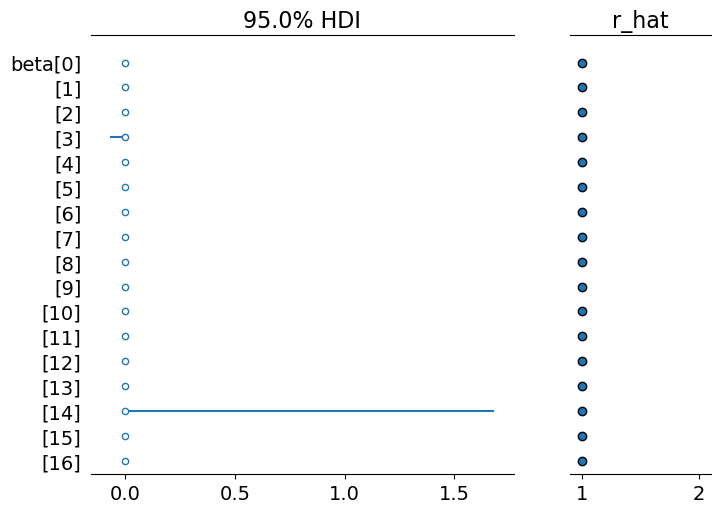

In [158]:
az.plot_forest(inference_results, var_names=["beta"], combined=True, hdi_prob=0.95, r_hat=True);

### Effective Sample Size

Interpretation: 
- Low ESS:
    - A low ESS suggests that the samples might be correlated or that the sampler is struggling to explore the parameter space efficiently.
    - This can lead to less reliable inference results.
- High ESS:
    - A high ESS indicates that the samples are more independent, providing a more accurate representation of the posterior distribution.
    - This means that the information in your posterior distribution is well-represented by the samples.
    
Factors Affecting ESS:
- Model Complexity:
    - More complex models can lead to lower ESS.
- Sampling Algorithm:
    - The choice of MCMC algorithm can affect ESS.
    - Some algorithms might be more efficient in certain situations.
- Number of Samples:
    - Increasing the number of samples can generally improve ESS, but there's a trade-off with computational cost.
    
Typical Range:
- While there's no strict threshold for a "good" ESS, values significantly lower than the number of samples can be a cause for concern.
- A general rule of thumb is that the ESS should be at least 100 for reliable inference.
- However, this can vary depending on the specific context and the complexity of the model.

Bulk vs Tail ESS: 
- ESS Bulk:
    - This refers to the effective sample size (ESS) of the bulk of the posterior distribution.
    - It's a measure of how many independent draws the MCMC sampler has effectively produced.
- ESS Tail:
    - This refers to the ESS of the tails of the posterior distribution.
    - It's a measure of how well the sampler has explored the extreme values of the distribution.
    
- Values: 
    - Ideally, the ESS bulk and tail should be similar in magnitude.
    - A large difference between the two can indicate potential convergence issues or an insufficient number of samples.
    - If the ESS tail is significantly smaller than the ESS bulk, it suggests that the sampler may not have adequately explored the tails of the distribution.
- Shape:
    - Symmetrical:
        - If the posterior is roughly symmetrical, it suggests that the data is providing strong evidence for a particular range of parameter values.
    - Skewed:
        - A skewed posterior indicates that the data favors one tail of the distribution over the other.
        - This could be due to factors like outliers or non-linear relationships.
    - Multimodal:
        - A multimodal posterior suggests that the data supports multiple plausible parameter values.
        - This could be due to model misspecification or the presence of multiple local optima.  

Improving ESS:

- Increase the Number of Samples:
    - Run the MCMC sampler for longer.
- Consider a Different Sampler:
    - Experiment with different MCMC algorithms.
- Reparameterize the Model:
    - If possible, reparameterize the model to improve mixing.

In [159]:
def plot_ess(summary_df, variables, states):
    """Plots Effective Sample Size (ESS) for bulk and tail of
    specified variables across different covariate values.

    Args:
      summary_df (pd.DataFrame):
          A DataFrame containing the summary statistics 
          including ESS values for different variables and 
          covariates (states or variables).
          
      variables (list):
          A list of variable names to plot the ESS for.
          
      states (list):
          A list of state names (if plotting ESS by state).

    Returns:
        None:
            This function creates plots and does not return any value.
      
    Typical Usage Example: 
        This allows you to visually assess the convergence of the
        MCMC sampler for each variable and state, helping you identify
        potential issues with model fit or sampling efficiency.      
        
        plot_ess(summary_df, inference_variables, inference_states)
    """

    
    for i, var_name in enumerate(['beta', 'beta_raw', 'ind', 'mu']):
        pattern = f'{var_name}\[(\d+)\]'

        filtered_df = summary_df[summary_df.index.str.match(pattern)]
        
        fig, ax = plt.subplots(figsize=(20, 5), nrows=2, ncols=1, sharex=True)
        fig.suptitle(f"ESS bulk and tail: {var_name}")
            
        if var_name in ['beta', 'beta_raw', 'ind']:
            ax[0].plot(variables, filtered_df['ess_bulk'])
            ax[0].set_title("ess bulk")
            ax[1].plot(variables, filtered_df['ess_tail'])
            ax[0].set_title("ess tail")
            # plt.xlim(0, len(filtered_df['ess_bulk']))

            plt.xticks(rotation=90)
            plt.show()
            
        else: 
            ax[0].plot(states, filtered_df['ess_bulk'])
            ax[0].set_title("ess bulk")
            ax[1].plot(states, filtered_df['ess_tail'])
            ax[0].set_title("ess tail")
            # plt.xlim(0, len(filtered_df['ess_bulk']))

            plt.xticks(rotation=45)
            plt.show() 

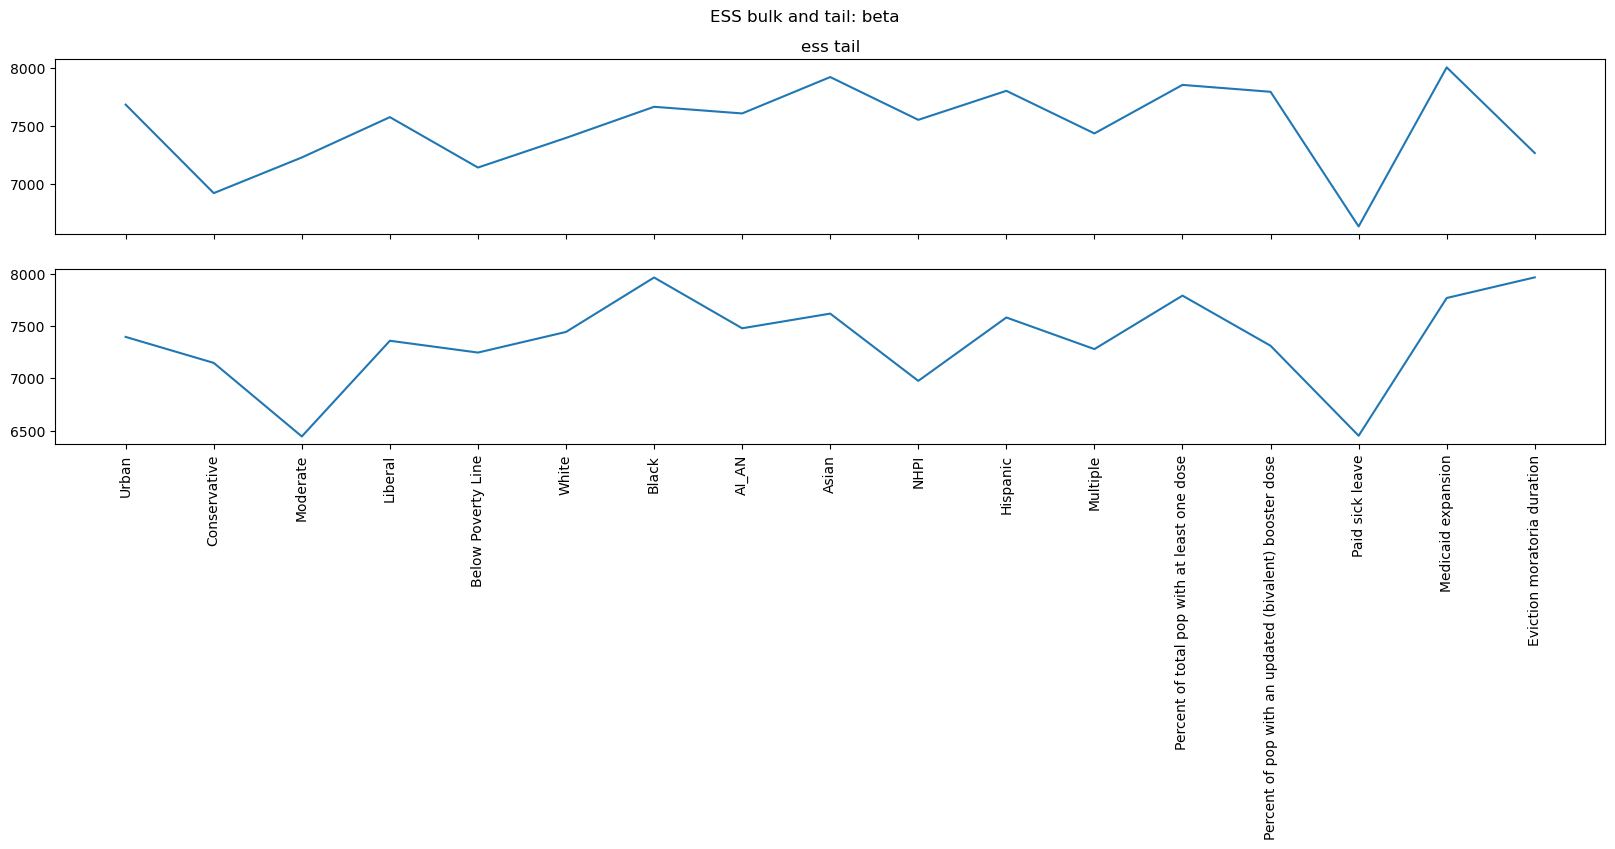

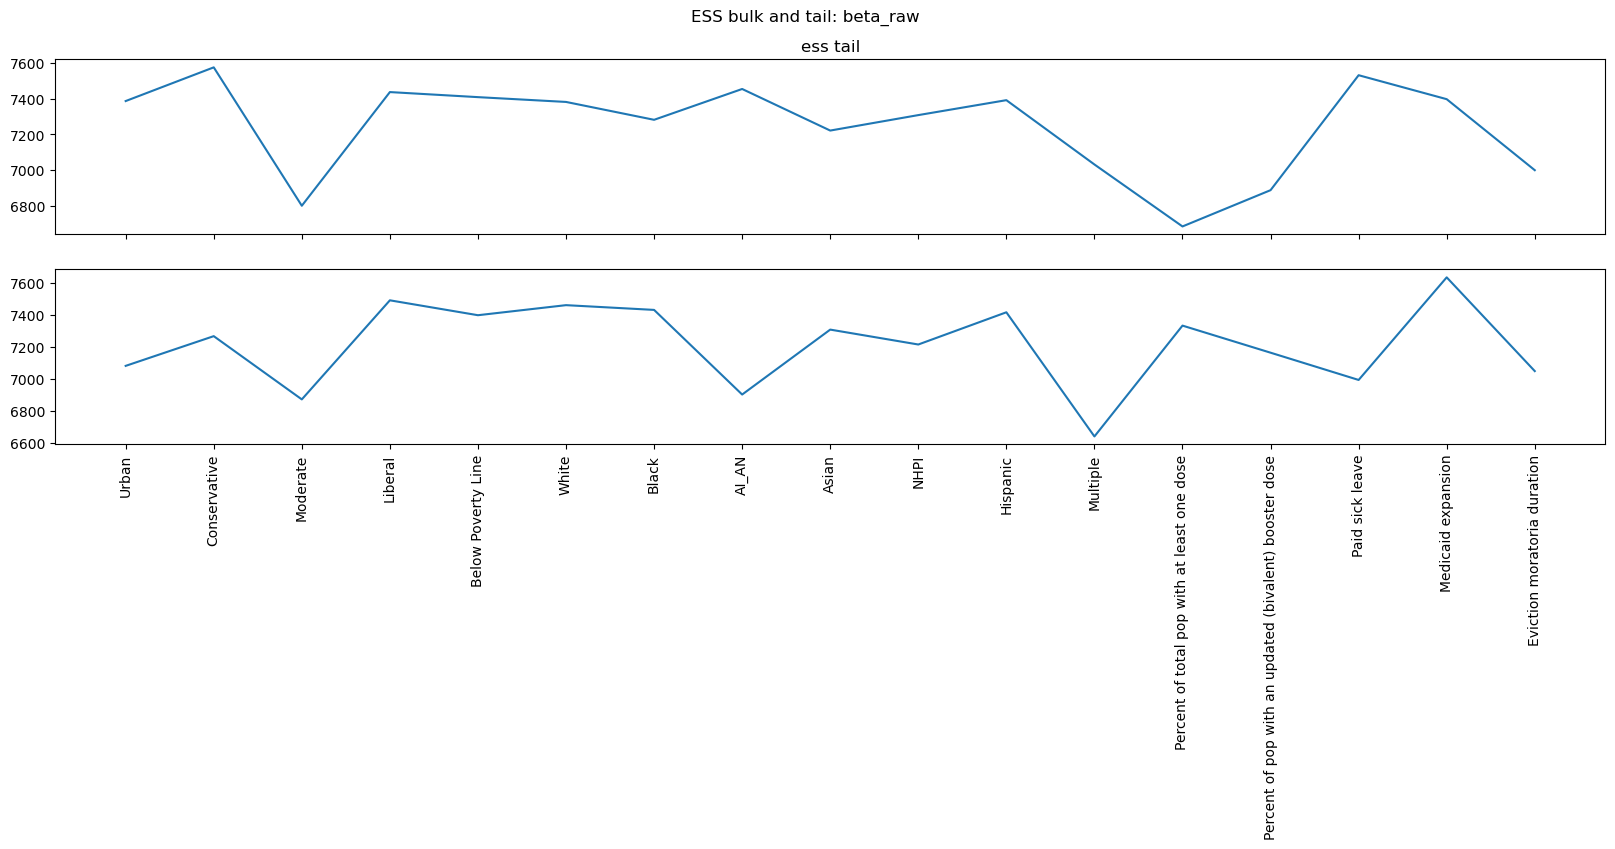

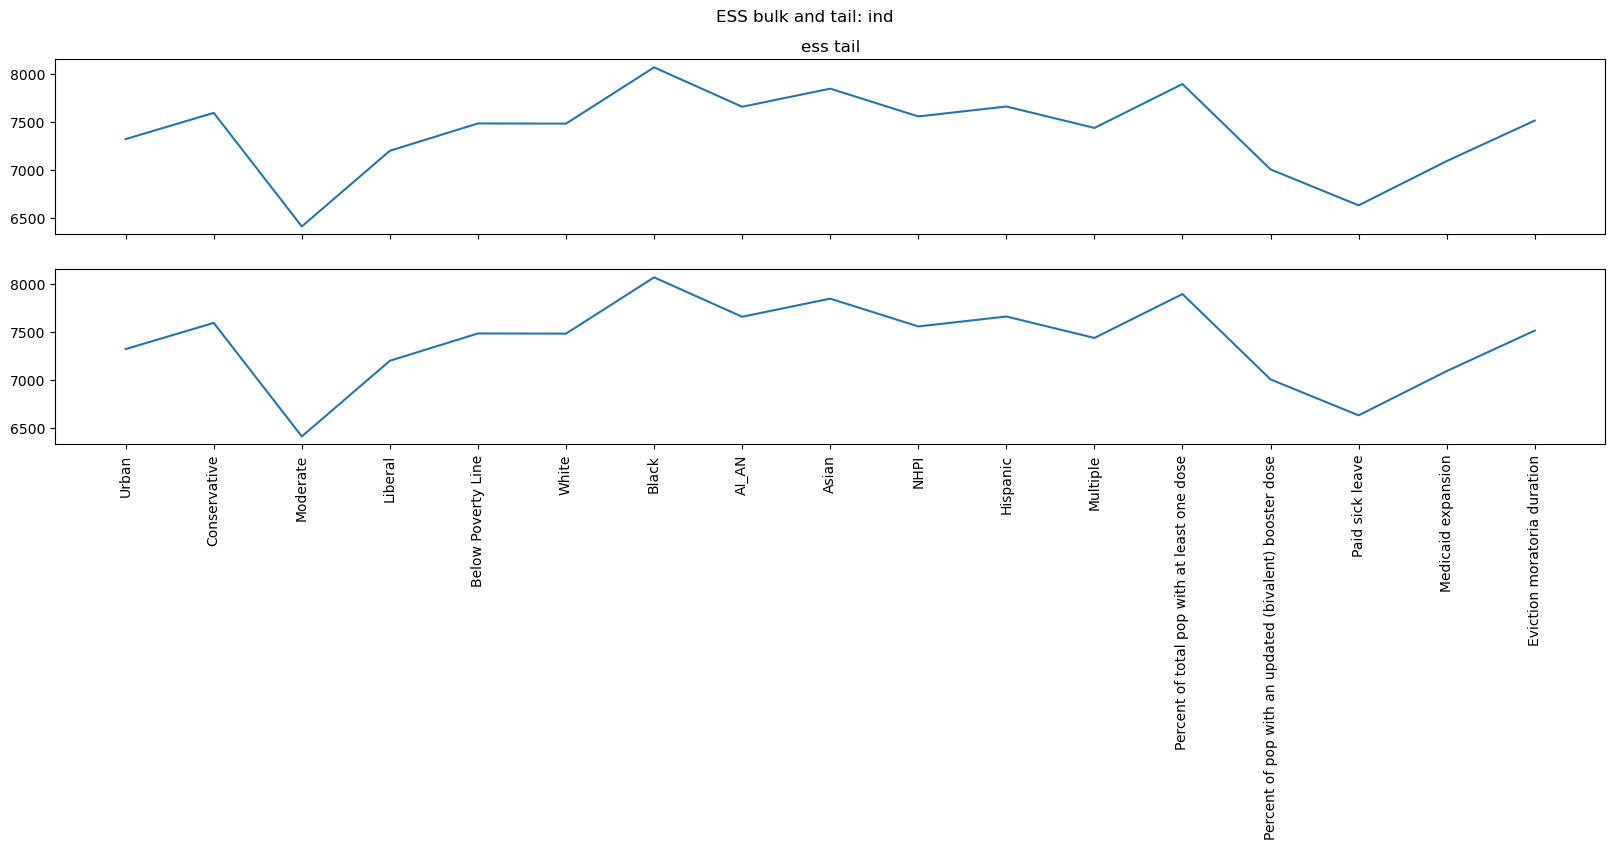

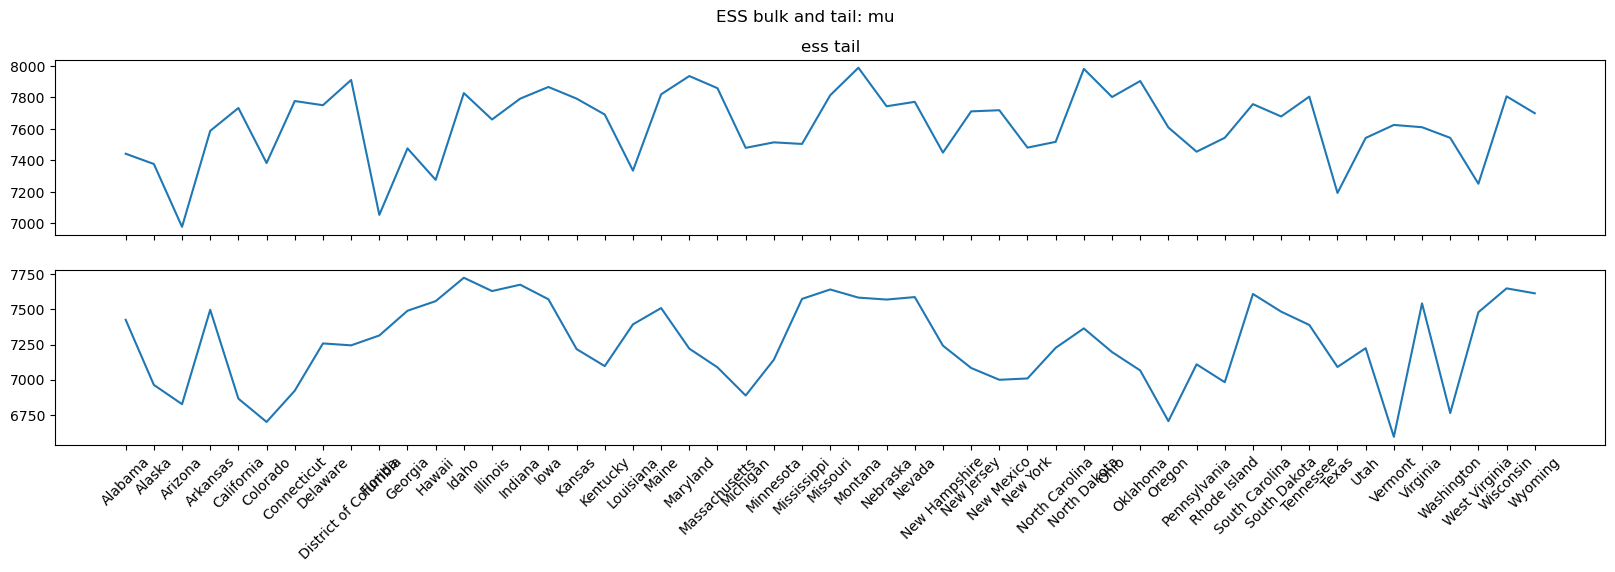

In [160]:
# Arviz method
# az.plot_ess(inference_results)
plot_ess(summary_df, inference_variables, inference_states)

### Trace Plots


- Density Plot:
    - Shape:
        - A symmetric, unimodal distribution indicates a well-defined posterior.
        - A skewed or multimodal distribution might suggest issues with the model or data.
    - Location:
        - The location of the peak indicates the most probable value of the parameter.
    - Spread:
        - The width of the distribution indicates the uncertainty around the parameter.
- Trace Plot:
    - Mixing:
        - The trace plot should show a well-mixed chain, meaning the sampler is exploring the parameter space effectively.
        - If the trace is stuck in a particular region, it might indicate convergence issues.
    - Stationarity:
        - The trace should appear stationary, meaning there are no clear trends or patterns over time.
        - A non-stationary trace might suggest that the sampler hasn't converged yet.
        
- Interpretation the Variables:
    - Beta:
        - The posterior distribution of beta indicates the importance of the corresponding features in the model.
        - A wider distribution suggests more uncertainty about the feature's importance.
        - Negative values indicate inverse relationships.
    - Beta_raw:
        - This represents the raw coefficients before feature selection.
        - A wider distribution might indicate that the feature is not strongly associated with the target variable.
    - Sigma:
        - The posterior distribution of sigma represents the uncertainty in the model's noise term.
        - A wider distribution indicates greater uncertainty.
        - Standard deviation of the noise term. A smaller value indicates less noise.
    - Ind:
        - The posterior distribution of ind represents the probability of each feature being included in the model.
        - A higher probability indicates a more important feature.
        - Indicator variables indicate whether a feature is included (1) or excluded (0) in the model.
    - Mu:
        - The posterior distribution of mu represents the uncertainty in the model's predictions.
        - Predicted mean values for the target variable.
    - Divergence:
        - Look for signs of divergence, such as sudden jumps in the trace plots or high R-hat values.

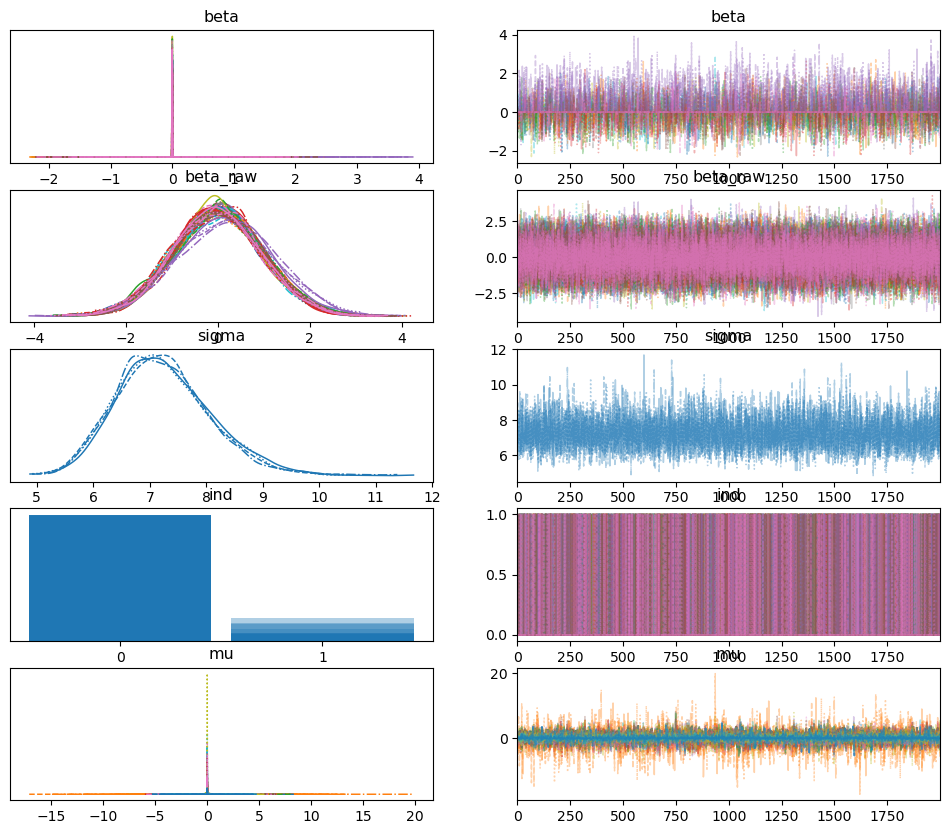

In [161]:
# Arviz method
# Left column are density plots which show the distribution of the parameter values.
# Right is the Trace Plot which plots the parameter values across MCMC iterations.
az.plot_trace(inference_results, var_names=["beta", "beta_raw", "sigma", "ind", "mu"]);

In [162]:
# def plot_result(
#     summary_df,
#     inference_variables, 
#     idx_pattern = r'beta\[(\d+)\]'
# ):
#     results = summary_df[summary_df.index.str.match(idx_pattern, regex=True)]
#     plt.plot(results, inference_variables)
#     plt.xticks(rotation=90)

#     plt.show()

### Posterior Distrubitions

In [163]:
# az.plot_posterior(inference_results)

### Model Fit

In [164]:
# # Log liklihood not in inference results. Need to add
# waic_score = az.waic(inference_results)  
# print(waic_score)

# loo_score = az.loo(inference_results)
# print(loo_score)

# ppc = az.from_pymc3(pm.sample_posterior_predictive(model, posterior_samples))


### Importance: np.abs(beta_means) * ind_means

- What is it? 
    - The importance variable typically represents a measure of the relative influence of different variables on a target variable in a Bayesian model.
    - It is often calculated by combining the posterior means of the coefficients (beta) with the inclusion probabilities (ind).
    - A higher importance value suggests that a variable is more likely to be influential in predicting the target variable.
    - The specific parameters that go into calculating importance can vary depending on the exact implementation, but generally include:
        - Posterior means of coefficients (beta): These represent the estimated effects of each variable on the target variable.
        - Inclusion probabilities (ind): These represent the probability that each variable is included in the model based on the posterior distribution.
- Notes: 
    - The importance metric is a relative measure and doesn't provide absolute values of effect size.
    - The typical range of values for the importance metric in Bayesian variable selection can vary widely depending on the specific problem, model complexity, and scale of the data.
    - Factors affecting the range:
        - Model complexity: More complex models with many variables and interactions might result in a wider range of importance values.
        - Data scale: The scale of the variables in the data can affect the scale of the coefficients and inclusion probabilities, which in turn affects the importance values.
        - Prior distributions: The choice of prior distributions for the coefficients and inclusion probabilities can influence the range of possible values.
- Higher values:
    - Variables with higher importance values are generally considered more influential in predicting the target variable.
    - This suggests that they have a stronger relationship with the outcome.
    - Variables with high importance might still have some degree of uncertainty associated with their effects, which can be assessed by examining the posterior distributions of their coefficients.
- Lower values:
    - Variables with lower importance values are less influential.
    - They might have weaker relationships or be less informative for predicting the target.
- Zero values:
    - Variables with an importance of zero are effectively excluded from the model, indicating that they have no significant impact on the target variable.

In [165]:
def plot_importance(
    importance,
    x_labels,
    importance_type
):
    """Creates a bar plot to visualize the importance of features.

    Args:
        importance (list):
            A list containing the importance scores for each feature.

        x_labels (list):
            A list of corresponding labels for the features.

        importance_type (str):
            A string describing the type of importance (e.g., gain, weight, etc.).

    Returns:
        None:
            This function creates a plot and does not return any value.
          
    Typical Usage Example: 
        This code will generate a bar chart representing the importance
        scores for each feature. The x-axis will display the feature labels
        rotated for readability, and the y-axis will represent the importance score.
    
        plot_importance(normalized_importance_1, x_labels, importance_type="Importance: Beta & Ind")
    
    """   
    plt.plot(importance, 'o')
    plt.suptitle(f"{importance_type}")
    plt.xlabel(x_labels)
    plt.xticks(range(len(importance)), x_labels, rotation=90)
    plt.show()

#### Calculate feature importance based on coefficient magnitude and inclusion probability

In [166]:
az.summary(inference_results, group="posterior")

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],-0.010,0.164,-0.000,-0.000,0.002,0.001,7685.0,7397.0,1.0
beta[1],0.015,0.184,-0.000,-0.000,0.002,0.002,6923.0,7148.0,1.0
beta[2],-0.008,0.169,0.000,-0.000,0.002,0.001,7230.0,6443.0,1.0
beta[3],-0.010,0.182,-0.000,0.000,0.002,0.002,7577.0,7360.0,1.0
beta[4],0.007,0.150,-0.000,0.000,0.002,0.001,7143.0,7247.0,1.0
beta[5],0.008,0.159,0.000,0.000,0.002,0.001,7399.0,7445.0,1.0
beta[6],-0.006,0.162,0.000,-0.000,0.002,0.001,7666.0,7967.0,1.0
beta[7],0.006,0.168,-0.000,-0.000,0.002,0.001,7609.0,7480.0,1.0
beta[8],-0.010,0.152,-0.000,-0.000,0.002,0.001,7922.0,7620.0,1.0
beta[9],-0.002,0.153,0.000,0.000,0.002,0.001,7554.0,6976.0,1.0


In [167]:
# posterior_means = az.summary(inference_results)['mean']
posterior_means = summary_df['mean']
posterior_std = summary_df['sd']

beta_means = posterior_means.loc[
    posterior_means.index.str.startswith('beta') & ~posterior_means.index.str.startswith('beta_raw')
]

beta_std = posterior_std.loc[
    posterior_std.index.str.startswith('beta') & ~posterior_std.index.str.startswith('beta_raw')
]

# beta_raw = posterior_means.loc[
#     posterior_means.index.str.startswith('beta_raw')
# ]

beta_raw = posterior_means.loc[
    posterior_means.index.str.startswith('beta_raw')
]

mu = posterior_means.loc[
    posterior_means.index.str.startswith('mu')
]

ind_means = posterior_means.loc[posterior_means.index.str.startswith('ind')]

beta_test = beta_raw

In [168]:
# importance_1 = np.multiply(ind_means.values.flatten(), np.abs(beta_means.values).flatten())
# importance_1 = np.multiply(ind_means.values.flatten(), np.abs(beta_raw.values).flatten())
importance_1 = np.multiply(ind_means.values.flatten(), beta_raw.values.flatten())

# Normalize importance from 0-1. Is this necessary?
normalized_importance_1 = (importance_1 - importance_1.min()) / (importance_1.max() - importance_1.min())

# importance

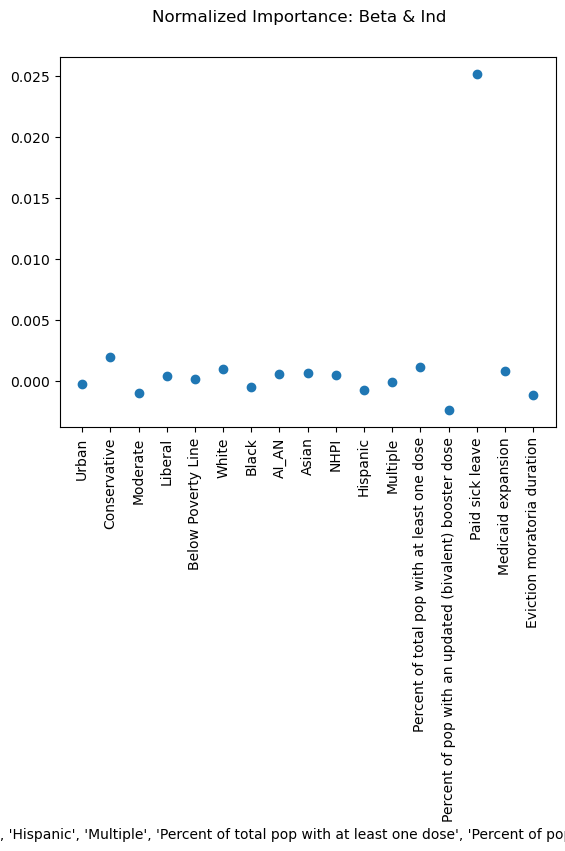

In [169]:
x_labels = list(df_variables.columns)

# plot_importance(beta_raw, x_labels, importance_type="Beta Raw")
plot_importance(importance_1, x_labels, importance_type="Normalized Importance: Beta & Ind")

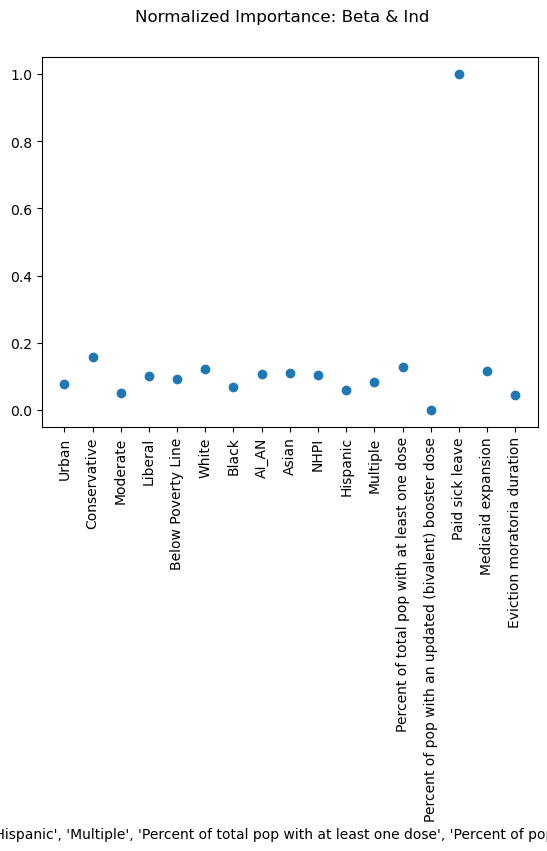

In [170]:
x_labels = list(df_variables.columns)

plot_importance(normalized_importance_1, x_labels, importance_type="Normalized Importance: Beta & Ind")

#### Calculate feature importance based on coefficient variance

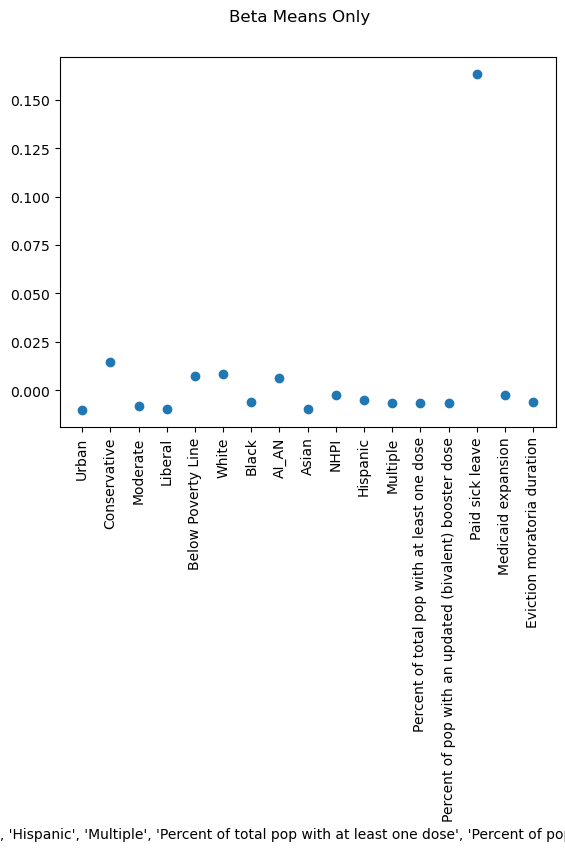

In [171]:
plot_importance(beta_means, x_labels, importance_type="Beta Means Only")

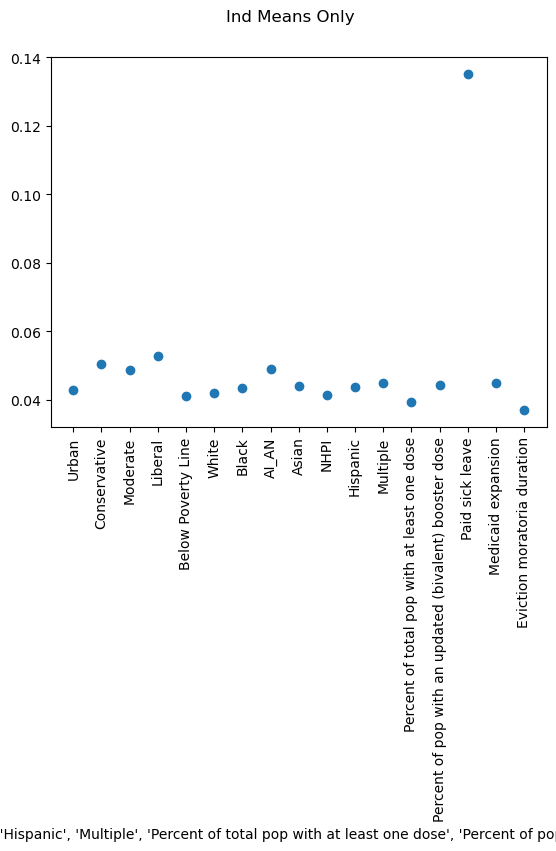

In [172]:
plot_importance(ind_means, x_labels, importance_type="Ind Means Only")

# Should work below here

In [173]:
beta_means = posterior_means.loc[
    posterior_means.index.str.startswith('beta') & ~posterior_means.index.str.startswith('beta_raw')
]

beta_raw = posterior_means.loc[
    posterior_means.index.str.startswith('beta_raw')
]

beta_std = posterior_std.loc[
    posterior_std.index.str.startswith('beta') & ~posterior_std.index.str.startswith('beta_raw')
]

ind_means = posterior_means.loc[posterior_means.index.str.startswith('ind')]

In [174]:
importance_3 = np.multiply(ind_means.values.flatten(), beta_raw.values.flatten())


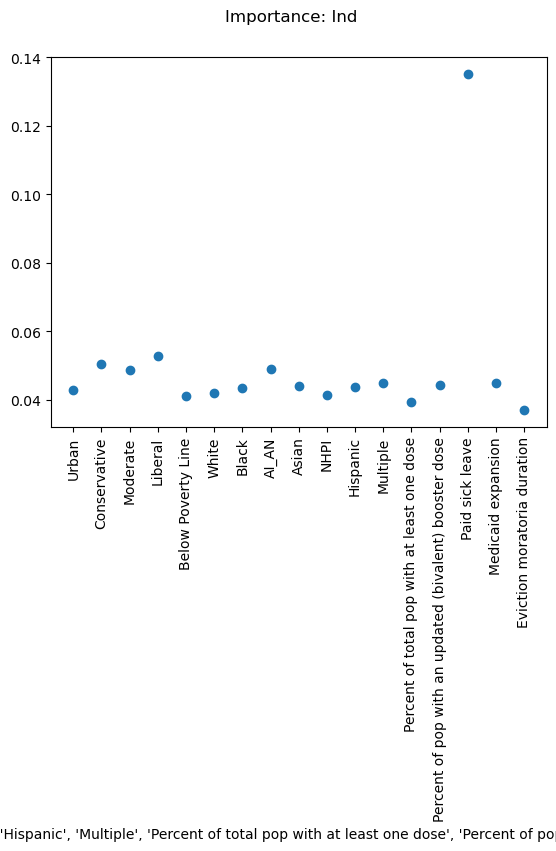

In [175]:
plot_importance(ind_means, x_labels, importance_type="Importance: Ind")

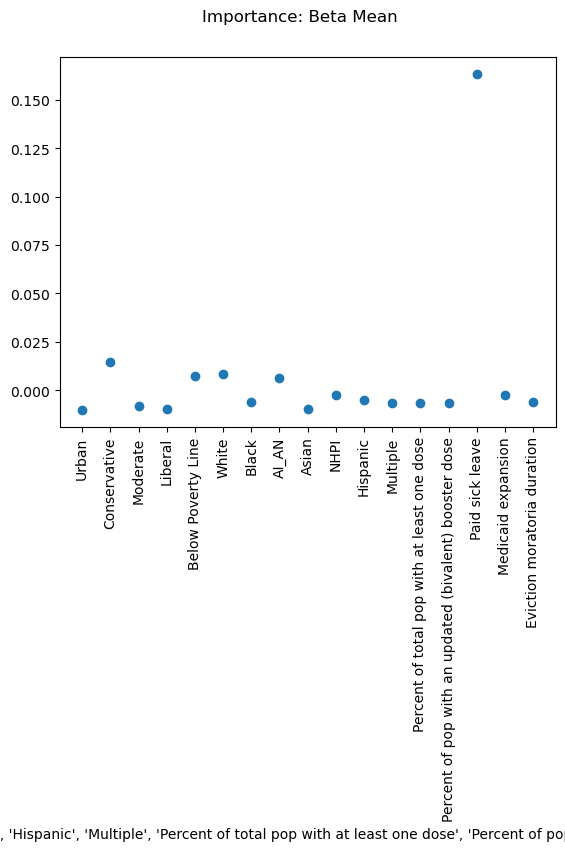

In [176]:
plot_importance(beta_means, x_labels, importance_type="Importance: Beta Mean")

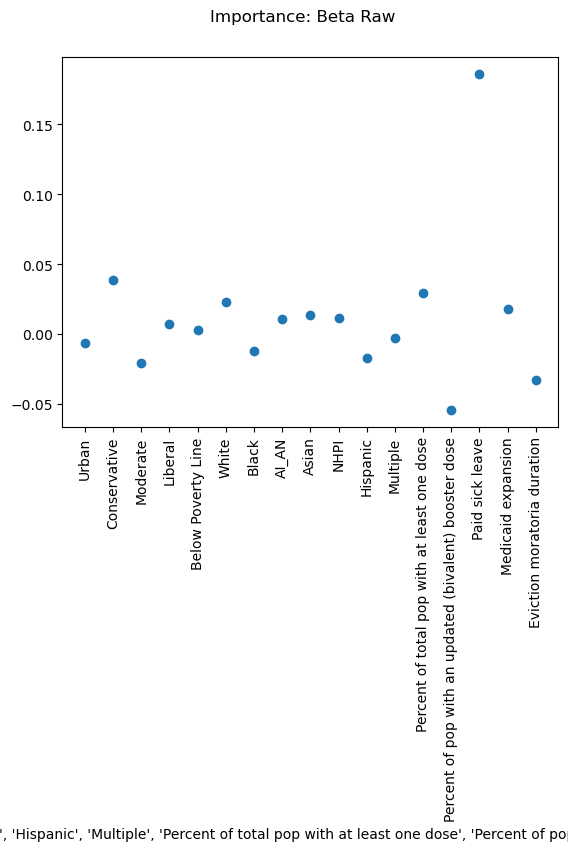

In [177]:
plot_importance(beta_raw, x_labels, importance_type="Importance: Beta Raw")

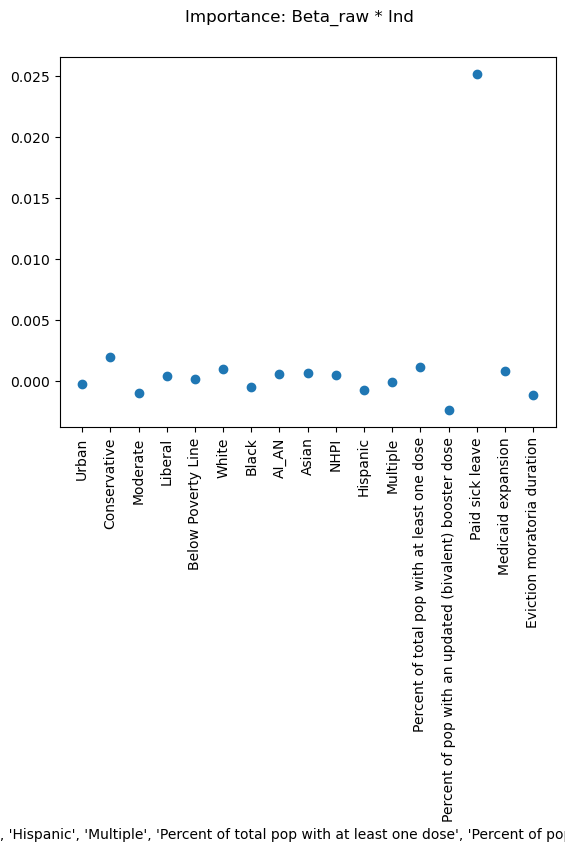

In [178]:
plot_importance(importance_3, x_labels, importance_type="Importance: Beta_raw * Ind")

In [179]:
# beta_means_new = beta_means.drop('beta[17]')
beta_means_new = beta_means_new.drop('beta[0]')

NameError: name 'beta_means_new' is not defined

In [ ]:
# ind_means_new = ind_means.drop('ind[17]')
ind_means_new = ind_means_new.drop('ind[0]')

In [ ]:
import_new =  np.multiply(beta_means_new.values.flatten(), ind_means_new.values.flatten())

In [ ]:
new_labels = [item for item in x_labels if item != 'Medicaid expansion']
new_labels = [item for item in new_labels if item != 'Rural']

In [ ]:
plot_importance(import_new, new_labels, importance_type="Importance")

In [ ]:
plot_importance(beta_means, x_labels, importance_type="Beta Means")